# Test modeling on larger synthetic dataset with 300bp
Use 5g sequences but score them simply.

Still try various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model


## ** See if we can learn on these data?
* overfit first?

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler


import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G data

In [3]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt.tsv"
XYdf = pd.read_csv(data_filename,sep='\t')
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237


In [4]:
# add synthetic score column
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

m1 = "CACACA"
m2 = "GTGTGT"
def score_seqs_motif(seqs):
    data = []
    for locus_tag,seq in seqs:
        seq = seq.strip("N")
        score = np.mean([score_dict[base] for base in seq])
        if m1 in seq:
            score += 10
        if m2 in seq:
            score -= 10
        data.append([locus_tag,score])
        
    df = pd.DataFrame(data, columns=['locus_tag','score'])
    return df

def score_indiv_seq_motif(seq):

    seq = seq.strip("N")
    score = np.mean([score_dict[base] for base in seq])
    if m1 in seq:
        score += 10
    if m2 in seq:
        score -= 10
    return score

In [5]:
syn_motif_dict = dict(score_seqs_motif(XYdf[['locus_tag','upstream_region']].values).values)
syn_motif_dict

{'EQU24_RS00005': 15.0,
 'EQU24_RS00010': 15.39,
 'EQU24_RS00015': 15.43,
 'EQU24_RS00025': 15.56,
 'EQU24_RS00060': 15.37,
 'EQU24_RS00065': 15.74,
 'EQU24_RS00080': 15.49,
 'EQU24_RS00085': 15.4,
 'EQU24_RS00105': 15.64,
 'EQU24_RS00110': 15.53,
 'EQU24_RS00125': 15.58,
 'EQU24_RS00165': 15.51,
 'EQU24_RS00175': 15.46,
 'EQU24_RS00180': 15.74,
 'EQU24_RS00185': 15.89,
 'EQU24_RS00195': 15.43,
 'EQU24_RS00200': 15.42,
 'EQU24_RS00205': 15.54,
 'EQU24_RS00210': 15.24,
 'EQU24_RS00215': 15.55,
 'EQU24_RS00225': 15.49,
 'EQU24_RS00230': 15.61,
 'EQU24_RS00245': 15.14,
 'EQU24_RS00250': 15.92,
 'EQU24_RS00255': 16.35,
 'EQU24_RS00260': 16.5,
 'EQU24_RS00265': 15.68,
 'EQU24_RS00270': 15.6,
 'EQU24_RS00275': 5.220000000000001,
 'EQU24_RS00295': 15.51,
 'EQU24_RS00300': 15.67,
 'EQU24_RS00315': 15.25,
 'EQU24_RS00320': 16.2,
 'EQU24_RS00330': 15.62,
 'EQU24_RS00370': 15.28,
 'EQU24_RS00385': 15.42,
 'EQU24_RS00390': 15.39,
 'EQU24_RS00400': 15.65,
 'EQU24_RS00405': 15.46,
 'EQU24_RS00425': 

In [6]:
XYdf['syn_score'] = XYdf['locus_tag'].apply(lambda x: syn_motif_dict[x])
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,syn_score
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143,15.000000
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725,15.390000
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782,15.430000
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343,15.560000
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613,15.370000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619,15.380000
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777,15.870000
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596,15.860000
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237,16.220000


In [7]:
loc2seq = dict([(x,z) for (x,z) in XYdf[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


### Standard scaler

In [8]:
conds = ['uMax', 'lowO2_fast_growth',
       'lowCH4', 'MeOH', 'NoCu', 'medCu', 'highCu', 'lowCu',
       'highO2_slow_growth', 'NO3_lowO2_slow_growth', 'WithLanthanum',
       'NoLanthanum','syn_score']

scaler = StandardScaler()
testdf = pd.DataFrame(scaler.fit_transform(XYdf[conds]), columns=conds)
XYdf[conds] = testdf

In [9]:
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,syn_score
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.327948,0.002756,0.065781,0.091715,0.0,0.554522,0.362603,0.244177,0.243572,-0.341874,-0.466231,-0.575218,-0.223553
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.061563,-0.179146,-0.279901,-0.695115,0.0,0.831405,0.817518,0.655624,0.452677,-0.321788,-0.599550,-0.605832,-0.058017
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.367538,0.311181,-0.033426,0.427210,0.0,0.656376,0.570998,0.608998,0.378694,-0.273585,-0.557949,-0.486607,-0.041039
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,0.009245,-0.306425,-0.082030,-0.585877,0.0,0.421584,0.141970,0.628643,0.352838,-0.115863,-0.619209,-0.448001,0.014140
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.054225,0.372931,-0.556422,-0.355404,0.0,0.307981,0.339761,0.147701,-0.915164,-0.095069,-0.052064,-0.025448,-0.066506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.101247,0.603118,0.479489,-1.803302,0.0,-0.776851,0.137609,-0.627435,-1.809595,-0.226644,-0.998419,-0.801586,-0.062261
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.070518,-0.425593,-0.731660,-0.486277,0.0,0.583163,0.474360,0.521988,-0.473800,-0.603881,-1.243207,-1.299381,0.145719
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.113774,-0.192980,-0.623608,0.257795,0.0,-0.391126,0.276903,-0.860048,-0.667834,-0.822692,-0.136356,-0.270619,0.141475
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.128919,-0.259665,-0.258039,0.310878,0.0,0.317332,-0.110642,-0.111351,-0.213692,-0.256075,-0.093440,-0.039713,0.294277


In [10]:
df_meansT_melt = pd.melt(XYdf, id_vars=['og_index','locus_tag','upstream_region'],var_name="exp_condition",value_name='tpm')
df_meansT_melt

,og_index,locus_tag,upstream_region,exp_condition,tpm
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,uMax,0.327948
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,uMax,0.061563
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,uMax,0.367538
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,uMax,0.009245
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,uMax,0.054225
...,...,...,...,...,...
28647,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,syn_score,-0.062261
28648,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,syn_score,0.145719
28649,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,syn_score,0.141475
28650,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,syn_score,0.294277


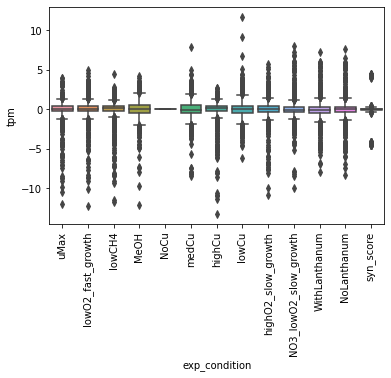

In [11]:
sns.boxplot(data=df_meansT_melt,x="exp_condition",y="tpm")
#plt.ylim(-1,1000)
plt.xticks(rotation=90)
plt.show()

In [12]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()

## Load 5G seqs into data loaders

In [13]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [14]:
full_train_df,test_df = tu.quick_split(XYdf)
train_df, val_df = tu.quick_split(full_train_df)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='syn_score'
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [49]:
for i in ohe_train_dl:
    print(i[0].shape)
    break

torch.Size([128, 300, 4])


In [15]:
print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(1763, 17)
(441, 17)
(1410, 18)
(353, 18)


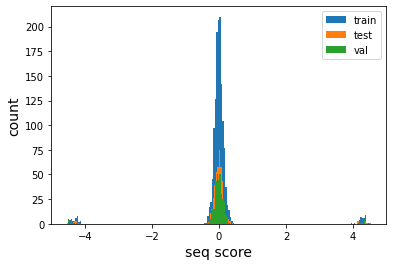

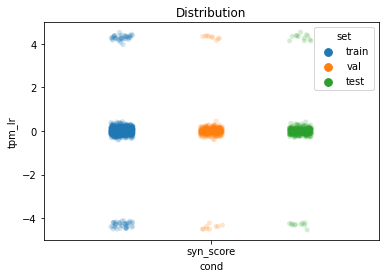

In [16]:
plot_train_test_hist(train_df, test_df, val_df=val_df,score_col='syn_score',bins=200)
view_train_test_dist(train_df, test_df,["syn_score"],val_df=val_df)

In [17]:
train_df[train_df['syn_score'] < -1].shape

(39, 19)

In [18]:
seqs = train_df['upstream_region'].values

print("CACACA:",len([x for x in seqs if m1 in x]))
print("GTGTGT:",len([x for x in seqs if m2 in x]))

print("NO CACACA:",len([x for x in seqs if m1 not in x]))
print("NO GTGTGT:",len([x for x in seqs if m2 not in x]))

print("BOTH:",len([x for x in seqs if (m2 in x and m1 in x)]))
print("NEITHER:",len([x for x in seqs if (m2 not in x and m1 not in x)]))

CACACA: 39
GTGTGT: 40
NO CACACA: 1371
NO GTGTGT: 1370
BOTH: 1
NEITHER: 1332


## Non-optuna training

In [19]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
    loss = loss_func(xb_out, yb.float())

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

In [27]:
class DNA_Linear_Shallow(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        
        #print("og shape?",xb.shape)
        #xb = xb.flatten()
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        #print("flattened shape?",xb.shape)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_Linear_Deep(nn.Module):
    def __init__(
        self, 
        seq_len,
        h0_size=24,
        h1_size=24
    ):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h0_size, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.Linear(100, 10),
            #nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

class Kmer_Linear(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True),
            nn.Linear(h2_size, 1),
        )
        
        
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

In [21]:
def parity_plot_multi(model,df, pearson):
    #plt.scatter(df['pred'].values, df['truth'].values, alpha=0.2)
    sns.scatterplot(data=df,y='pred',x='truth',hue='task',alpha=0.2)
    #draw y=x line
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, color='k', lw=1, scalex=False, scaley=False)

    plt.ylim(xpoints)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.xlabel("Actual Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    
    plt.show()

def alt_parity_plot_multi(model,df, pearson,task):
    '''
    Make an interactive parity plot with altair
    '''
    chart = alt.Chart(df).mark_circle(opacity=0.2).encode(
        alt.Y('pred:Q'),
        alt.X('truth:Q'),
        tooltip=['seq:N']
    ).properties(
        title=f'Model (pearson:{pearson})'
    ).interactive()
    
    chart.save(f'alt_out/parity_plot_{task}_{model}.html')
    
    
def parity_pred_multi(models, genes, oracle,task,objs,alt=True,syn_data=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: (pearson corr, parity_df)
    
    
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.item() for x in model(s.float())]

            for i in range(len(preds)):
                data.append((gene,actual[i], preds[i],objs[i],dna))

        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','task','seq'])
        pearson = df['truth'].corr(df['pred'])
        
        if not syn_data: # if using real genes, add real gene info
            df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
            df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])
            df['type'] = df['locus_tag'].apply(lambda x: locus2info[x]['type'])
        
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot_multi(model_name, df, pearson,task)
        parity_plot_multi(model_name, df, pearson)

    return dfs

In [52]:
class TINKER_DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters0=32,
                 num_filters1=32,
                 kernel_size0=8,
                 kernel_size1=8,
                 conv_pool_size0=1,
                 conv_pool_size1=1,
                 fc_node_num0 = 100,
                 fc_node_num1 = 100
                ):
        super().__init__()
        
        self.seq_len = seq_len
        #self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
        linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
        linear_node_num = linear_node_num*num_filters1


        
        self.conv_net = nn.Sequential(
            # Conv layer 0
            nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),

            # Conv layer 1
            nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
            nn.ReLU(),
            
            nn.Flatten(),
            # Fully connected layer 0
            nn.Linear(linear_node_num, fc_node_num0),
            nn.ReLU(),
            # Fully connected layer 0
            nn.Linear(fc_node_num0, fc_node_num1),
            nn.ReLU(),
            # final prediction
            nn.Linear(fc_node_num1, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out

### Deep linear

0 0.9968380771007483
1 0.9696510028906652
2 0.9615078457016445
3 0.9548565853418777
4 1.0036060865810168
5 0.9365180918245073
6 0.9288427341761062
7 0.9305509288317759
8 1.0091325034500858
9 0.9136173944635364
10 1.7008482845916963
11 0.9226096125567601
12 0.9585820654296334
13 11.135056749619437
14 0.9396906932420164
15 0.9305091564445928
16 0.9315383927342574
17 0.9150898444753869
18 0.908251363562457
19 0.9130016455569281
20 0.9066721361352094
21 0.9176883354740846
22 6.391889534320777
23 0.9282278764686909
24 1.0334946057276415
25 0.9214556082112255
26 0.9868133770507727
27 1.0010524577864843
28 1.1421496446004333
29 0.9568343115258149
30 0.9764029927361788
31 1.193110817552626
32 1.0466439109348373
33 6.137812838675956
34 0.8948780046644021
35 0.9030291796068294
36 0.9211989215683329
37 0.9637407245109169
38 0.9588153784403383
39 0.9769100707245953
40 1.0122377360846435
41 1.01107704757631
42 1.3874139498718738
43 0.9825455335314484
44 2.525688320651608
45 0.9445697133331731
46 0.

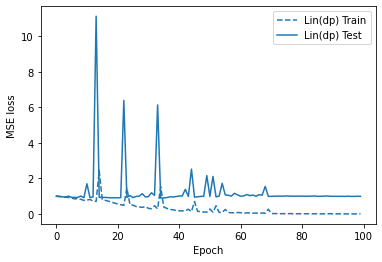

In [33]:
seq_len = len(train_df['upstream_region'].values[0])
hidden_layer_size = 10000

mer8motif_model_lin_d = DNA_Linear_Deep(
    seq_len,
    h0_size=10000,
    h1_size=10000,
)
mer8motif_model_lin_d.to(DEVICE)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d,
    lr=0.01,
    epochs=100
)

# to plot loss
mer8motif_lin_d_data_label = [((mer8motif_train_losses_lin_d,mer8motif_test_losses_lin_d),"Lin(dp)")]

tu.quick_loss_plot(mer8motif_lin_d_data_label)

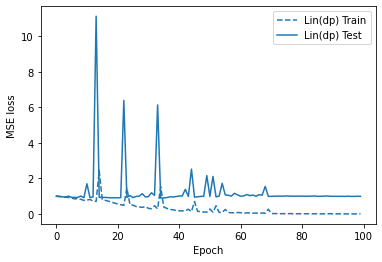

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=10000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10000, out_features=10000, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=10000, out_features=1, bias=True)
  )
)

In [41]:
tu.quick_loss_plot(mer8motif_lin_d_data_label)

mer8motif_model_lin_d

### CNN model

In [51]:
ohe_train_dl

In [55]:
seq_len = len(train_df['upstream_region'].values[0])
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    fc_node_num0=100,
    fc_node_num1=100
)
mer8motif_model_cnn.to(DEVICE)

mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    lr=0.01,
    epochs=100,
)

# to plot loss
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN')]


0 0.9829894056063536
1 0.9824649139436716
2 0.9822141695292745
3 0.9819569089595049
4 0.981650932483565
5 0.9812893026611285
6 0.9810262771571324
7 0.9807518315382787
8 0.9804210605432224
9 0.9808847129176088
10 0.980127107151507
11 0.9795335536300291
12 0.9791599032561434
13 0.9785440115010097
14 0.9782282867107446
15 0.9775979334842044
16 1.0304629402525365
17 0.9851718391304989
18 0.9814679614207562
19 1.0257285122493172
20 0.9875288431772767
21 0.9809451358176493
22 0.9795280943173524
23 0.9790339047780455
24 0.9785842106970444
25 0.9783964177366694
26 0.9778030335734316
27 0.977255714176059
28 0.9767584324558464
29 0.9769265903291892
30 0.9763838457993678
31 0.9755734612178533
32 1.0188015805763158
33 0.9840790242716544
34 1.005235873605982
35 0.9805004101974768
36 1.020866400797036
37 0.9792628816774817
38 0.9739996198216512
39 1.0414101810698468
40 0.9734321857984614
41 0.9726667471715479
42 0.9707763725232132
43 0.9700397280052768
44 0.9688081619759795
45 0.967266007118117
46 0

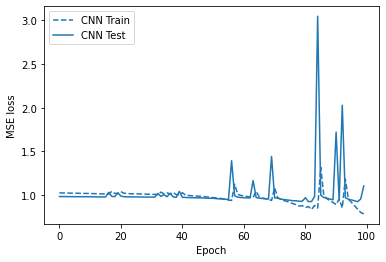

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=9376, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [56]:
tu.quick_loss_plot(mer8motif_cnn_data_label)

mer8motif_model_cnn

Running LinearDeep


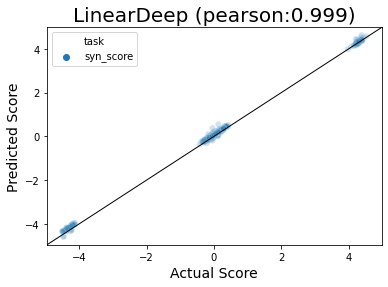

Running CNN


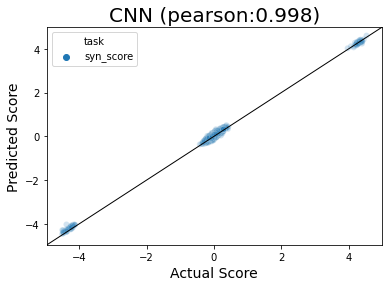

In [43]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


seqs = train_df['locus_tag'].values #val_df['locus_tag'].values
task = "6mer_motif"

oracle_syn = dict([(a,[b]) for a,b in XYdf[['locus_tag','syn_score']].values])


dfs = parity_pred_multi(models, seqs, oracle_syn,task,['syn_score'],alt=False)

Running LinearDeep


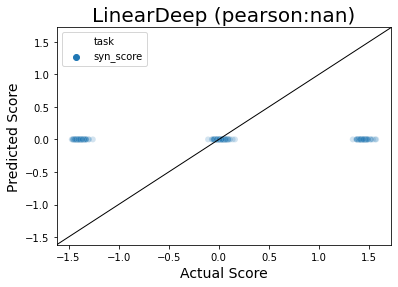

Running CNN


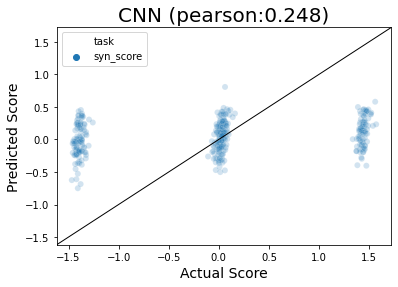

In [144]:
# models = [
#     ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
#     ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
# #     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
# #     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
# ]


# seqs = val_df['locus_tag'].values#train_df['locus_tag'].values #val_df['locus_tag'].values#
# task = "6mer_motif"

# oracle_syn = dict([(a,[b]) for a,b in XYdf[['locus_tag','syn_score']].values])


# dfs = parity_pred_multi(models, seqs, oracle_syn,task,['syn_score'],alt=False)

## Maybe need more examples?


In [6]:
seq_length = 300
syn_seqs_100k = []
for i in range(100000):
    my_seq = ''.join(np.random.choice(('C','G','T','A'), seq_length ))
    syn_seqs_100k.append(my_seq)

In [7]:
len(syn_seqs_100k)

100000

In [46]:
print("CACACA:",len([x for x in syn_seqs_100k if m1 in x]))
print("GTGTGT:",len([x for x in syn_seqs_100k if m2 in x]))

print("NO CACACA:",len([x for x in syn_seqs_100k if m1 not in x]))
print("NO GTGTGT:",len([x for x in syn_seqs_100k if m2 not in x]))

print("BOTH:",len([x for x in syn_seqs_100k if (m2 in x and m1 in x)]))
print("NEITHER:",len([x for x in syn_seqs_100k if (m2 not in x and m1 not in x)]))

CACACA: 6423
GTGTGT: 6576
NO CACACA: 93577
NO GTGTGT: 93424
BOTH: 433
NEITHER: 87434


In [11]:
syn_seqs_10k = u.downselect_list(syn_seqs_100k, 10000)
#syn_seqs_100k = u.downselect_list(syn_seqs_1m, 100000)
len(syn_seqs_10k)

10000

In [12]:
syn_df = pd.DataFrame(enumerate(syn_seqs_100k), columns=['id','seq']) 

In [15]:
syn_df['syn_score'] = syn_df['seq'].apply(lambda x: score_indiv_seq_motif(x))
syn_df['syn_score2'] = syn_df['seq'].apply(lambda x: score_indiv_seq_motif(x))

conds = ['syn_score','syn_score2']

scaler = StandardScaler()
testdf = pd.DataFrame(scaler.fit_transform(syn_df[conds]), columns=conds)
syn_df[conds] = testdf

syn_df.head()

,id,seq,syn_score,syn_score2
0,0,CGCAACCCTCGCACGGCTGGCGACCCCAAGCCATTAGAGACATGTT...,0.109538,0.109538
1,1,AGTTCCGCTGCCAACATAGGTCTCCTGGTGTATGGGTTGTAGTACA...,0.006959,0.006959
2,2,AAGAAGGTATGACGAGCGGGCGGGTGATTGGGTACAGCACAATGTT...,-2.833906,-2.833906
3,3,AAATGACGCAGCATTCACAGGTTGATCGGGGGATAGTTGCACTTTT...,-0.169704,-0.169704
4,4,TTTTCGACAATTTTGGTTCGTTAGGTTTAAACGAAATTATTTGCCG...,-0.012987,-0.012987


In [30]:
loc2seq = dict([(x,z) for (x,z) in syn_df[['id','seq']].values])


In [16]:
full_train_df,test_df = tu.quick_split(syn_df)
train_df, val_df = tu.quick_split(full_train_df)

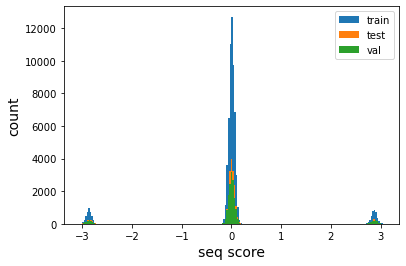

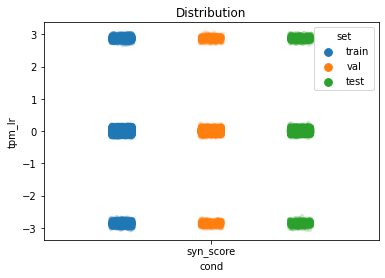

In [19]:
plot_train_test_hist(train_df, test_df, val_df=val_df,score_col='syn_score',bins=200)
view_train_test_dist(train_df, test_df,["syn_score"],val_df=val_df,id_col='id')

In [20]:
train_df.shape

(64000, 7)

In [24]:
# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='seq',
    target_col='syn_score'
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

0 0.9978075342178345
1 0.9965613832473755
2 0.9959455533027649
3 0.9947244958877564
4 0.9937861013412476
5 0.9926843943595887
6 0.9915765089988708
7 0.9905279364585876
8 0.9889508981704712
9 0.9874969310760499
10 0.9859639954566956
11 0.984306513786316
12 0.9825057535171509
13 0.9810482225418091
14 0.9792152581214905
15 0.977754033088684
16 0.976376130104065
17 0.9753495845794677
18 0.9750670490264892
19 0.9745084915161133
20 0.9742017183303833
21 0.9734497213363648
22 0.9736146306991578
23 0.9733582253456116
24 0.9733605604171753
25 0.973266586303711
26 0.9754972763061523
27 0.975637981414795
28 0.9732777729034424
29 0.9731917533874511
30 0.9733714475631714
31 0.974078290462494
32 0.9734525403976441
33 0.9735412707328797
34 0.9741484303474426
35 0.9737423944473267
36 0.9740656270980835
37 0.973802930355072
38 0.9740284147262573
39 0.9748582534790039
40 0.9744023327827454
41 0.97464554977417
42 0.9742959518432617
43 0.9743280935287476
44 0.9747832946777344
45 0.9745221166610718
46 0.97

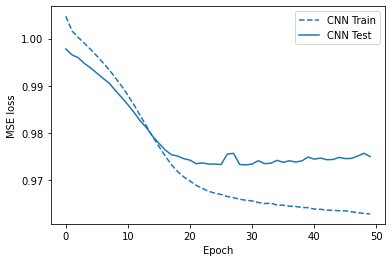

In [68]:
seq_len = len(train_df['seq'].values[0])

syn_motif_model_cnn = DNA_CNN(
    seq_len,
    kernel_size=8,
    num_filters=4
)

syn_motif_model_cnn.to(DEVICE)

syn_motif_train_losses_cnn, \
syn_motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    syn_motif_model_cnn, 
    lr=0.001,
    epochs=50,
)

# to plot loss
syn_motif_cnn_data_label = [((syn_motif_train_losses_cnn,syn_motif_test_losses_cnn),'CNN')]
tu.quick_loss_plot(syn_motif_cnn_data_label)

Running CNN


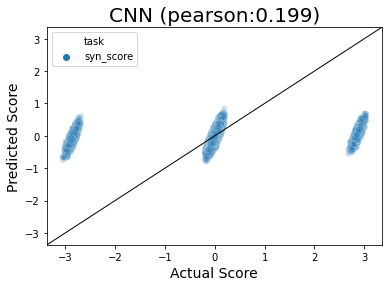

Running CNN


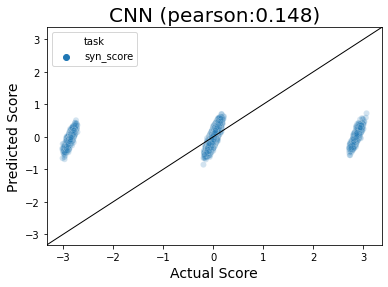

In [69]:
models = [
    #("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",syn_motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]

train_seqs = train_df['id'].values #val_df['locus_tag'].values#
val_seqs = val_df['id'].values#train_df['locus_tag'].values #val_df['locus_tag'].values#
task = "6mer_motif"

oracle_syn = dict([(a,[b]) for a,b in syn_df[['id','syn_score']].values])

tdfs = parity_pred_multi(models, train_seqs, oracle_syn,task,['syn_score'],alt=True,syn_data=True)
vdfs = parity_pred_multi(models, val_seqs, oracle_syn,task,['syn_score'],alt=True,syn_data=True)

Total convolutional layers: 1


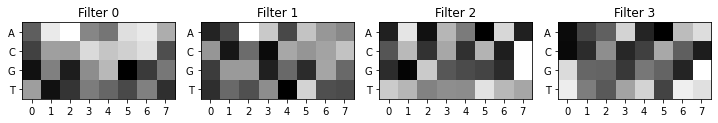

In [70]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(syn_motif_model_cnn)
view_filters(model_weights)

In [26]:

#filter_activations = get_filter_activations(syn_seqs_10k, conv_layers[0])

torch.Size([4, 4, 8])


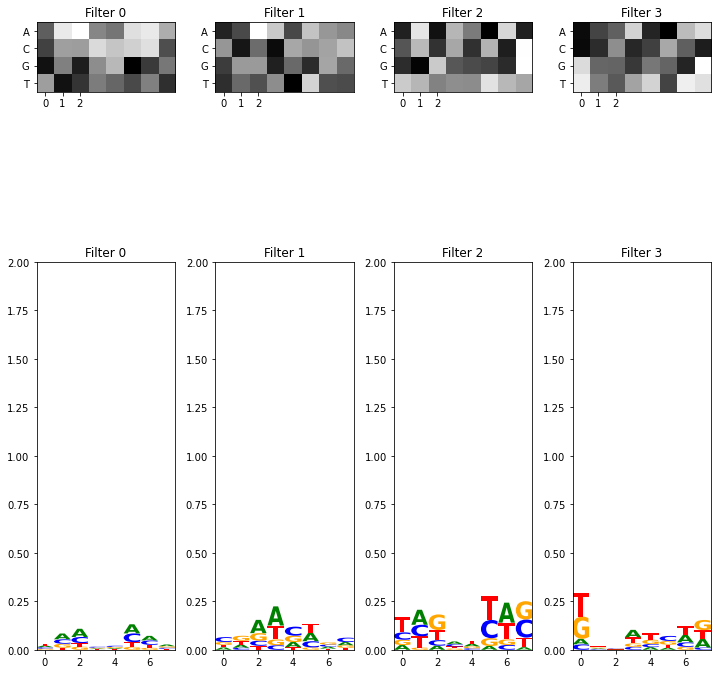

In [72]:

view_filters_and_logos(model_weights,filter_activations)

In [85]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 40))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(3))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

## Optuna objective functions
study.optimize seems to only take trial as an input and automatically. In order to pass epochs and train/test data loaders, I think I have to wrap it in an extra Model class? Then calls the Model's self.objective?

In [73]:
class OptWrap:
    '''
    Adapted from: 
    https://github.com/FernandoLpz/Optuna-Sklearn-PyTorch/blob/master/optuna_pytorch.py
    
    Optuna needs to call "study.optimize" on a function with no inputs other 
    than trial... trying to make that happen here...
    '''
    
    def __init__(self, 
                 name, 
                 model_class, 
                 seq_len, 
                 epochs, 
                 loss_func, 
                 learning_rate,
                 train_loader, 
                 test_loader
                ):
        self.name = name
        self.model_class = model_class
        self.seq_len = seq_len
        self.epochs = epochs
        self.loss_func = loss_func
        self.learning_rate = learning_rate
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_loss_list = []
        self.test_loss_list = []
        self.trial_count = 0
        self.best_train_loss = None
        self.best_test_loss = None
        self.best_model = None
        
    def optimize(self, trial):
        self.trial_count += 1 # increments with trials run for this model
        # Initialize model with the current trial
        model = self.model_class(trial, self.seq_len).to(DEVICE)
        train_losses = []
        test_losses = []
        # ^^ collect per trial
        
        # Define space search for training settings
        #learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        
        # in the future, consider optimizer as a hyperparameter
        #optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
        #opt = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
        opt = torch.optim.SGD(model.parameters(), lr=self.learning_rate) 
        
        # Starts training phase
        for epoch in range(self.epochs):
            train_loss = tu.train_step(model, self.train_loader, loss_func, DEVICE, opt)
            
            test_loss = tu.test_step(model, self.test_loader, loss_func, DEVICE)
            print(f"E{epoch}: {test_loss}")
            
            # keep track of these for plotting loss by epoch later
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            # decide if trial should be pruned
            trial.report(test_loss, epoch)
            if trial.should_prune():
                # add partial trials to the train history
                self.train_loss_list.append(train_losses)
                self.test_loss_list.append(test_losses)
                
                raise optuna.exceptions.TrialPruned()
                
        
        # return history of this trials training/test loss?
        self.train_loss_list.append(train_losses)
        self.test_loss_list.append(test_losses)
        
        # return final test loss?? or best test loss?? 
        # TODO/QUESTION: try best test loss instead of final
        # CALLBACKS?
        
        print("****Model Arch ****")
        print(model)
        print("*******************")
        
        return test_loss
    
    def retrain_best(self, trial):
        '''
        Use a Frozen trial to retrain/return a model with the 
        best hyperparameters
        '''
        assert(type(trial) == optuna.trial.FrozenTrial)
        
        model = self.model_class(trial, self.seq_len).to(DEVICE)
        train_losses = []
        test_losses = []
        
        # These aren't suggestions anymore - they are chosen from the 
        # specs of the Frozen Trial
        #learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        
        # in the future, consider optimizer as a hyperparameter
        #optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
        #opt = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
        opt = torch.optim.SGD(model.parameters(), lr=self.learning_rate) 

        
        # Starts training phase
        for epoch in range(self.epochs):
            train_loss = tu.train_step(model, self.train_loader, loss_func, DEVICE, opt)
            
            test_loss = tu.test_step(model, self.test_loader, loss_func, DEVICE)
            print(f"E{epoch}: {test_loss}")
            
            # keep track of these for plotting loss by epoch later
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        
        # Update history for current best
        if self.best_model is not None:
            print("Warning: overwriting best model with new best model")
        self.best_train_loss = train_losses
        self.best_test_loss = test_losses
        self.best_model = model
        
        return model
            
        
        



In [74]:
def print_study(study):
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value : ", trial.value)
    print("  Number: ", trial.number)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

## try defining flexible model class with Optuna

In [23]:
# defining a deep linear model with Optuna
class DNA_Linear_Opt(nn.ModuleList):
    def __init__(self, trial, seq_len):
        super().__init__()
        
        self.seq_len = seq_len
        # Where the layers and dropouts will be stacked
        layers = []
        
        # Given a trial, takes the suggested number of 
        # layers as well as the dropout value  
        n_hidden_fc = trial.suggest_int('n_hidden_fc',0,2)
        print("linear layer num:", n_hidden_fc)
        
        # input sequence size
        input_dim = 4*seq_len
        
        # +---------------------+
        # | Hidden FC Layers (N)|
        # +---------------------+
        prev_linear_node_num = input_dim
        for i in range(1,n_hidden_fc+1):
            # Trial suggestions
            lini_fc_nodes = trial.suggest_categorical(f'lin{i}_fc_nodes',[8,16,32,64,128])
            lini_dropout = trial.suggest_categorical(f'lin{i}_dropout',[0,0.1,0.2,0.3])
            #output_dim = trial.suggest_int(f"output_dim_{layer}", 1, 100)#, log=True)
            
            print(f"lin{i}_fc_nodes", lini_fc_nodes)
            print(f"lin{i}_dropout", lini_dropout)
            
            # Layer additions
            layers.append(nn.Linear(prev_linear_node_num, lini_fc_nodes))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(lini_dropout))
            
            # value updates
            prev_linear_node_num = lini_fc_nodes
        
        # Add final prediction layer
        layers.append(nn.Linear(prev_linear_node_num, 1))
        
        # concat all the layers together
        self.lin = nn.Sequential(*layers)
            
    def forward(self, xb):
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

## Optuna: Linear model

In [25]:
seq_len = len(XYdf_smol['upstream_region'].values[0])
print("seq len", seq_len)
eps=20
loss_func = torch.nn.MSELoss()
lr= 0.0001

lin_ow = OptWrap(
    "DNA_Linear_Opt",
    DNA_Linear_Opt,
    seq_len,
    eps,
    loss_func,
    lr,
    ohe_train_dl, 
    ohe_val_dl
)

lin_opt_study = optuna.create_study(direction="minimize")

lin_opt_study.optimize(lin_ow.optimize, n_trials=200)
print()
print_study(lin_opt_study)

[I 2021-10-01 17:12:03,258] A new study created in memory with name: no-name-413c6e6d-a748-4e48-ba93-54c399ed1d50


seq len 300
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.3


[I 2021-10-01 17:12:13,925] Trial 0 finished with value: 20.579328536987305 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 32, 'lin1_dropout': 0.3}. Best is trial 0 with value: 20.579328536987305.
[I 2021-10-01 17:12:13,960] Trial 1 finished with value: 18.052188873291016 and parameters: {'n_hidden_fc': 0}. Best is trial 1 with value: 18.052188873291016.
[I 2021-10-01 17:12:14,013] Trial 2 finished with value: 20.92127799987793 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 128, 'lin1_dropout': 0.2}. Best is trial 1 with value: 18.052188873291016.
[I 2021-10-01 17:12:14,048] Trial 3 finished with value: 17.838050842285156 and parameters: {'n_hidden_fc': 0}. Best is trial 3 with value: 17.838050842285156.
[I 2021-10-01 17:12:14,084] Trial 4 finished with value: 18.008371353149414 and parameters: {'n_hidden_fc': 0}. Best is trial 3 with value: 17.838050842285156.


E0: 21.3253231048584
E1: 21.281978607177734
E2: 21.24274444580078
E3: 21.2052059173584
E4: 21.166568756103516
E5: 21.126005172729492
E6: 21.08580207824707
E7: 21.0472469329834
E8: 21.006244659423828
E9: 20.96767807006836
E10: 20.92711639404297
E11: 20.88751792907715
E12: 20.853378295898438
E13: 20.810989379882812
E14: 20.775924682617188
E15: 20.73508644104004
E16: 20.6953182220459
E17: 20.656230926513672
E18: 20.620576858520508
E19: 20.579328536987305
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 22.48603630065918
E1: 22.19121742248535
E2: 21.904632568359375
E3: 21.626001358032227
E4: 21.35504150390625
E5: 21.091495513916016
E6: 20.835102081298828
E7: 20.585617065429688
E8: 20.342809677124023
E9: 20.10643768310547
E10: 19.876291275024414
E11

[I 2021-10-01 17:12:14,092] Trial 5 pruned. 
[I 2021-10-01 17:12:14,132] Trial 6 finished with value: 17.199481964111328 and parameters: {'n_hidden_fc': 0}. Best is trial 6 with value: 17.199481964111328.
[I 2021-10-01 17:12:14,139] Trial 7 pruned. 
[I 2021-10-01 17:12:14,142] Trial 8 pruned. 
[I 2021-10-01 17:12:14,146] Trial 9 pruned. 
[I 2021-10-01 17:12:14,157] Trial 10 pruned. 
[I 2021-10-01 17:12:14,200] Trial 11 finished with value: 16.973556518554688 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 16.973556518554688.
[I 2021-10-01 17:12:14,244] Trial 12 finished with value: 17.051864624023438 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 16.973556518554688.
[I 2021-10-01 17:12:14,257] Trial 13 pruned. 
[I 2021-10-01 17:12:14,264] Trial 14 pruned. 
[I 2021-10-01 17:12:14,284] Trial 15 pruned. 


 2
lin1_fc_nodes 16
lin1_dropout 0.1
lin2_fc_nodes 128
lin2_dropout 0.2
E0: 22.453935623168945
linear layer num: 0
E0: 21.459829330444336
E1: 21.176244735717773
E2: 20.90061378479004
E3: 20.63266372680664
E4: 20.37212562561035
E5: 20.118745803833008
E6: 19.872278213500977
E7: 19.63248062133789
E8: 19.39912986755371
E9: 19.1719970703125
E10: 18.95087432861328
E11: 18.73555564880371
E12: 18.525836944580078
E13: 18.321531295776367
E14: 18.12245750427246
E15: 17.928428649902344
E16: 17.739282608032227
E17: 17.554847717285156
E18: 17.374963760375977
E19: 17.199481964111328
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0
E0: 21.963939666748047
E1: 21.9267520904541
linear layer num: 0
E0: 24.502689361572266
linear layer num: 0
E0: 22.379985809326172
linear layer num: 2
lin1_fc_nodes 8
lin1_dropout 0.2
lin2_fc_nodes 32
lin2_dropout 0.1
E0: 22.26001

[I 2021-10-01 17:12:14,292] Trial 16 pruned. 
[I 2021-10-01 17:12:14,303] Trial 17 pruned. 
[I 2021-10-01 17:12:14,346] Trial 18 finished with value: 17.18682289123535 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 16.973556518554688.
[I 2021-10-01 17:12:14,354] Trial 19 pruned. 
[I 2021-10-01 17:12:14,361] Trial 20 pruned. 
[I 2021-10-01 17:12:14,367] Trial 21 pruned. 
[I 2021-10-01 17:12:14,411] Trial 22 finished with value: 16.944931030273438 and parameters: {'n_hidden_fc': 0}. Best is trial 22 with value: 16.944931030273438.
[I 2021-10-01 17:12:14,418] Trial 23 pruned. 
[I 2021-10-01 17:12:14,429] Trial 24 pruned. 
[I 2021-10-01 17:12:14,436] Trial 25 pruned. 
[I 2021-10-01 17:12:14,443] Trial 26 pruned. 
[I 2021-10-01 17:12:14,449] Trial 27 pruned. 
[I 2021-10-01 17:12:14,459] Trial 28 pruned. 
[I 2021-10-01 17:12:14,469] Trial 29 pruned. 
[I 2021-10-01 17:12:14,476] Trial 30 pruned. 


E0: 22.119266510009766
linear layer num: 2
lin1_fc_nodes 128
lin1_dropout 0.1
lin2_fc_nodes 16
lin2_dropout 0
E0: 22.760150909423828
linear layer num: 0
E0: 21.225130081176758
E1: 20.95793342590332
E2: 20.698055267333984
E3: 20.445241928100586
E4: 20.19925308227539
E5: 19.95985221862793
E6: 19.7268123626709
E7: 19.499914169311523
E8: 19.27895164489746
E9: 19.063720703125
E10: 18.85402488708496
E11: 18.649673461914062
E12: 18.45048713684082
E13: 18.256290435791016
E14: 18.066913604736328
E15: 17.882192611694336
E16: 17.70197296142578
E17: 17.52610206604004
E18: 17.354433059692383
E19: 17.18682289123535
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0.2
E0: 23.40277862548828
linear layer num: 0
E0: 21.579179763793945
linear layer num: 0
E0: 22.633150100708008
linear layer num: 0
E0: 20.830976486206055
E1: 20.574491500854492
E2: 20.3249626159667

[I 2021-10-01 17:12:14,520] Trial 31 finished with value: 17.22092056274414 and parameters: {'n_hidden_fc': 0}. Best is trial 22 with value: 16.944931030273438.
[I 2021-10-01 17:12:14,527] Trial 32 pruned. 
[I 2021-10-01 17:12:14,534] Trial 33 pruned. 
[I 2021-10-01 17:12:14,541] Trial 34 pruned. 
[I 2021-10-01 17:12:14,547] Trial 35 pruned. 
[I 2021-10-01 17:12:14,554] Trial 36 pruned. 
[I 2021-10-01 17:12:14,560] Trial 37 pruned. 
[I 2021-10-01 17:12:14,566] Trial 38 pruned. 
[I 2021-10-01 17:12:14,575] Trial 39 pruned. 
[I 2021-10-01 17:12:14,618] Trial 40 finished with value: 16.901315689086914 and parameters: {'n_hidden_fc': 0}. Best is trial 40 with value: 16.901315689086914.
[I 2021-10-01 17:12:14,625] Trial 41 pruned. 
[I 2021-10-01 17:12:14,668] Trial 42 finished with value: 16.400487899780273 and parameters: {'n_hidden_fc': 0}. Best is trial 42 with value: 16.400487899780273.
[I 2021-10-01 17:12:14,675] Trial 43 pruned. 
[I 2021-10-01 17:12:14,681] Trial 44 pruned. 
[I 2021-1

E6: 19.8253231048584
E7: 19.592151641845703
E8: 19.36516571044922
E9: 19.144149780273438
E10: 18.928905487060547
E11: 18.719228744506836
E12: 18.51493263244629
E13: 18.315834045410156
E14: 18.121755599975586
E15: 17.93252944946289
E16: 17.747989654541016
E17: 17.567975997924805
E18: 17.392332077026367
E19: 17.22092056274414
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 21.656347274780273
linear layer num: 0
E0: 21.846017837524414
linear layer num: 0
E0: 24.2701473236084
linear layer num: 0
E0: 22.316186904907227
linear layer num: 0
E0: 23.30950927734375
linear layer num: 0
E0: 22.13075065612793
linear layer num: 0
E0: 21.49183464050293
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 22.89377212524414
linear layer num: 0
E0: 20.661911010742188
E1: 20.41460609436035
E2: 20.173908233642578
E3: 19.939586639404297
E4: 19.711429595947266
E5: 19.48921775817871
E6: 

[I 2021-10-01 17:12:14,699] Trial 46 pruned. 
[I 2021-10-01 17:12:14,705] Trial 47 pruned. 
[I 2021-10-01 17:12:14,711] Trial 48 pruned. 
[I 2021-10-01 17:12:14,720] Trial 49 pruned. 
[I 2021-10-01 17:12:14,727] Trial 50 pruned. 
[I 2021-10-01 17:12:14,734] Trial 51 pruned. 
[I 2021-10-01 17:12:14,741] Trial 52 pruned. 
[I 2021-10-01 17:12:14,747] Trial 53 pruned. 
[I 2021-10-01 17:12:14,754] Trial 54 pruned. 
[I 2021-10-01 17:12:14,760] Trial 55 pruned. 
[I 2021-10-01 17:12:14,767] Trial 56 pruned. 
[I 2021-10-01 17:12:14,775] Trial 57 pruned. 
[I 2021-10-01 17:12:14,781] Trial 58 pruned. 
[I 2021-10-01 17:12:14,825] Trial 59 finished with value: 16.61433219909668 and parameters: {'n_hidden_fc': 0}. Best is trial 42 with value: 16.400487899780273.
[I 2021-10-01 17:12:14,836] Trial 60 pruned. 
[I 2021-10-01 17:12:14,843] Trial 61 pruned. 
[I 2021-10-01 17:12:14,850] Trial 62 pruned. 
[I 2021-10-01 17:12:14,894] Trial 63 finished with value: 17.066743850708008 and parameters: {'n_hidden

lin2_fc_nodes 8
lin2_dropout 0.3
E0: 22.601821899414062
linear layer num: 0
E0: 23.46243667602539
linear layer num: 0
E0: 21.96183204650879
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.2
E0: 22.302473068237305
linear layer num: 0
E0: 21.460111618041992
linear layer num: 0
E0: 22.606874465942383
linear layer num: 0
E0: 22.91286277770996
linear layer num: 0
E0: 22.430156707763672
linear layer num: 0
E0: 22.491710662841797
linear layer num: 0
E0: 22.844627380371094
linear layer num: 0
E0: 23.82143211364746
linear layer num: 0
E0: 22.560216903686523
linear layer num: 0
E0: 22.260578155517578
linear layer num: 0
E0: 20.62742805480957
E1: 20.361143112182617
E2: 20.102235794067383
E3: 19.850448608398438
E4: 19.605539321899414
E5: 19.367267608642578
E6: 19.135408401489258
E7: 18.909738540649414
E8: 18.690046310424805
E9: 18.47612953186035
E10: 18.267789840698242
E11: 18.064830780029297
E12: 17.867074966430664
E13: 17.674346923828125
E14: 17.48647117614746
E15: 17.303281784057617
E16: 17

[I 2021-10-01 17:12:14,938] Trial 64 finished with value: 16.911874771118164 and parameters: {'n_hidden_fc': 0}. Best is trial 42 with value: 16.400487899780273.
[I 2021-10-01 17:12:14,945] Trial 65 pruned. 
[I 2021-10-01 17:12:14,952] Trial 66 pruned. 
[I 2021-10-01 17:12:14,959] Trial 67 pruned. 
[I 2021-10-01 17:12:15,004] Trial 68 finished with value: 16.336854934692383 and parameters: {'n_hidden_fc': 0}. Best is trial 68 with value: 16.336854934692383.
[I 2021-10-01 17:12:15,010] Trial 69 pruned. 
[I 2021-10-01 17:12:15,017] Trial 70 pruned. 
[I 2021-10-01 17:12:15,024] Trial 71 pruned. 
[I 2021-10-01 17:12:15,030] Trial 72 pruned. 
[I 2021-10-01 17:12:15,037] Trial 73 pruned. 
[I 2021-10-01 17:12:15,044] Trial 74 pruned. 
[I 2021-10-01 17:12:15,051] Trial 75 pruned. 
[I 2021-10-01 17:12:15,058] Trial 76 pruned. 
[I 2021-10-01 17:12:15,064] Trial 77 pruned. 
[I 2021-10-01 17:12:15,071] Trial 78 pruned. 
[I 2021-10-01 17:12:15,080] Trial 79 pruned. 
[I 2021-10-01 17:12:15,087] Tria

linear layer num: 0
E0: 20.864362716674805
E1: 20.603025436401367
E2: 20.34882164001465
E3: 20.101512908935547
E4: 19.86086082458496
E5: 19.626630783081055
E6: 19.398609161376953
E7: 19.176576614379883
E8: 18.96033477783203
E9: 18.749685287475586
E10: 18.54443359375
E11: 18.344396591186523
E12: 18.14940071105957
E13: 17.959270477294922
E14: 17.773841857910156
E15: 17.592958450317383
E16: 17.41646385192871
E17: 17.24421501159668
E18: 17.07606315612793
E19: 16.911874771118164
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 22.29059410095215
linear layer num: 0
E0: 23.223310470581055
linear layer num: 0
E0: 22.26308250427246
linear layer num: 0
E0: 19.895856857299805
E1: 19.66219711303711
E2: 19.434738159179688
E3: 19.2132625579834
E4: 18.997570037841797
E5: 18.78746223449707
E6: 18.582744598388672
E7: 18.383237838745117
E8: 18.188762664794922
E9: 17.9991455078125
E10: 1

[I 2021-10-01 17:12:15,139] Trial 82 finished with value: 16.864408493041992 and parameters: {'n_hidden_fc': 0}. Best is trial 68 with value: 16.336854934692383.
[I 2021-10-01 17:12:15,146] Trial 83 pruned. 
[I 2021-10-01 17:12:15,152] Trial 84 pruned. 
[I 2021-10-01 17:12:15,159] Trial 85 pruned. 
[I 2021-10-01 17:12:15,165] Trial 86 pruned. 
[I 2021-10-01 17:12:15,209] Trial 87 finished with value: 16.575071334838867 and parameters: {'n_hidden_fc': 0}. Best is trial 68 with value: 16.336854934692383.
[I 2021-10-01 17:12:15,216] Trial 88 pruned. 
[I 2021-10-01 17:12:15,223] Trial 89 pruned. 
[I 2021-10-01 17:12:15,229] Trial 90 pruned. 
[I 2021-10-01 17:12:15,236] Trial 91 pruned. 
[I 2021-10-01 17:12:15,280] Trial 92 finished with value: 16.61121368408203 and parameters: {'n_hidden_fc': 0}. Best is trial 68 with value: 16.336854934692383.
[I 2021-10-01 17:12:15,287] Trial 93 pruned. 


E0: 21.040647506713867
E1: 20.762725830078125
E2: 20.492591857910156
E3: 20.229978561401367
E4: 19.97462272644043
E5: 19.72627830505371
E6: 19.484697341918945
E7: 19.249652862548828
E8: 19.020915985107422
E9: 18.798269271850586
E10: 18.581510543823242
E11: 18.37042808532715
E12: 18.16483497619629
E13: 17.96454429626465
E14: 17.76936912536621
E15: 17.579143524169922
E16: 17.39369010925293
E17: 17.21285629272461
E18: 17.036476135253906
E19: 16.864408493041992
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 22.348865509033203
linear layer num: 0
E0: 23.381736755371094
linear layer num: 0
E0: 24.045454025268555
linear layer num: 0
E0: 22.518630981445312
linear layer num: 0
E0: 20.25741195678711
E1: 20.015174865722656
E2: 19.779417037963867
E3: 19.549915313720703
E4: 19.32645606994629
E5: 19.10883140563965
E6: 18.896846771240234
E7: 18.690303802490234
E8: 18.4890193939209


[I 2021-10-01 17:12:15,332] Trial 94 finished with value: 16.284191131591797 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,376] Trial 95 finished with value: 16.77741241455078 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,383] Trial 96 pruned. 
[I 2021-10-01 17:12:15,389] Trial 97 pruned. 
[I 2021-10-01 17:12:15,398] Trial 98 pruned. 
[I 2021-10-01 17:12:15,405] Trial 99 pruned. 
[I 2021-10-01 17:12:15,412] Trial 100 pruned. 
[I 2021-10-01 17:12:15,418] Trial 101 pruned. 
[I 2021-10-01 17:12:15,425] Trial 102 pruned. 
[I 2021-10-01 17:12:15,431] Trial 103 pruned. 
[I 2021-10-01 17:12:15,438] Trial 104 pruned. 
[I 2021-10-01 17:12:15,445] Trial 105 pruned. 
[I 2021-10-01 17:12:15,451] Trial 106 pruned. 
[I 2021-10-01 17:12:15,458] Trial 107 pruned. 
[I 2021-10-01 17:12:15,465] Trial 108 pruned. 
[I 2021-10-01 17:12:15,471] Trial 109 pruned. 
[I 2021-10-01 17:12:15,

E5: 18.659912109375
E6: 18.46217155456543
E7: 18.26935386657715
E8: 18.081287384033203
E9: 17.89781379699707
E10: 17.718780517578125
E11: 17.54403305053711
E12: 17.373430252075195
E13: 17.20683479309082
E14: 17.044109344482422
E15: 16.88512420654297
E16: 16.729759216308594
E17: 16.577892303466797
E18: 16.429407119750977
E19: 16.284191131591797
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.703161239624023
E1: 20.4434757232666
E2: 20.190893173217773
E3: 19.945173263549805
E4: 19.706079483032227
E5: 19.473379135131836
E6: 19.246858596801758
E7: 19.026302337646484
E8: 18.811508178710938
E9: 18.602277755737305
E10: 18.398422241210938
E11: 18.199758529663086
E12: 18.0061092376709
E13: 17.817304611206055
E14: 17.6331787109375
E15: 17.453577041625977
E16: 17.278343200683594
E17: 17.10733413696289
E18: 16.940399169921875
E19: 16.77741241455078
****Model Arch ****
DNA_Line

[I 2021-10-01 17:12:15,536] Trial 113 finished with value: 16.831602096557617 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,543] Trial 114 pruned. 
[I 2021-10-01 17:12:15,550] Trial 115 pruned. 
[I 2021-10-01 17:12:15,556] Trial 116 pruned. 
[I 2021-10-01 17:12:15,563] Trial 117 pruned. 
[I 2021-10-01 17:12:15,575] Trial 118 pruned. 
[I 2021-10-01 17:12:15,581] Trial 119 pruned. 
[I 2021-10-01 17:12:15,588] Trial 120 pruned. 
[I 2021-10-01 17:12:15,595] Trial 121 pruned. 
[I 2021-10-01 17:12:15,602] Trial 122 pruned. 
[I 2021-10-01 17:12:15,608] Trial 123 pruned. 
[I 2021-10-01 17:12:15,615] Trial 124 pruned. 
[I 2021-10-01 17:12:15,622] Trial 125 pruned. 
[I 2021-10-01 17:12:15,629] Trial 126 pruned. 
[I 2021-10-01 17:12:15,635] Trial 127 pruned. 
[I 2021-10-01 17:12:15,642] Trial 128 pruned. 
[I 2021-10-01 17:12:15,649] Trial 129 pruned. 
[I 2021-10-01 17:12:15,656] Trial 130 pruned. 
[I 2021-10-01 17:12:15,663] Trial 131 

E4: 19.626068115234375
E5: 19.405141830444336
E6: 19.189922332763672
E7: 18.98021697998047
E8: 18.775833129882812
E9: 18.576595306396484
E10: 18.382322311401367
E11: 18.192853927612305
E12: 18.008024215698242
E13: 17.827672958374023
E14: 17.651653289794922
E15: 17.47981834411621
E16: 17.312030792236328
E17: 17.148149490356445
E18: 16.98805046081543
E19: 16.831602096557617
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 22.794782638549805
linear layer num: 0
E0: 21.79790687561035
linear layer num: 0
E0: 21.305715560913086
linear layer num: 0
E0: 23.147260665893555
linear layer num: 2
lin1_fc_nodes 8
lin1_dropout 0.3
lin2_fc_nodes 8
lin2_dropout 0.1
E0: 23.94002342224121
linear layer num: 0
E0: 21.571247100830078
linear layer num: 0
E0: 22.255475997924805
linear layer num: 0
E0: 23.643404006958008
linear layer num: 0
E0: 21.541790008544922
linear layer num: 0
E0: 22.324

[I 2021-10-01 17:12:15,715] Trial 133 finished with value: 16.82603645324707 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,722] Trial 134 pruned. 
[I 2021-10-01 17:12:15,729] Trial 135 pruned. 
[I 2021-10-01 17:12:15,771] Trial 136 pruned. 
[I 2021-10-01 17:12:15,778] Trial 137 pruned. 
[I 2021-10-01 17:12:15,785] Trial 138 pruned. 
[I 2021-10-01 17:12:15,829] Trial 139 finished with value: 16.627817153930664 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,874] Trial 140 finished with value: 16.662626266479492 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,881] Trial 141 pruned. 
[I 2021-10-01 17:12:15,888] Trial 142 pruned. 
[I 2021-10-01 17:12:15,895] Trial 143 pruned. 
[I 2021-10-01 17:12:15,902] Trial 144 pruned. 
[I 2021-10-01 17:12:15,909] Trial 145 pruned. 


E16: 17.290014266967773
E17: 17.1318416595459
E18: 16.977224349975586
E19: 16.82603645324707
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 23.670013427734375
linear layer num: 0
E0: 22.366487503051758
linear layer num: 0
E0: 20.73543930053711
E1: 20.485342025756836
E2: 20.241954803466797
E3: 20.005041122436523
E4: 19.774383544921875
E5: 19.54976463317871
E6: 19.330982208251953
E7: 19.117830276489258
E8: 18.910123825073242
E9: 18.707672119140625
E10: 18.510297775268555
E11: 18.317832946777344
E12: 18.130107879638672
E13: 17.94696044921875
E14: 17.76824378967285
E15: 17.593801498413086
E16: 17.423490524291992
E17: 17.257177352905273
E18: 17.0947208404541
linear layer num: 0
E0: 21.04501724243164
linear layer num: 0
E0: 24.11170768737793
linear layer num: 0
E0: 19.970155715942383
E1: 19.75308609008789
E2: 19.5415096282959
E3: 19.335241317749023
E4: 19.134105682373047
E

[I 2021-10-01 17:12:15,916] Trial 146 pruned. 
[I 2021-10-01 17:12:15,923] Trial 147 pruned. 
[I 2021-10-01 17:12:15,930] Trial 148 pruned. 
[I 2021-10-01 17:12:15,937] Trial 149 pruned. 
[I 2021-10-01 17:12:15,944] Trial 150 pruned. 
[I 2021-10-01 17:12:15,951] Trial 151 pruned. 
[I 2021-10-01 17:12:15,957] Trial 152 pruned. 
[I 2021-10-01 17:12:15,964] Trial 153 pruned. 
[I 2021-10-01 17:12:15,971] Trial 154 pruned. 
[I 2021-10-01 17:12:15,978] Trial 155 pruned. 
[I 2021-10-01 17:12:15,985] Trial 156 pruned. 
[I 2021-10-01 17:12:15,992] Trial 157 pruned. 
[I 2021-10-01 17:12:15,999] Trial 158 pruned. 
[I 2021-10-01 17:12:16,045] Trial 159 finished with value: 16.658498764038086 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:16,058] Trial 160 pruned. 
[I 2021-10-01 17:12:16,065] Trial 161 pruned. 
[I 2021-10-01 17:12:16,072] Trial 162 pruned. 
[I 2021-10-01 17:12:16,079] Trial 163 pruned. 
[I 2021-10-01 17:12:16,087] Trial 164 

linear layer num: 0
E0: 21.937707901000977
linear layer num: 0
E0: 21.932348251342773
linear layer num: 0
E0: 21.204126358032227
linear layer num: 0
E0: 21.90351104736328
linear layer num: 0
E0: 22.34740447998047
linear layer num: 0
E0: 22.9040584564209
linear layer num: 0
E0: 20.920021057128906
linear layer num: 0
E0: 22.601150512695312
linear layer num: 0
E0: 22.978992462158203
linear layer num: 0
E0: 22.306243896484375
linear layer num: 0
E0: 22.925243377685547
linear layer num: 0
E0: 22.818204879760742
linear layer num: 0
E0: 23.124378204345703
linear layer num: 0
E0: 20.613140106201172
E1: 20.351255416870117
E2: 20.096569061279297
E3: 19.848827362060547
E4: 19.60780143737793
E5: 19.37325096130371
E6: 19.144956588745117
E7: 18.922704696655273
E8: 18.706287384033203
E9: 18.49550437927246
E10: 18.290164947509766
E11: 18.090084075927734
E12: 17.895078659057617
E13: 17.704980850219727
E14: 17.519620895385742
E15: 17.338842391967773
E16: 17.162485122680664
E17: 16.990406036376953
E18: 1

[I 2021-10-01 17:12:16,154] Trial 168 finished with value: 16.602991104125977 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:16,161] Trial 169 pruned. 
[I 2021-10-01 17:12:16,168] Trial 170 pruned. 
[I 2021-10-01 17:12:16,175] Trial 171 pruned. 
[I 2021-10-01 17:12:16,182] Trial 172 pruned. 
[I 2021-10-01 17:12:16,189] Trial 173 pruned. 
[I 2021-10-01 17:12:16,196] Trial 174 pruned. 
[I 2021-10-01 17:12:16,203] Trial 175 pruned. 
[I 2021-10-01 17:12:16,210] Trial 176 pruned. 
[I 2021-10-01 17:12:16,217] Trial 177 pruned. 
[I 2021-10-01 17:12:16,224] Trial 178 pruned. 
[I 2021-10-01 17:12:16,231] Trial 179 pruned. 
[I 2021-10-01 17:12:16,238] Trial 180 pruned. 
[I 2021-10-01 17:12:16,245] Trial 181 pruned. 
[I 2021-10-01 17:12:16,252] Trial 182 pruned. 
[I 2021-10-01 17:12:16,259] Trial 183 pruned. 
[I 2021-10-01 17:12:16,267] Trial 184 pruned. 
[I 2021-10-01 17:12:16,274] Trial 185 pruned. 
[I 2021-10-01 17:12:16,281] Trial 186 

E0: 19.955495834350586
E1: 19.73773765563965
E2: 19.525497436523438
E3: 19.318584442138672
E4: 19.116817474365234
E5: 18.920024871826172
E6: 18.7280330657959
E7: 18.540685653686523
E8: 18.357826232910156
E9: 18.179304122924805
E10: 18.004966735839844
E11: 17.834686279296875
E12: 17.668317794799805
E13: 17.505735397338867
E14: 17.346813201904297
E15: 17.19142723083496
E16: 17.03946304321289
E17: 16.890806198120117
E18: 16.745351791381836
E19: 16.602991104125977
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 21.30446434020996
linear layer num: 0
E0: 22.061037063598633
linear layer num: 0
E0: 21.096572875976562
linear layer num: 0
E0: 21.76078224182129
linear layer num: 0
E0: 22.204252243041992
linear layer num: 0
E0: 22.9775447845459
linear layer num: 0
E0: 21.978548049926758
linear layer num: 0
E0: 22.17575454711914
linear layer num: 0
E0: 22.593732833862305
linear la

[I 2021-10-01 17:12:16,320] Trial 190 pruned. 
[I 2021-10-01 17:12:16,328] Trial 191 pruned. 
[I 2021-10-01 17:12:16,335] Trial 192 pruned. 
[I 2021-10-01 17:12:16,342] Trial 193 pruned. 
[I 2021-10-01 17:12:16,349] Trial 194 pruned. 
[I 2021-10-01 17:12:16,356] Trial 195 pruned. 
[I 2021-10-01 17:12:16,364] Trial 196 pruned. 
[I 2021-10-01 17:12:16,371] Trial 197 pruned. 
[I 2021-10-01 17:12:16,378] Trial 198 pruned. 
[I 2021-10-01 17:12:16,385] Trial 199 pruned. 


E2: 20.20271110534668
E3: 20.154727935791016
linear layer num: 0
E0: 21.38842010498047
linear layer num: 0
E0: 21.71734619140625
linear layer num: 0
E0: 23.093353271484375
linear layer num: 0
E0: 21.32118797302246
linear layer num: 0
E0: 22.34456443786621
linear layer num: 0
E0: 21.908945083618164
linear layer num: 0
E0: 22.22910499572754
linear layer num: 0
E0: 22.274913787841797
linear layer num: 0
E0: 22.24946403503418

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  172
  Number of complete trials:  28
Best trial:
  Value :  16.284191131591797
  Number:  94
  Params: 
    n_hidden_fc: 0


In [26]:
print_study(lin_opt_study)

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  172
  Number of complete trials:  28
Best trial:
  Value :  16.284191131591797
  Number:  94
  Params: 
    n_hidden_fc: 0


In [27]:
best_lin = lin_ow.retrain_best(lin_opt_study.best_trial)


linear layer num: 0
E0: 22.93743324279785
E1: 22.60401725769043
E2: 22.280311584472656
E3: 21.96598243713379
E4: 21.66070556640625
E5: 21.36415672302246
E6: 21.0760440826416
E7: 20.796066284179688
E8: 20.523944854736328
E9: 20.25941276550293
E10: 20.002197265625
E11: 19.75205421447754
E12: 19.508737564086914
E13: 19.272008895874023
E14: 19.041645050048828
E15: 18.817426681518555
E16: 18.59914207458496
E17: 18.38658905029297
E18: 18.1795711517334
E19: 17.9778995513916


In [28]:
best_lin

DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)

In [29]:
oracle_nocu = dict([(a,[b]) for a,b in XYdf[['locus_tag','highCu']].values])
oracle_nocu['EQU24_RS19315']

[0.9095671757666924]

Running LinearDeep_LR:NoCu


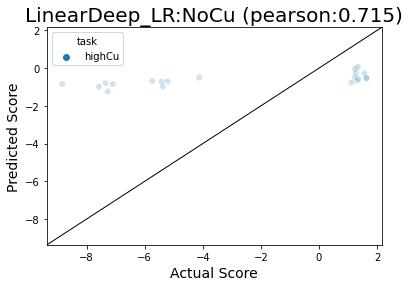

In [33]:
models = [
    ("LinearDeep_LR:NoCu",best_lin,DatasetSpec('ohe')),
    #("CNN_8mer",mer8motif_model_cnn),
]

genes = XYdf_smol['locus_tag'].values
task = "opt_best_LR:NoCu"

dfs = parity_pred_multi(models, genes, oracle_nocu,task,['highCu'],alt=False)

In [34]:
pmoc = 'EQU24_RS19315'
pmoc_seq = loc2seq[pmoc]
pmoc_seq_ohe = torch.tensor(u.one_hot_encode(pmoc_seq)).unsqueeze(0).to(DEVICE).float()

print("pmoC pred:",best_lin(pmoc_seq_ohe).item())
print("pmoC actu:", oracle_nocu[pmoc][0])

pmoC pred: -0.7476934194564819
pmoC actu: 0.9095671757666924


## Optuna: CNN Trial

In [75]:
class DNA_CNN_Opt(nn.Module):
    def __init__(self,
                 trial,
                 seq_len,
                ):
        super().__init__()
        self.seq_len = seq_len
        layers = []
        
        # +---------------------+
        # | First Conv Layer (0)|
        # +---------------------+
        conv0_filt_num = trial.suggest_categorical('conv0_filt_num', [16,32,64])
        conv0_kernel_size = trial.suggest_int('conv0_kernel_size',6,24)
        conv0_pool_size = trial.suggest_int('conv0_pool_size',1,3)
        conv0_dropout = trial.suggest_categorical('conv0_dropout',[0,0.1,0.2,0.3])
        
        print("conv0_filt_num", conv0_filt_num)
        print("conv0_kernel_size", conv0_kernel_size)
        print("conv0_pool_size", conv0_pool_size)
        
        linear_node_num = int(np.floor((seq_len - conv0_kernel_size + 1)/conv0_pool_size))
        print("current linear_node_num:",linear_node_num )
        
        layers.append(nn.Conv2d(1, conv0_filt_num, kernel_size=(4,conv0_kernel_size)))
        #layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d((1,conv0_pool_size))) # def stride = kernel_size
        layers.append(nn.Dropout(conv0_dropout))

        
        # +-----------------------+
        # | Hidden Conv Layers (N)|
        # +-----------------------+
        n_hidden_conv = trial.suggest_int('n_hidden_conv',0,1)
        print("hidden conv layers:", n_hidden_conv)
        prev_conv_filt_num = conv0_filt_num
        
        # for each hidden convolutional layer
        for i in range(1,n_hidden_conv+1):
            # Trial Suggestions
            convi_filt_num = trial.suggest_categorical(f'conv{i}_filt_num', [16,32,64])
            convi_kernel_size = trial.suggest_int(f'conv{i}_kernel_size',1,6)
            convi_pool_size = trial.suggest_int(f'conv{i}_pool_size',1,3)
            convi_dropout = trial.suggest_categorical(f'conv{i}_dropout',[0,0.1,0.2,0.3])
            
            print(f"conv{i}_filt_num", convi_filt_num)
            print(f"conv{i}_kernel_size", convi_kernel_size)
            print(f"conv{i}_pool_size", convi_pool_size)
            print(f"conv{i}_dropout", convi_dropout)
            
            # Layer additions
            layers.append(nn.Conv2d(prev_conv_filt_num, convi_filt_num, kernel_size=(1,convi_kernel_size)))
            #layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d((1,convi_pool_size)))
            layers.append(nn.Dropout(convi_dropout))
            
            # value updates
            linear_node_num = int(np.floor((linear_node_num - convi_kernel_size + 1)/convi_pool_size))
            print("current linear_node_num:",linear_node_num )
            prev_conv_filt_num = convi_filt_num
        
        # flatten the conv layers pre FC layer
        layers.append(nn.Flatten())
        
        # +---------------------+
        # | Hidden FC Layers (N)|
        # +---------------------+
        n_hidden_fc = trial.suggest_int('n_hidden_fc',0,2)
        print("n fc layers:", n_hidden_fc)
        
        prev_linear_node_num = linear_node_num*prev_conv_filt_num
        print("From Conv-to-FC node num:",prev_linear_node_num)
        
        for i in range(1, n_hidden_fc+1):
            # Trial suggestions
            lini_fc_nodes = trial.suggest_categorical(f'lin{i}_fc_nodes',[8,16,32,64,128])
            lini_dropout = trial.suggest_categorical(f'lin{i}_dropout',[0,0.1,0.2,0.3])
            
            print(f"lin{i}_fc_nodes", lini_fc_nodes)
            print(f"lin{i}_dropout", lini_dropout)
            
            # Layer additions
            layers.append(nn.Linear(prev_linear_node_num, lini_fc_nodes))
            #layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(lini_dropout))
            
            # value updates
            prev_linear_node_num = lini_fc_nodes
            print("current linear_node_num:",prev_linear_node_num )
        
        # Add final prediction layer
        layers.append(nn.Linear(prev_linear_node_num, 1))
            
        # concat all the layers together
        self.conv_net = nn.Sequential(*layers)
            


    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

In [76]:
print("seq len", seq_len)
eps=50
loss_func = torch.nn.MSELoss()
lr = 0.001

cnn_ow = OptWrap(
    "DNA_CNN_Opt",
    DNA_CNN_Opt,
    seq_len,
    eps,
    loss_func,
    lr,
    ohe_train_dl, 
    ohe_val_dl
)

cnn_opt_study = optuna.create_study(direction="minimize")

cnn_opt_study.optimize(cnn_ow.optimize, n_trials=2000)

print_study(cnn_opt_study)

[I 2021-10-12 19:11:15,353] A new study created in memory with name: no-name-7f36795a-56dc-4e67-a3d1-3e07e0837b6c


seq len 300
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 18752
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64
E0: 0.9787108497619629
E1: 0.9779612126350403
E2: 0.9748207874298096
E3: 0.975863028049469
E4: 0.976414514541626
E5: 0.9834915041923523
E6: 0.9844445123672485
E7: 0.97751797914505
E8: 0.977177698135376
E9: 0.9782083601951599
E10: 0.9776774430274964
E11: 0.9784361848831177
E12: 0.9779631137847901
E13: 0.977870044708252
E14: 0.9777213206291199
E15: 0.9781460399627686
E16: 0.9786370697021485
E17: 0.9781509943008423
E18: 0.9821560382843018
E19: 0.9778496322631836
E20: 0.9778035984039307
E21: 0.9777267227172851
E22: 0.9779194803237915
E23: 0.9783505110740661
E24: 0.9776439037322998
E25: 0.9780104937553405
E26: 0.9775261077880859
E27: 0.9780880317687989
E28: 0.9777215051651001
E29: 0.9781182603836059
E30: 0.9779172039031983
E31: 0.9778281316757202
E32: 0.9779299659729

[I 2021-10-12 19:12:35,690] Trial 0 finished with value: 0.9788611655235291 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 8, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.2}. Best is trial 0 with value: 0.9788611655235291.


E49: 0.9788611655235291
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 8), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=18752, out_features=64, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4672
E0: 0.991563148021698
E1: 0.9819443845748901
E2: 0.9791538186073303
E3: 0.9777143068313598
E4: 0.9839429922103882
E5: 0.9725508522987366
E6: 0.9768106999397278
E7: 0.9711698265075683
E8: 0.9704963760375976
E9: 0.9706343693733215
E10: 0.9695310850143433
E11: 0.9709485502243042
E12: 0.9695593671798706
E13: 0.9726899194717408
E14: 0.967174354076

[I 2021-10-12 19:13:40,917] Trial 1 finished with value: 0.9530721368789673 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 8, 'conv0_pool_size': 2, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 1 with value: 0.9530721368789673.


E49: 0.9530721368789673
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=4672, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 94
n fc layers: 2
From Conv-to-FC node num: 6016
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32
lin2_fc_nodes 8
lin2_dropout 0.2
current linear_node_num: 8
E0: 0.9937574687004089
E1: 0.993496036529541
E2: 0.9931636357307434
E3: 0.9930123410224915
E4: 0.992480842590332
E5: 0.9921382894515991
E6: 0.9917117185592651
E7: 0.9913411927223206
E8: 0.9909916620254516
E9: 0.990342310

[I 2021-10-12 19:15:08,412] Trial 2 finished with value: 0.956504047870636 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 10, 'conv0_pool_size': 3, 'conv0_dropout': 0, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 4, 'conv1_pool_size': 1, 'conv1_dropout': 0.3, 'n_hidden_fc': 2, 'lin1_fc_nodes': 32, 'lin1_dropout': 0.1, 'lin2_fc_nodes': 8, 'lin2_dropout': 0.2}. Best is trial 1 with value: 0.9530721368789673.


E49: 0.956504047870636
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(1, 4), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6016, out_features=32, bias=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=32, out_features=8, bias=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=8, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 1
current linear_node_num: 277
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 8864
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num

[I 2021-10-12 19:16:21,512] Trial 3 finished with value: 0.9787280530929565 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 24, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 2, 'lin1_fc_nodes': 64, 'lin1_dropout': 0, 'lin2_fc_nodes': 16, 'lin2_dropout': 0}. Best is trial 1 with value: 0.9530721368789673.


E49: 0.9787280530929565
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 24), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=8864, out_features=64, bias=True)
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): Dropout(p=0, inplace=False)
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 23
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 5888
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8
E0: 0.9912506666183472
E1: 0.986218008518219
E2: 0.9825253829956054
E3: 0.9786835737228393
E4: 0.9768583741188049
E5: 0.973982590675354
E6: 0.9728282208442688
E7: 0.9718065323829651
E8: 0.970

[I 2021-10-12 19:17:34,493] Trial 4 finished with value: 0.9615353512763977 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 23, 'conv0_pool_size': 3, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 1, 'lin1_fc_nodes': 8, 'lin1_dropout': 0}. Best is trial 1 with value: 0.9530721368789673.


E49: 0.9615353512763977
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 23), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=5888, out_features=8, bias=True)
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 16
conv0_kernel_size 21
conv0_pool_size 1
current linear_node_num: 280
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 275
n fc layers: 1
From Conv-to-FC node num: 4400
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64


[I 2021-10-12 19:17:36,137] Trial 5 pruned. 


E0: 0.9972458295822143
conv0_filt_num 32
conv0_kernel_size 23
conv0_pool_size 1
current linear_node_num: 278
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 6
conv1_pool_size 3
conv1_dropout 0.1
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 1456


[I 2021-10-12 19:17:37,744] Trial 6 pruned. 


E0: 0.996916563987732
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 3040
lin1_fc_nodes 128
lin1_dropout 0.1
current linear_node_num: 128
lin2_fc_nodes 128
lin2_dropout 0
current linear_node_num: 128


[I 2021-10-12 19:17:39,217] Trial 7 pruned. 


E0: 0.9945437912940979
conv0_filt_num 16
conv0_kernel_size 6
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 6
conv1_pool_size 3
conv1_dropout 0.2
current linear_node_num: 31
n fc layers: 1
From Conv-to-FC node num: 992
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32


[I 2021-10-12 19:17:40,862] Trial 8 pruned. 


E0: 0.9951495623588562
conv0_filt_num 16
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 4
conv1_pool_size 3
conv1_dropout 0.3
current linear_node_num: 47
n fc layers: 2
From Conv-to-FC node num: 1504
lin1_fc_nodes 16
lin1_dropout 0.3
current linear_node_num: 16
lin2_fc_nodes 64
lin2_dropout 0
current linear_node_num: 64


[I 2021-10-12 19:17:42,534] Trial 9 pruned. 


E0: 0.9949335689544678
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4608


[I 2021-10-12 19:17:43,824] Trial 10 pruned. 


E0: 0.9919416723251343
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9863135409355164
E1: 0.9811016302108765
E2: 0.973753276348114
E3: 0.9706378331184388
E4: 0.9726186532974244
E5: 0.9750082092285156
E6: 0.9673296999931336
E7: 0.9667447714805603
E8: 0.9665622310638428
E9: 0.9673834586143494
E10: 0.965462155342102
E11: 0.9696182632446289
E12: 0.9697945489883423
E13: 0.9677793941497803
E14: 0.9632513899803161
E15: 0.9632237939834595
E16: 0.9710729918479919
E17: 0.9619319286346436
E18: 0.961142213344574
E19: 0.9602139692306518
E20: 0.9613800444602967
E21: 0.9607054085731507
E22: 0.9580715613365174
E23: 0.9576170291900635
E24: 0.9727298488616943
E25: 0.9585108060836792
E26: 0.9581183347702026
E27: 0.9548648223876953
E28: 0.9592158865928649
E29: 0.9593195638656616
E30: 0.954591

[I 2021-10-12 19:19:02,901] Trial 11 finished with value: 0.9533835015296936 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 12, 'conv0_pool_size': 2, 'conv0_dropout': 0, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 1, 'conv1_pool_size': 1, 'conv1_dropout': 0.3, 'n_hidden_fc': 0}. Best is trial 1 with value: 0.9530721368789673.


E49: 0.9533835015296936
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 12), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4608
E0: 0.9877748680114746


[I 2021-10-12 19:19:05,359] Trial 12 pruned. 


E1: 0.9906686658859253
conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.989814425945282
E1: 0.9820664210319519
E2: 0.9775270438194275
E3: 0.973361123085022
E4: 0.9870933017730713
E5: 0.9711020221710205
E6: 0.9698458223342895
E7: 0.971510555267334
E8: 0.9691673202514648
E9: 0.971492769241333
E10: 0.9720133624076843
E11: 0.98256467628479
E12: 0.9681843371391297
E13: 0.9701048893928528
E14: 0.9796465272903443
E15: 0.9658846044540406
E16: 0.9671232395172119
E17: 0.9654827060699462
E18: 0.9643704948425293
E19: 0.9655280351638794
E20: 0.9630579342842102
E21: 0.9625660285949708
E22: 0.9623343238830566
E23: 0.9612905459403992
E24: 0.9606038274765014
E25: 0.960961989402771
E26: 0.9602672004699707
E27: 0.9613636860847473
E28: 0.9596308999061585
E29: 0.9635277371406555
E30: 0.958689073562

[I 2021-10-12 19:20:23,259] Trial 13 finished with value: 0.9561096620559693 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 17, 'conv0_pool_size': 2, 'conv0_dropout': 0, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 1, 'conv1_pool_size': 1, 'conv1_dropout': 0, 'n_hidden_fc': 0}. Best is trial 1 with value: 0.9530721368789673.


E49: 0.9561096620559693
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 17), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9088, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4608


[I 2021-10-12 19:20:24,522] Trial 14 pruned. 


E0: 0.9921826462745666
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 2
conv1_dropout 0.3
current linear_node_num: 73
n fc layers: 0
From Conv-to-FC node num: 4672


[I 2021-10-12 19:20:26,201] Trial 15 pruned. 


E0: 0.9933299841880798
conv0_filt_num 32
conv0_kernel_size 18
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4512


[I 2021-10-12 19:20:27,490] Trial 16 pruned. 


E0: 0.9930575351715087
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 1
current linear_node_num: 290
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 144
n fc layers: 1
From Conv-to-FC node num: 9216
lin1_fc_nodes 16
lin1_dropout 0.3
current linear_node_num: 16


[I 2021-10-12 19:20:29,660] Trial 17 pruned. 


E0: 0.9922236738204956
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952
E0: 0.9850949139595032
E1: 0.9780496854782105
E2: 0.9749418821334839
E3: 0.9708749132156372
E4: 0.9676754784584045
E5: 0.9663995432853699
E6: 0.9694548873901367
E7: 0.9649962787628173
E8: 0.9648789930343628
E9: 0.9637872171401978
E10: 0.963474627494812
E11: 0.9639798393249511
E12: 0.9624332776069641
E13: 0.9617796669006348
E14: 0.9645275440216065
E15: 0.9606767482757569
E16: 0.9609580674171447
E17: 0.9594568586349488
E18: 0.958955735206604
E19: 0.9595754737854004
E20: 0.9669626216888427
E21: 0.957331494808197
E22: 0.9567247610092163
E23: 0.9561880435943604
E24: 0.9556617460250855
E25: 0.956819016456604
E26: 0.9547393960952759
E27: 0.954110013961792
E28: 0.9568891925811768
E29: 0.9529663801193238
E30: 0.9568503112

[I 2021-10-12 19:21:58,080] Trial 18 finished with value: 0.9453006315231324 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 14, 'conv0_pool_size': 3, 'conv0_dropout': 0.2, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 3, 'conv1_pool_size': 1, 'conv1_dropout': 0.2, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.9453006315231324
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 14), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=5952, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 19
conv0_pool_size 3
current linear_node_num: 94
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 6016
lin1_fc_nodes 8
lin1_dropout 0.3
current linear_node_num: 8


[I 2021-10-12 19:21:59,566] Trial 19 pruned. 


E0: 0.9953034887313843
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6080
E0: 0.9843176937103272
E1: 0.9756046295166015
E2: 0.973413948059082
E3: 0.9801663036346435
E4: 0.9706473550796508
E5: 0.9768067512512207
E6: 0.9695390863418579
E7: 0.972314642906189
E8: 0.9789703640937805
E9: 0.9671929545402527
E10: 0.9701792058944703
E11: 0.9781002445220948
E12: 1.006194610118866
E13: 0.9701931343078614
E14: 0.9670184020996093
E15: 0.9638796210289001
E16: 0.9634748239517212
E17: 0.9644943580627442
E18: 0.9625127120018006
E19: 0.9612691345214843
E20: 0.9607533521652222
E21: 0.9676920561790466
E22: 0.966147027015686
E23: 0.9616479511260987
E24: 0.9619177222251892
E25: 0.9634172468185425
E26: 0.9588058586120606
E27: 0.9611446237564087
E28: 0.959358346939087
E29: 0.9576033344268798
E30: 0.9602549781799317
E31: 0.956535819530487
E32: 0.9564753561019897
E33: 0.956195876121521
E34: 0.9814275441169739
E

[I 2021-10-12 19:23:07,060] Trial 20 finished with value: 0.9560212826728821 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 15, 'conv0_pool_size': 3, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.9560212826728821
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 15), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=6080, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024
E0: 0.9880355377197265
E1: 0.9815702857971191
E2: 0.9733304624557495
E3: 0.9701725449562073
E4: 0.9716445446014405
E5: 0.9677359404563903
E6: 0.9743838052749634
E7: 0.9681529021263122
E8: 0.9655595755577088
E9: 0.9650805435180664
E10: 0.9697295451164245
E11: 0.9646314611434936
E12: 0.963164132118225
E13: 0.963150839805603
E14: 0.96933461

[I 2021-10-12 19:24:40,071] Trial 21 finished with value: 0.9478032817840576 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 15, 'conv0_pool_size': 2, 'conv0_dropout': 0.2, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 3, 'conv1_pool_size': 1, 'conv1_dropout': 0.2, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.9478032817840576
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 15), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9024, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 2
conv1_dropout 0.2
current linear_node_num: 70
n fc layers: 0
From Conv-to-FC node num: 4480


[I 2021-10-12 19:24:41,942] Trial 22 pruned. 


E0: 0.9927696480751037
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 19:24:43,738] Trial 23 pruned. 


E0: 0.9928287534713746
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 19:24:45,583] Trial 24 pruned. 


E0: 0.9895043034553528
conv0_filt_num 64
conv0_kernel_size 20
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 2
conv1_dropout 0.2
current linear_node_num: 68
n fc layers: 0
From Conv-to-FC node num: 2176


[I 2021-10-12 19:26:07,559] Trial 25 pruned. 


E0: 0.9950318293571472
conv0_filt_num 64
conv0_kernel_size 17
conv0_pool_size 3
current linear_node_num: 94
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 93
n fc layers: 1
From Conv-to-FC node num: 1488
lin1_fc_nodes 128
lin1_dropout 0.2
current linear_node_num: 128


[I 2021-10-12 19:26:09,560] Trial 26 pruned. 


E0: 0.9946636619567871
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 2
conv1_dropout 0.2
current linear_node_num: 72
n fc layers: 0
From Conv-to-FC node num: 4608


[I 2021-10-12 19:26:11,081] Trial 27 pruned. 


E0: 0.9923961715698242
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6080
E0: 0.9870725593566895


[I 2021-10-12 19:26:13,768] Trial 28 pruned. 


E1: 0.9822890048027039
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 291
n fc layers: 1
From Conv-to-FC node num: 18624
lin1_fc_nodes 128
lin1_dropout 0
current linear_node_num: 128


[I 2021-10-12 19:26:16,794] Trial 29 pruned. 


E0: 0.991181960105896
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 18752
lin1_fc_nodes 8
lin1_dropout 0.1
current linear_node_num: 8


[I 2021-10-12 19:26:18,342] Trial 30 pruned. 


E0: 0.9906620755195618
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 19:26:19,959] Trial 31 pruned. 


E0: 0.9895637130737305
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 19:26:21,576] Trial 32 pruned. 


E0: 1.0002113251686096
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024
E0: 0.9855902333259583
E1: 0.9739123411178588
E2: 0.9675221152305603
E3: 0.9647854685783386
E4: 0.9695264415740967
E5: 0.9652294445037842
E6: 0.962653398513794
E7: 0.9641714134216308
E8: 0.9651471195220948
E9: 0.9616198225021362
E10: 0.961840343952179
E11: 0.9617827181816101
E12: 0.9612562003135681
E13: 0.9611468162536622
E14: 0.959516863822937
E15: 0.9590347356796265
E16: 0.9582941317558289
E17: 0.9589195237159729
E18: 0.9588529334068299
E19: 0.9609691791534424
E20: 0.9666485433578491
E21: 0.957294337272644
E22: 0.9575968623161316
E23: 0.9551779680252075
E24: 0.9576980404853821
E25: 0.955761568069458
E26: 0.9579039545059204
E27: 0.9555280351638794
E28: 0.9563638019561768
E29: 0.9534104189872742
E30: 0.9520189881

[I 2021-10-12 19:27:41,877] Trial 33 finished with value: 0.9471883802413941 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 11, 'conv0_pool_size': 2, 'conv0_dropout': 0.2, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 5, 'conv1_pool_size': 1, 'conv1_dropout': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.9471883802413941
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 11), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(1, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9024, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.9833566646575927
E1: 0.9759297528266907
E2: 0.9699612169265747
E3: 0.968393814086914
E4: 0.9665551404953003
E5: 0.9656601266860962
E6: 0.965624305

[I 2021-10-12 19:29:02,196] Trial 34 finished with value: 0.9503535747528076 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 9, 'conv0_pool_size': 2, 'conv0_dropout': 0.2, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 5, 'conv1_pool_size': 1, 'conv1_dropout': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.9503535747528076
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 9), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(1, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9088, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024
E0: 0.9846787281036377
E1: 0.9769724597930908


[I 2021-10-12 19:34:35,352] Trial 35 pruned. 


E2: 0.9806200113296509
conv0_filt_num 16
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.9864860215187072
E1: 0.9810914626121521


[I 2021-10-12 19:34:39,863] Trial 36 pruned. 


E2: 0.9755421242713929
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896
E0: 0.9853259997367859
E1: 0.9764819316864014
E2: 0.970339204788208
E3: 0.968002516746521
E4: 0.9655819959640503
E5: 0.969222225189209
E6: 0.9652201800346375
E7: 0.9639591279029847
E8: 0.9637168159484863
E9: 0.9627497625350953
E10: 0.9631128664016724
E11: 0.9613475351333618
E12: 0.9605391116142273
E16: 0.9586089572906494
E17: 0.960325704574585
E18: 0.9581266808509826
E19: 0.9618937377929687
E20: 0.9564696326255798
E21: 0.9597880034446716
E22: 0.9613317813873291
E23: 0.9548243412971497
E24: 0.9551027150154113
E25: 0.9544800796508789
E26: 0.9541186437606811
E27: 0.9534100751876831
E28: 0.9530187888145447
E29: 0.9524987869262695
E30: 0.9541992540359497
E31: 0.9548229732513428
E32: 0.9570679564476013
E33: 0.954084811

[I 2021-10-12 19:37:30,840] Trial 48 finished with value: 0.9496707282066346 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 14, 'conv0_pool_size': 2, 'conv0_dropout': 0.2, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 4, 'conv1_pool_size': 1, 'conv1_dropout': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.9496707282066346
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 14), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(16, 64, kernel_size=(1, 4), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=8960, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 16
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 92
n fc layers: 1
From Conv-to-FC node num: 2944
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64


[I 2021-10-12 19:37:32,491] Trial 49 pruned. 


E0: 0.994128761291504
conv0_filt_num 16
conv0_kernel_size 18
conv0_pool_size 1
current linear_node_num: 283
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 3
conv1_dropout 0.1
current linear_node_num: 93
n fc layers: 2
From Conv-to-FC node num: 5952
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32
lin2_fc_nodes 8
lin2_dropout 0.1
current linear_node_num: 8


[I 2021-10-12 19:37:34,428] Trial 50 pruned. 


E0: 0.9933968420028687
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896
E0: 0.9848047065734863
E1: 0.9780471591949463
E2: 0.9706128449440002
E3: 0.9682966995239258
E4: 0.9686973543167114
E5: 0.9719747924804687
E6: 0.964484712600708
E7: 0.9662031307220459
E8: 0.9775378618240357
E9: 0.9636272296905518
E10: 0.9625152845382691
E11: 0.967955677986145
E12: 0.9615599226951599
E13: 0.9635670862197876
E14: 0.9606767749786377
E15: 0.9600330214500428
E16: 0.9597872037887574
E17: 0.9599812545776367
E18: 0.9683218040466308
E19: 0.9585132069587707
E20: 0.9612265481948853
E21: 0.9581604580879212
E22: 0.9572559719085694
E23: 0.9578218235969543
E24: 0.956648072719574
E25: 0.9650328373908996
E26: 0.9588959922790528
E27: 0.9555966901779175
E28: 0.9593701381683349
E29: 0.9552062721252441
E30: 0.95543973

[I 2021-10-12 19:38:30,218] Trial 51 pruned. 


E36: 0.9541777038574218
conv0_filt_num 16
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 19:38:31,749] Trial 52 pruned. 


E0: 0.9898933973312378
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 19:38:33,354] Trial 53 pruned. 


E0: 0.9912494258880615
conv0_filt_num 16
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 19:38:34,876] Trial 54 pruned. 


E0: 0.9935139374732971
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.982560359954834
E1: 0.9758020706176758
E2: 0.9710424003601075
E3: 0.9734637451171875
E4: 0.9854439120292664
E5: 0.9697358474731446


[I 2021-10-12 19:38:45,998] Trial 55 pruned. 


E6: 0.9708447561264039
conv0_filt_num 64
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 2208


[I 2021-10-12 19:39:45,502] Trial 56 pruned. 


E0: 0.9966012859344482
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 19:39:47,244] Trial 57 pruned. 


E0: 0.9907585039138794
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 2
conv1_dropout 0.2
current linear_node_num: 70
n fc layers: 0
From Conv-to-FC node num: 4480


[I 2021-10-12 19:41:38,416] Trial 58 pruned. 


E0: 0.9885249695777893
conv0_filt_num 16
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 4
conv1_pool_size 3
conv1_dropout 0
current linear_node_num: 47
n fc layers: 0
From Conv-to-FC node num: 1504


[I 2021-10-12 19:41:39,868] Trial 59 pruned. 


E0: 0.9935524120330811
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 2
conv1_dropout 0.2
current linear_node_num: 47
n fc layers: 0
From Conv-to-FC node num: 3008


[I 2021-10-12 19:41:41,626] Trial 60 pruned. 


E0: 0.9956700925827027
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4704


[I 2021-10-12 19:41:42,919] Trial 61 pruned. 


E0: 0.9993446779251098
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4416


[I 2021-10-12 19:41:44,208] Trial 62 pruned. 


E0: 0.9865545063018799
conv0_filt_num 32
conv0_kernel_size 22
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4448


[I 2021-10-12 19:41:45,508] Trial 63 pruned. 


E0: 0.9894941453933715
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 19:41:47,148] Trial 64 pruned. 


E0: 0.9874397521018982
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4704


[I 2021-10-12 19:41:48,411] Trial 65 pruned. 


E0: 0.9932864308357239
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 19:43:39,498] Trial 66 pruned. 


E0: 1.0029729619026184
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 19:43:41,140] Trial 67 pruned. 


E0: 0.9948925523757934
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 1488


[I 2021-10-12 19:43:42,905] Trial 68 pruned. 


E0: 0.996180890083313
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 4544
lin1_fc_nodes 8
lin1_dropout 0.3
current linear_node_num: 8


[I 2021-10-12 19:43:44,310] Trial 69 pruned. 


E0: 0.995994891166687
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 2
conv1_dropout 0.2
current linear_node_num: 71
n fc layers: 0
From Conv-to-FC node num: 4544


[I 2021-10-12 19:43:46,119] Trial 70 pruned. 


E0: 1.0000596370697021
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 19:43:47,751] Trial 71 pruned. 


E0: 0.986780258178711
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 19:43:49,365] Trial 72 pruned. 


E0: 0.9859601383209229
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 19:43:50,961] Trial 73 pruned. 


E0: 0.9958685746192932
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960
E0: 0.9845597271919251
E1: 0.9763850622177124
E2: 0.970610068321228
E3: 0.9682294692993164
E4: 0.9729946527481079
E5: 0.9662573471069336
E6: 0.9659019947052002
E7: 0.9659013228416443
E8: 0.9672896604537964
E9: 0.9656949348449707
E10: 0.9654129524230957
E11: 0.9691314463615417
E12: 0.9692628960609436
E13: 0.9641019239425659
E14: 0.963695137500763


[I 2021-10-12 19:44:16,593] Trial 74 pruned. 


E15: 0.964828088760376
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 4576


[I 2021-10-12 19:44:18,131] Trial 75 pruned. 


E0: 0.9901002926826477
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 19:44:19,659] Trial 76 pruned. 


E0: 0.9878783521652221
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 19:44:21,496] Trial 77 pruned. 


E0: 0.9949797468185425
conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 138
n fc layers: 1
From Conv-to-FC node num: 8832
lin1_fc_nodes 16
lin1_dropout 0.2
current linear_node_num: 16


[I 2021-10-12 19:44:23,267] Trial 78 pruned. 


E0: 0.991247902393341
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 290
n fc layers: 0
From Conv-to-FC node num: 18560
E0: 0.9772666563987732
E1: 0.9741638436317444
E2: 0.9786708288192749


[I 2021-10-12 19:44:31,964] Trial 79 pruned. 


E3: 0.9786489219665527
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 96
n fc layers: 0
From Conv-to-FC node num: 6144


[I 2021-10-12 19:44:33,663] Trial 80 pruned. 


E0: 0.9887879467010499
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6080


[I 2021-10-12 19:44:35,021] Trial 81 pruned. 


E0: 0.988958505153656
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6080


[I 2021-10-12 19:44:36,379] Trial 82 pruned. 


E0: 0.9884468903541564
conv0_filt_num 64
conv0_kernel_size 18
conv0_pool_size 3
current linear_node_num: 94
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6016


[I 2021-10-12 19:44:37,758] Trial 83 pruned. 


E0: 0.9882615180015564
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6080


[I 2021-10-12 19:44:39,116] Trial 84 pruned. 


E0: 0.9905680327415466
conv0_filt_num 16
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2304


[I 2021-10-12 19:44:40,397] Trial 85 pruned. 


E0: 1.0020526733398438
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4544


[I 2021-10-12 19:44:41,692] Trial 86 pruned. 


E0: 0.9873512182235717
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 94
n fc layers: 0
From Conv-to-FC node num: 6016


[I 2021-10-12 19:45:14,850] Trial 87 pruned. 


E0: 0.9904813203811645
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 2
conv1_pool_size 2
conv1_dropout 0.3
current linear_node_num: 71
n fc layers: 0
From Conv-to-FC node num: 1136


[I 2021-10-12 19:45:16,395] Trial 88 pruned. 


E0: 0.9959416017532349
conv0_filt_num 16
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 4448


[I 2021-10-12 19:45:17,855] Trial 89 pruned. 


E0: 0.9946225023269654
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 3
conv1_dropout 0.1
current linear_node_num: 48
n fc layers: 0
From Conv-to-FC node num: 3072


[I 2021-10-12 19:45:19,670] Trial 90 pruned. 


E0: 0.9940280270576477
conv0_filt_num 32
conv0_kernel_size 19
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 19:45:21,236] Trial 91 pruned. 


E0: 0.988216700553894
conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 19:45:22,797] Trial 92 pruned. 


E0: 0.9902461862564087
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 0.9852658519744873


[I 2021-10-12 19:45:25,903] Trial 93 pruned. 


E1: 0.9865080728530884
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 19:45:27,489] Trial 94 pruned. 


E0: 0.9868281202316285
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 19:45:29,076] Trial 95 pruned. 


E0: 0.9908719663619995
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 19:45:30,826] Trial 96 pruned. 


E0: 0.986127420425415
conv0_filt_num 16
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2272


[I 2021-10-12 19:45:32,074] Trial 97 pruned. 


E0: 0.9981755313873291
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 19:47:23,638] Trial 98 pruned. 


E0: 0.9901114664077759
conv0_filt_num 32
conv0_kernel_size 19
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 136
n fc layers: 2
From Conv-to-FC node num: 8704
lin1_fc_nodes 128
lin1_dropout 0
current linear_node_num: 128
lin2_fc_nodes 64
lin2_dropout 0.3
current linear_node_num: 64


[I 2021-10-12 19:47:25,567] Trial 99 pruned. 


E0: 0.9943085265159607
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 19:47:27,087] Trial 100 pruned. 


E0: 0.9933121185302735
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 94
n fc layers: 2
From Conv-to-FC node num: 6016
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32
lin2_fc_nodes 8
lin2_dropout 0.2
current linear_node_num: 8


[I 2021-10-12 19:47:28,848] Trial 101 pruned. 


E0: 0.9944892468452453
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 94
n fc layers: 2
From Conv-to-FC node num: 6016
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32
lin2_fc_nodes 8
lin2_dropout 0.2
current linear_node_num: 8


[I 2021-10-12 19:47:30,609] Trial 102 pruned. 


E0: 0.9951252498626709
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 94
n fc layers: 1
From Conv-to-FC node num: 6016
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32


[I 2021-10-12 19:47:32,276] Trial 103 pruned. 


E0: 0.9934350953102112
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 1472


[I 2021-10-12 19:47:33,798] Trial 104 pruned. 


E0: 0.9946110887527466
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 141
n fc layers: 1
From Conv-to-FC node num: 9024
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32


[I 2021-10-12 19:47:35,583] Trial 105 pruned. 


E0: 0.9901231846809387
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 2
From Conv-to-FC node num: 4544
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32
lin2_fc_nodes 16
lin2_dropout 0.2
current linear_node_num: 16


[I 2021-10-12 19:47:37,536] Trial 106 pruned. 


E0: 0.9950336017608643
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3072


[I 2021-10-12 19:47:38,795] Trial 107 pruned. 


E0: 1.000173680782318
conv0_filt_num 16
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896
E0: 0.9848597383499146
E1: 0.9781607365608216
E2: 0.9726914143562317


[I 2021-10-12 19:47:44,815] Trial 108 pruned. 


E3: 0.9731829662322998
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 19:47:46,619] Trial 109 pruned. 


E0: 0.9927033410072327
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 1
From Conv-to-FC node num: 8960
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32


[I 2021-10-12 19:47:48,371] Trial 110 pruned. 


E0: 0.9931110992431641
conv0_filt_num 64
conv0_kernel_size 21
conv0_pool_size 3
current linear_node_num: 93
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 5952
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8
lin2_fc_nodes 128
lin2_dropout 0.1
current linear_node_num: 128


[I 2021-10-12 19:47:49,912] Trial 111 pruned. 


E0: 0.993893967628479
conv0_filt_num 64
conv0_kernel_size 21
conv0_pool_size 3
current linear_node_num: 93
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 5952
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8


[I 2021-10-12 19:47:51,514] Trial 112 pruned. 


E0: 0.9924187188148499
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208
E0: 0.9798252744674683
E1: 0.9736743993759155
E2: 1.0027103443145753
E3: 0.969398253440857
E4: 0.9679056963920594
E5: 0.976375563621521
E6: 0.9667965636253357
E7: 0.9658501558303833
E8: 0.9698078951835633
E9: 0.9771552724838257
E10: 0.976383668422699
E11: 0.9630890617370605
E12: 0.9721752648353577
E13: 0.9622221555709839
E14: 0.9627924661636352
E15: 0.9661600484848022
E16: 0.9600726895332337
E17: 0.9595327072143555
E18: 0.9610779757499694
E19: 0.9602645177841187
E20: 0.9660748357772827
E21: 0.9613945503234863
E22: 0.9579944620132447
E23: 0.9597089109420777
E24: 1.0046285390853882
E25: 0.9584621267318726
E26: 0.9587075171470643
E27: 0.9669147214889526
E28: 0.9635419631004334


[I 2021-10-12 19:48:31,792] Trial 113 pruned. 


E29: 0.9586741061210632
conv0_filt_num 64
conv0_kernel_size 23
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 19:48:33,156] Trial 114 pruned. 


E0: 1.0291373257637024
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-12 19:48:34,494] Trial 115 pruned. 


E0: 0.9871660184860229
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 4640
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8
lin2_fc_nodes 32
lin2_dropout 0.2
current linear_node_num: 32


[I 2021-10-12 19:48:35,997] Trial 116 pruned. 


E0: 0.9946091871261596
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 94
n fc layers: 1
From Conv-to-FC node num: 6016
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8


[I 2021-10-12 19:48:37,673] Trial 117 pruned. 


E0: 0.9932926883697509
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 69
n fc layers: 0
From Conv-to-FC node num: 4416


[I 2021-10-12 19:48:39,182] Trial 118 pruned. 


E0: 0.990986125946045
conv0_filt_num 64
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 136
n fc layers: 0
From Conv-to-FC node num: 8704


[I 2021-10-12 19:48:41,036] Trial 119 pruned. 


E0: 0.9885802059173584
conv0_filt_num 32
conv0_kernel_size 22
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4448


[I 2021-10-12 19:48:42,301] Trial 120 pruned. 


E0: 0.9895075550079345
conv0_filt_num 32
conv0_kernel_size 23
conv0_pool_size 1
current linear_node_num: 278
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 8896
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
lin2_fc_nodes 16
lin2_dropout 0
current linear_node_num: 16


[I 2021-10-12 19:48:43,780] Trial 121 pruned. 


E0: 0.9939282526969909
conv0_filt_num 32
conv0_kernel_size 23
conv0_pool_size 1
current linear_node_num: 278
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 8896
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
lin2_fc_nodes 16
lin2_dropout 0
current linear_node_num: 16


[I 2021-10-12 19:48:45,276] Trial 122 pruned. 


E0: 0.9909770669937134
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 1
current linear_node_num: 287
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 9184
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
lin2_fc_nodes 16
lin2_dropout 0.2
current linear_node_num: 16


[I 2021-10-12 19:48:46,925] Trial 123 pruned. 


E0: 0.9946536293029785
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 1
current linear_node_num: 277
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 8864
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
lin2_fc_nodes 8
lin2_dropout 0
current linear_node_num: 8


[I 2021-10-12 19:48:48,391] Trial 124 pruned. 


E0: 0.9955649871826172
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 1472


[I 2021-10-12 19:48:49,918] Trial 125 pruned. 


E0: 0.9947907800674438
conv0_filt_num 64
conv0_kernel_size 22
conv0_pool_size 3
current linear_node_num: 93
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 5952
E0: 0.9843970041275024
E1: 0.9772080712318421


[I 2021-10-12 19:48:54,025] Trial 126 pruned. 


E2: 0.9743989629745483
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 146
n fc layers: 2
From Conv-to-FC node num: 9344
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64
lin2_fc_nodes 8
lin2_dropout 0.1
current linear_node_num: 8


[I 2021-10-12 19:48:55,904] Trial 127 pruned. 


E0: 0.9938442888259887
conv0_filt_num 16
conv0_kernel_size 20
conv0_pool_size 1
current linear_node_num: 281
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 276
n fc layers: 0
From Conv-to-FC node num: 8832
E0: 0.9809830327033997
E1: 0.9741672039031982
E2: 0.9727223291397095


[I 2021-10-12 19:49:01,941] Trial 128 pruned. 


E3: 0.9748200788497925
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4576


[I 2021-10-12 19:49:03,237] Trial 129 pruned. 


E0: 0.9922401533126831
conv0_filt_num 64
conv0_kernel_size 24
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 89
n fc layers: 0
From Conv-to-FC node num: 5696


[I 2021-10-12 19:49:05,074] Trial 130 pruned. 


E0: 0.9928952798843383
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 1
current linear_node_num: 295
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 18880
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64
E0: 0.9850287637710571


[I 2021-10-12 19:49:08,316] Trial 131 pruned. 


E1: 0.990634509563446
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 18752
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64
E0: 0.9856414213180542


[I 2021-10-12 19:49:11,567] Trial 132 pruned. 


E1: 0.98351460313797
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 18816
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64


[I 2021-10-12 19:49:13,203] Trial 133 pruned. 


E0: 0.9879000911712646
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 18816
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64


[I 2021-10-12 19:49:14,840] Trial 134 pruned. 


E0: 0.9876952548027038
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 3
conv1_dropout 0.1
current linear_node_num: 48
n fc layers: 1
From Conv-to-FC node num: 3072
lin1_fc_nodes 128
lin1_dropout 0.3
current linear_node_num: 128


[I 2021-10-12 19:49:16,710] Trial 135 pruned. 


E0: 0.9946649541854858
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 18624
lin1_fc_nodes 16
lin1_dropout 0
current linear_node_num: 16


[I 2021-10-12 19:49:18,281] Trial 136 pruned. 


E0: 0.9861530299186707
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.9821574864387512
E1: 0.9717632513046265
E2: 0.9682164030075073
E3: 0.9644641628265381
E4: 0.9626156883239746
E5: 0.9612342844009399
E6: 0.9608575043678284
E7: 0.962750072479248
E8: 0.9588487520217895
E9: 0.9617132711410522
E10: 0.9586240072250366
E11: 0.9566430993080139
E12: 0.9560906958580017
E13: 0.9561560611724853
E14: 0.9565768857002258
E15: 0.953821662902832
E16: 0.955915228843689
E17: 0.9585860347747803
E18: 0.9514071497917175
E19: 0.952652268409729
E20: 0.9502118005752563
E21: 0.9505005521774292
E22: 0.9516109333038331
E23: 0.9551857900619507
E24: 0.9504800109863282
E25: 0.950043378829956
E26: 0.9488785061836242
E27: 0.9485089268684387
E28: 0.9485292806625366
E29: 0.9498350677490235
E30: 0.949554687

[I 2021-10-12 19:50:40,098] Trial 137 finished with value: 0.9482323727607727 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 9, 'conv0_pool_size': 2, 'conv0_dropout': 0.2, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 5, 'conv1_pool_size': 1, 'conv1_dropout': 0.2, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.9482323727607727
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 9), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(1, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9088, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.9851154870986939


[I 2021-10-12 19:50:43,379] Trial 138 pruned. 


E1: 0.979331392288208
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 137
n fc layers: 0
From Conv-to-FC node num: 8768


[I 2021-10-12 19:50:45,038] Trial 139 pruned. 


E0: 0.9892392692565918
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 19:50:46,683] Trial 140 pruned. 


E0: 0.9939554743766784
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 19:50:48,320] Trial 141 pruned. 


E0: 0.9860482649803162
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.9816061630249023
E1: 0.9757261934280396
E2: 0.9694481682777405
E3: 0.9706365189552307
E4: 0.9680173978805542
E5: 0.9701561679840088
E6: 0.9675501871109009
E7: 0.9691734862327576


[I 2021-10-12 19:51:03,058] Trial 142 pruned. 


E8: 0.9760913081169128
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 19:51:04,701] Trial 143 pruned. 


E0: 0.98702698802948
conv0_filt_num 16
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 146
n fc layers: 0
From Conv-to-FC node num: 9344


[I 2021-10-12 19:51:06,263] Trial 144 pruned. 


E0: 1.0133136873245239
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 19:51:08,050] Trial 145 pruned. 


E0: 0.9880789785385132
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4672


[I 2021-10-12 19:51:09,355] Trial 146 pruned. 


E0: 0.9966848192214965
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 70
n fc layers: 1
From Conv-to-FC node num: 4480
lin1_fc_nodes 8
lin1_dropout 0.2
current linear_node_num: 8


[I 2021-10-12 19:51:11,098] Trial 147 pruned. 


E0: 0.9910491924285889
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 94
n fc layers: 0
From Conv-to-FC node num: 1504


[I 2021-10-12 19:51:12,855] Trial 148 pruned. 


E0: 0.9958888421058655
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4608


[I 2021-10-12 19:51:14,100] Trial 149 pruned. 


E0: 0.9917326002120972
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 2
From Conv-to-FC node num: 8960
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
lin2_fc_nodes 16
lin2_dropout 0.3
current linear_node_num: 16


[I 2021-10-12 19:53:05,025] Trial 150 pruned. 


E0: 0.9937131743431091
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 19:53:06,552] Trial 151 pruned. 


E0: 0.994656660079956
conv0_filt_num 16
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


[I 2021-10-12 19:53:08,084] Trial 152 pruned. 


E0: 0.995934754371643
conv0_filt_num 16
conv0_kernel_size 16
conv0_pool_size 1
current linear_node_num: 285
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 281
n fc layers: 0
From Conv-to-FC node num: 17984
E0: 0.9838798575401306


[I 2021-10-12 19:53:11,691] Trial 153 pruned. 


E1: 0.9790129961967469
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


[I 2021-10-12 19:53:13,357] Trial 154 pruned. 


E0: 0.9940665278434754
conv0_filt_num 16
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 8832


[I 2021-10-12 19:53:14,884] Trial 155 pruned. 


E0: 0.9922275304794311
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 4480


[I 2021-10-12 19:53:16,453] Trial 156 pruned. 


E0: 0.993986909866333
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4704


[I 2021-10-12 19:53:17,708] Trial 157 pruned. 


E0: 0.9923293838500976
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 97
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-12 19:53:19,407] Trial 158 pruned. 


E0: 0.9890822734832764
conv0_filt_num 16
conv0_kernel_size 18
conv0_pool_size 1
current linear_node_num: 283
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 279
n fc layers: 0
From Conv-to-FC node num: 17856
E0: 0.9841471948623657


[I 2021-10-12 19:53:23,204] Trial 159 pruned. 


E1: 0.9803108959197998
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 19:53:24,836] Trial 160 pruned. 


E0: 0.9902049617767334
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-12 19:53:26,193] Trial 161 pruned. 


E0: 0.9868188977241517
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208
E0: 0.9853378491401672


[I 2021-10-12 19:53:28,904] Trial 162 pruned. 


E1: 0.9939568004608155
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6144


[I 2021-10-12 19:53:30,272] Trial 163 pruned. 


E0: 1.003960807800293
conv0_filt_num 64
conv0_kernel_size 24
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 19:53:31,659] Trial 164 pruned. 


E0: 0.9969097080230713
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-12 19:53:33,029] Trial 165 pruned. 


E0: 0.9914481134414673
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6080


[I 2021-10-12 19:53:34,394] Trial 166 pruned. 


E0: 1.0013325142860412
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 4544
lin1_fc_nodes 128
lin1_dropout 0.3
current linear_node_num: 128
lin2_fc_nodes 64
lin2_dropout 0
current linear_node_num: 64


[I 2021-10-12 19:53:35,903] Trial 167 pruned. 


E0: 0.9945296554565429
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 95
n fc layers: 1
From Conv-to-FC node num: 6080
lin1_fc_nodes 16
lin1_dropout 0.1
current linear_node_num: 16


[I 2021-10-12 19:53:37,580] Trial 168 pruned. 


E0: 0.9944288697242737
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 19:53:38,944] Trial 169 pruned. 


E0: 0.9918062381744385
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 19:53:40,594] Trial 170 pruned. 


E0: 0.9857362174987793
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 19:53:42,217] Trial 171 pruned. 


E0: 0.9929017281532287
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 19:53:43,976] Trial 172 pruned. 


E0: 0.9863240814208984
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 19:53:45,608] Trial 173 pruned. 


E0: 0.9905067548751831
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 19:53:47,251] Trial 174 pruned. 


E0: 0.9981130328178406
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 19:53:48,889] Trial 175 pruned. 


E0: 0.985871919631958
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 19:55:39,868] Trial 176 pruned. 


E0: 0.9951045103073121
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 19:55:41,517] Trial 177 pruned. 


E0: 0.9944820652008056
conv0_filt_num 16
conv0_kernel_size 20
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2240


[I 2021-10-12 19:55:42,798] Trial 178 pruned. 


E0: 0.9969032239913941
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 2
From Conv-to-FC node num: 9088
lin1_fc_nodes 8
lin1_dropout 0.2
current linear_node_num: 8
lin2_fc_nodes 32
lin2_dropout 0.2
current linear_node_num: 32


[I 2021-10-12 19:55:44,648] Trial 179 pruned. 


E0: 0.9930181069374084
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 9216
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64


[I 2021-10-12 19:55:46,159] Trial 180 pruned. 


E0: 0.9880629191398621
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.9854366493225097
E1: 0.9768781986236572
E2: 0.9734330081939697
E3: 0.967982460975647
E4: 0.9690560111999512
E5: 0.9651881799697876
E6: 0.9642777671813965
E7: 0.9659971113204956
E8: 0.9632149791717529
E9: 0.9653535084724426
E10: 0.9627078790664673
E11: 0.9624832172393799
E12: 0.9603454480171204
E13: 0.9586660113334656
E14: 0.959180027961731
E15: 0.9585078778266907
E16: 0.9572584276199341
E17: 0.955897385597229
E18: 0.955869104385376
E19: 0.9582402482032776
E20: 0.9539762587547302
E21: 0.9558059530258178
E22: 0.9569940752983094
E23: 0.954117078781128
E24: 0.954169870376587
E25: 0.9524563755989075
E26: 0.9600634708404541
E27: 0.9505757131576538
E28: 0.9519211769104003
E29: 0.9496854181289673
E30: 0.9490621595

[I 2021-10-12 19:57:07,375] Trial 181 finished with value: 0.9475454559326172 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 8, 'conv0_pool_size': 2, 'conv0_dropout': 0.2, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 5, 'conv1_pool_size': 1, 'conv1_dropout': 0.3, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.9475454559326172
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(1, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9088, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 19:57:09,163] Trial 182 pruned. 


E0: 0.9889313645362854
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 0.984475043296814


[I 2021-10-12 19:57:12,453] Trial 183 pruned. 


E1: 0.978383032798767
conv0_filt_num 32
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 135
n fc layers: 0
From Conv-to-FC node num: 8640
E0: 0.9829241251945495
E1: 0.974656099319458
E2: 0.9702914819717408
E3: 0.9689564900398254
E4: 0.9705433168411255
E5: 0.9697168669700622
E6: 0.9680399699211121


[I 2021-10-12 19:57:25,986] Trial 184 pruned. 


E7: 0.9697515878677369
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 19:57:27,630] Trial 185 pruned. 


E0: 0.9872562103271484
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 19:57:29,271] Trial 186 pruned. 


E0: 0.9916761584281921
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 2304


[I 2021-10-12 19:57:30,805] Trial 187 pruned. 


E0: 0.998201180934906
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 2912


[I 2021-10-12 19:57:52,104] Trial 188 pruned. 


E0: 0.9947937045097351
conv0_filt_num 16
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 19:57:53,694] Trial 189 pruned. 


E0: 0.9904808936119079
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4672


[I 2021-10-12 19:57:55,005] Trial 190 pruned. 


E0: 0.9885402479171753
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 19:57:56,672] Trial 191 pruned. 


E0: 0.9897844004631042
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 19:57:58,352] Trial 192 pruned. 


E0: 0.9904778327941894
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 19:58:00,165] Trial 193 pruned. 


E0: 0.9886615567207336
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 19:58:01,851] Trial 194 pruned. 


E0: 0.9906668286323548
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.9853652334213256


[I 2021-10-12 19:58:05,215] Trial 195 pruned. 


E1: 0.9819263286590576
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 2
From Conv-to-FC node num: 9024
lin1_fc_nodes 32
lin1_dropout 0.3
current linear_node_num: 32
lin2_fc_nodes 128
lin2_dropout 0
current linear_node_num: 128


[I 2021-10-12 19:58:07,029] Trial 196 pruned. 


E0: 0.9933549871444702
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 1
current linear_node_num: 286
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 286
n fc layers: 0
From Conv-to-FC node num: 18304


[I 2021-10-12 19:58:09,384] Trial 197 pruned. 


E0: 0.9876310834884644
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4672
E0: 0.9837905588150024


[I 2021-10-12 19:58:11,950] Trial 198 pruned. 


E1: 0.9781937570571899
conv0_filt_num 64
conv0_kernel_size 16
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 92
n fc layers: 1
From Conv-to-FC node num: 5888
lin1_fc_nodes 8
lin1_dropout 0.1
current linear_node_num: 8


[I 2021-10-12 19:58:13,886] Trial 199 pruned. 


E0: 0.9947636547088623
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 19:58:15,516] Trial 200 pruned. 


E0: 0.9898805651664734
conv0_filt_num 32
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 135
n fc layers: 0
From Conv-to-FC node num: 8640


[I 2021-10-12 19:58:17,230] Trial 201 pruned. 


E0: 0.9905120086669922
conv0_filt_num 32
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 135
n fc layers: 0
From Conv-to-FC node num: 8640


[I 2021-10-12 19:58:18,945] Trial 202 pruned. 


E0: 0.9885633502006531
conv0_filt_num 32
conv0_kernel_size 22
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 135
n fc layers: 0
From Conv-to-FC node num: 8640


[I 2021-10-12 19:58:20,658] Trial 203 pruned. 


E0: 0.9904660539627075
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 134
n fc layers: 0
From Conv-to-FC node num: 8576


[I 2021-10-12 19:58:22,365] Trial 204 pruned. 


E0: 0.9891534309387207
conv0_filt_num 32
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 135
n fc layers: 0
From Conv-to-FC node num: 8640


[I 2021-10-12 19:58:24,077] Trial 205 pruned. 


E0: 0.9918288254737854
conv0_filt_num 16
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2208


[I 2021-10-12 19:58:25,360] Trial 206 pruned. 


E0: 0.9987221660614014
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


[I 2021-10-12 19:58:26,908] Trial 207 pruned. 


E0: 0.9914374132156372
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 20:00:17,239] Trial 208 pruned. 


E0: 0.9904404673576355
conv0_filt_num 32
conv0_kernel_size 22
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 137
n fc layers: 0
From Conv-to-FC node num: 8768


[I 2021-10-12 20:00:18,908] Trial 209 pruned. 


E0: 0.9901738576889038
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 4608
lin1_fc_nodes 128
lin1_dropout 0
current linear_node_num: 128


[I 2021-10-12 20:00:20,298] Trial 210 pruned. 


E0: 0.9965299949645996
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 20:00:22,035] Trial 211 pruned. 


E0: 0.9874448852539063
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 20:00:23,649] Trial 212 pruned. 


E0: 0.9930907735824585
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 20:00:25,260] Trial 213 pruned. 


E0: 0.9945081348419189
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 20:00:26,855] Trial 214 pruned. 


E0: 0.9932636470794678
conv0_filt_num 64
conv0_kernel_size 17
conv0_pool_size 1
current linear_node_num: 284
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 282
n fc layers: 0
From Conv-to-FC node num: 18048
E0: 0.9854882507324219


[I 2021-10-12 20:00:31,952] Trial 215 pruned. 


E1: 0.9788794541358947
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 20:00:33,497] Trial 216 pruned. 


E0: 0.9892253694534302
conv0_filt_num 16
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 2256


[I 2021-10-12 20:00:35,010] Trial 217 pruned. 


E0: 0.9979846172332764
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-12 20:00:36,318] Trial 218 pruned. 


E0: 0.990404402256012
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 2
From Conv-to-FC node num: 9088
lin1_fc_nodes 16
lin1_dropout 0.2
current linear_node_num: 16
lin2_fc_nodes 8
lin2_dropout 0.2
current linear_node_num: 8


[I 2021-10-12 20:02:27,465] Trial 219 pruned. 


E0: 0.9935664677619934
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 2944


[I 2021-10-12 20:02:29,016] Trial 220 pruned. 


E0: 0.9977374267578125
conv0_filt_num 16
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 20:02:30,531] Trial 221 pruned. 


E0: 0.9861458711624146
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 20:02:32,045] Trial 222 pruned. 


E0: 0.9923983716964722
conv0_filt_num 16
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 20:02:33,610] Trial 223 pruned. 


E0: 0.9865957136154175
conv0_filt_num 16
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 20:02:35,174] Trial 224 pruned. 


E0: 0.9896392946243286
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 20:02:36,753] Trial 225 pruned. 


E0: 0.9911460795402527
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9814967427253724
E1: 0.9775613074302674
E2: 0.9717847795486451


[I 2021-10-12 20:02:42,145] Trial 226 pruned. 


E3: 0.9746163029670716
conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 2
conv1_dropout 0.1
current linear_node_num: 69
n fc layers: 0
From Conv-to-FC node num: 4416


[I 2021-10-12 20:02:43,807] Trial 227 pruned. 


E0: 0.9919155635833741
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 20:02:45,425] Trial 228 pruned. 


E0: 0.9892169699668885
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 6080
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32


[I 2021-10-12 20:02:46,895] Trial 229 pruned. 


E0: 0.9931030941009521
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 20:02:48,543] Trial 230 pruned. 


E0: 0.9910558466911316
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9813976578712463
E1: 0.9738397030830384
E2: 0.9711796951293945


[I 2021-10-12 20:02:53,731] Trial 231 pruned. 


E3: 0.9788031377792359
conv0_filt_num 64
conv0_kernel_size 19
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 20:02:55,074] Trial 232 pruned. 


E0: 0.9872936935424804
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 0.981014720916748
E1: 0.9735197997093201
E2: 0.9725159273147583


[I 2021-10-12 20:03:00,270] Trial 233 pruned. 


E3: 0.9769500699043274
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9837181816101074


[I 2021-10-12 20:03:02,889] Trial 234 pruned. 


E1: 0.9848288340568543
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 20:03:04,205] Trial 235 pruned. 


E0: 0.9893469743728638
conv0_filt_num 16
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2320


[I 2021-10-12 20:03:05,476] Trial 236 pruned. 


E0: 0.9867126364707947
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 1
current linear_node_num: 286
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 282
n fc layers: 0
From Conv-to-FC node num: 18048


[I 2021-10-12 20:03:07,618] Trial 237 pruned. 


E0: 0.9860255994796753
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960
E0: 0.9810883436203003
E1: 0.9738717603683472
E2: 0.9713427648544312
E3: 0.9697274117469787
E4: 0.9698144302368165
E5: 0.9683303165435792
E6: 0.9675360832214356
E7: 0.966251558303833
E8: 0.9678140993118286
E9: 0.9674264574050904
E10: 0.9640132493972778
E11: 0.9656254458427429
E12: 0.963612322807312
E13: 0.9629929666519165
E14: 0.9624961013793946
E15: 0.9615506505966187
E16: 0.9628034963607788
E17: 0.9653131136894226
E18: 0.9689580054283142
E19: 0.9591877293586731
E20: 0.9592973365783691
E21: 0.9648434619903564
E22: 0.9572197408676147
E23: 0.9568699436187744
E24: 0.9571804413795472
E25: 0.9550104389190673
E26: 0.9636576652526856
E27: 0.9548576278686524
E28: 0.9533517956733704
E29: 0.9557198257446289
E30: 0.9514491

[I 2021-10-12 21:35:05,513] Trial 238 finished with value: 0.9503118343353272 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 13, 'conv0_pool_size': 2, 'conv0_dropout': 0.1, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 5, 'conv1_pool_size': 1, 'conv1_dropout': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.9503118343353272
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 13), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(1, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=8960, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 91
n fc layers: 2
From Conv-to-FC node num: 5824
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
lin2_fc_nodes 16
lin2_dropout 0.1
current linear_node_num: 16


[I 2021-10-12 21:35:07,269] Trial 239 pruned. 


E0: 0.9939934225082397
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 21:35:08,892] Trial 240 pruned. 


E0: 0.9863014273643493
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 21:36:55,586] Trial 241 pruned. 


E0: 0.9884733901023864
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 21:38:42,556] Trial 242 pruned. 


E0: 0.9891623487472534
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 3
conv1_dropout 0
current linear_node_num: 46
n fc layers: 0
From Conv-to-FC node num: 2944


[I 2021-10-12 21:40:31,830] Trial 243 pruned. 


E0: 0.9937967453002929
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 21:42:23,280] Trial 244 pruned. 


E0: 0.9900903205871582
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9846748266220092


[I 2021-10-12 21:42:25,976] Trial 245 pruned. 


E1: 0.9792074403762817
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960
E0: 0.9841058492660523
E1: 0.9774399929046631
E2: 0.9696101942062378
E3: 0.9721715993881226
E4: 0.9677558078765869
E5: 0.9666065912246704
E7: 0.9657827744483948
E8: 0.9693077249526978
E9: 0.9648240079879761
E10: 0.964666181564331
E11: 0.9715822734832764
E12: 0.9637670788764954
E13: 0.9684079647064209
E14: 0.9698111772537231


[I 2021-10-12 22:11:49,260] Trial 246 pruned. 


E15: 0.9638832550048828
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 22:11:50,887] Trial 247 pruned. 


E0: 0.9885853281021119
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.9849734997749329


[I 2021-10-12 22:15:33,134] Trial 248 pruned. 


E1: 0.9828312740325927
conv0_filt_num 16
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 22:15:34,670] Trial 249 pruned. 


E0: 0.992572509765625
conv0_filt_num 32
conv0_kernel_size 21
conv0_pool_size 3
current linear_node_num: 93
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 89
n fc layers: 1
From Conv-to-FC node num: 5696
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32


[I 2021-10-12 22:15:36,353] Trial 250 pruned. 


E0: 0.992765326499939
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 134
n fc layers: 0
From Conv-to-FC node num: 8576


[I 2021-10-12 22:15:38,141] Trial 251 pruned. 


E0: 0.9859813594818115
conv0_filt_num 64
conv0_kernel_size 23
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 88
n fc layers: 0
From Conv-to-FC node num: 5632


[I 2021-10-12 22:16:11,650] Trial 252 pruned. 


E0: 0.992611291885376
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024
E0: 0.9835373306274414
E1: 0.9742414808273315
E2: 0.9693204221725464
E3: 0.9723980360031128
E4: 0.9660248937606811
E5: 0.9672094874382019
E6: 0.9674866647720337
E7: 0.9647587890625
E8: 0.9646420211791992
E9: 0.9636471953392028
E10: 0.9662358665466309
E11: 0.9626848249435425
E12: 0.9630015258789062
E13: 0.9616400156021118
E14: 0.9620073485374451
E15: 0.9608759684562683
E16: 0.971076509475708
E17: 0.9594979310035705
E18: 0.970173698425293
E19: 0.9610186429023743
E20: 0.9599237384796142
E21: 0.9594871993064881


[I 2021-10-12 22:16:49,311] Trial 253 pruned. 


E22: 0.9600532355308533
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 22:16:50,975] Trial 254 pruned. 


E0: 0.9910700211524963
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 2
From Conv-to-FC node num: 9024
lin1_fc_nodes 8
lin1_dropout 0.3
current linear_node_num: 8
lin2_fc_nodes 8
lin2_dropout 0.3
current linear_node_num: 8


[I 2021-10-12 22:16:52,842] Trial 255 pruned. 


E0: 0.993568772315979
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 1
current linear_node_num: 290
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 286
n fc layers: 0
From Conv-to-FC node num: 18304
E0: 0.9814900164604187
E1: 0.9767736120223999


[I 2021-10-12 22:16:59,247] Trial 256 pruned. 


E2: 0.9748266816139222
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 2256


[I 2021-10-12 22:17:00,738] Trial 257 pruned. 


E0: 0.9963688154220581
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 22:17:02,406] Trial 258 pruned. 


E0: 0.9886644506454467
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 97
n fc layers: 1
From Conv-to-FC node num: 6208
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64


[I 2021-10-12 22:17:04,106] Trial 259 pruned. 


E0: 0.9918980288505554
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 4480


[I 2021-10-12 22:18:28,564] Trial 260 pruned. 


E0: 0.9928832492828369
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.9843053569793702


[I 2021-10-12 22:18:31,797] Trial 261 pruned. 


E1: 0.980667519569397
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 22:18:33,479] Trial 262 pruned. 


E0: 0.9879334335327148
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 22:18:35,223] Trial 263 pruned. 


E0: 0.9996866216659546
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 22:18:36,857] Trial 264 pruned. 


E0: 0.9948228025436401
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 22:18:38,628] Trial 265 pruned. 


E0: 0.9882299103736878
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 2
From Conv-to-FC node num: 9088
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32
lin2_fc_nodes 16
lin2_dropout 0
current linear_node_num: 16


[I 2021-10-12 22:20:29,658] Trial 266 pruned. 


E0: 0.9935247735977173
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 285
n fc layers: 0
From Conv-to-FC node num: 18240
E0: 0.9814318609237671
E1: 0.9770170736312866


[I 2021-10-12 22:20:35,937] Trial 267 pruned. 


E2: 0.9752414655685425
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 22:20:37,558] Trial 268 pruned. 


E0: 0.9867040495872498
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 90
n fc layers: 0
From Conv-to-FC node num: 5760


[I 2021-10-12 22:21:11,133] Trial 269 pruned. 


E0: 0.9903602180480957
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 1
From Conv-to-FC node num: 9088
lin1_fc_nodes 128
lin1_dropout 0
current linear_node_num: 128


[I 2021-10-12 22:21:12,965] Trial 270 pruned. 


E0: 0.9932905592918396
conv0_filt_num 32
conv0_kernel_size 22
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4448


[I 2021-10-12 22:21:14,236] Trial 271 pruned. 


E0: 0.9919659280776978
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 22:23:05,600] Trial 272 pruned. 


E0: 0.9857041120529175
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.983735628604889
E1: 0.9753777532577514


[I 2021-10-12 22:23:10,419] Trial 273 pruned. 


E2: 0.9746183967590332
conv0_filt_num 64
conv0_kernel_size 23
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 22:23:12,113] Trial 274 pruned. 


E0: 0.9942537870407104
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4672


[I 2021-10-12 22:23:13,383] Trial 275 pruned. 


E0: 0.9869496846199035
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 22:23:15,031] Trial 276 pruned. 


E0: 0.9909006543159485
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 2
From Conv-to-FC node num: 8960
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8
lin2_fc_nodes 32
lin2_dropout 0.2
current linear_node_num: 32


[I 2021-10-12 22:25:06,125] Trial 277 pruned. 


E0: 0.994363039970398
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 1
current linear_node_num: 277
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 8864
E0: 0.9784675002098083


[I 2021-10-12 22:25:08,718] Trial 278 pruned. 


E1: 0.9821208009719848
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 2304


[I 2021-10-12 22:25:10,429] Trial 279 pruned. 


E0: 0.997799647808075
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 92
n fc layers: 1
From Conv-to-FC node num: 5888
lin1_fc_nodes 16
lin1_dropout 0.1
current linear_node_num: 16


[I 2021-10-12 22:25:43,984] Trial 280 pruned. 


E0: 0.9940678272247314
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 4512


[I 2021-10-12 22:25:45,494] Trial 281 pruned. 


E0: 0.995601580619812
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-12 22:25:46,849] Trial 282 pruned. 


E0: 0.9921379632949829
conv0_filt_num 32
conv0_kernel_size 18
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 137
n fc layers: 0
From Conv-to-FC node num: 8768
E0: 0.9822691812515258
E1: 0.9724722604751587
E2: 0.9739080791473389
E3: 0.9678753719329835
E4: 0.9672555723190308
E5: 0.965620964050293
E6: 0.9665262212753296
E7: 0.966175570011139
E8: 0.9658658866882324
E9: 0.9645032634735108
E10: 0.971078917503357
E11: 0.9618719806671142
E12: 0.9699697017669677
E13: 0.9598877668380738
E14: 0.9702784032821655
E15: 0.9584208264350891
E16: 0.9577354698181152
E17: 0.957586986541748
E18: 0.9574424018859863
E19: 0.9597551741600037
E20: 0.9561333990097046
E21: 0.9607293519973755
E22: 0.9564293994903564
E23: 0.9533618564605713
E24: 0.9532319097518921
E25: 0.9557856678962707
E26: 0.9518772859573364
E27: 0.951772310256958
E28: 0.9656069269180297
E29: 0.957940372467041
E30: 0.95035660934

[I 2021-10-12 22:27:07,334] Trial 283 finished with value: 0.958663287639618 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 18, 'conv0_pool_size': 2, 'conv0_dropout': 0.1, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 5, 'conv1_pool_size': 1, 'conv1_dropout': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.958663287639618
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 18), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(1, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=8768, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 69
n fc layers: 0
From Conv-to-FC node num: 4416


[I 2021-10-12 22:27:08,960] Trial 284 pruned. 


E0: 0.9931074891090393
conv0_filt_num 32
conv0_kernel_size 18
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 137
n fc layers: 0
From Conv-to-FC node num: 8768


[I 2021-10-12 22:27:10,643] Trial 285 pruned. 


E0: 0.9892298536300659
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 22:29:01,455] Trial 286 pruned. 


E0: 0.9881595683097839
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4704


[I 2021-10-12 22:29:02,757] Trial 287 pruned. 


E0: 0.9955263710021973
conv0_filt_num 32
conv0_kernel_size 20
conv0_pool_size 3
current linear_node_num: 93
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 89
n fc layers: 1
From Conv-to-FC node num: 5696
lin1_fc_nodes 32
lin1_dropout 0
current linear_node_num: 32


[I 2021-10-12 22:29:04,477] Trial 288 pruned. 


E0: 0.9916430125236512
conv0_filt_num 64
conv0_kernel_size 19
conv0_pool_size 1
current linear_node_num: 282
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 278
n fc layers: 0
From Conv-to-FC node num: 17792
E0: 0.9836564273834228


[I 2021-10-12 22:29:10,665] Trial 289 pruned. 


E1: 0.977760853767395
conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 138
n fc layers: 2
From Conv-to-FC node num: 8832
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64
lin2_fc_nodes 64
lin2_dropout 0
current linear_node_num: 64


[I 2021-10-12 22:29:12,510] Trial 290 pruned. 


E0: 0.993711531162262
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 22:29:13,839] Trial 291 pruned. 


E0: 0.9930205936431885
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 22:29:15,519] Trial 292 pruned. 


E0: 0.9858537425994873
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 8832


[I 2021-10-12 22:29:17,157] Trial 293 pruned. 


E0: 0.9885319118499756
conv0_filt_num 16
conv0_kernel_size 23
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 22:29:18,756] Trial 294 pruned. 


E0: 1.0012687168121337
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344


[I 2021-10-12 22:29:20,120] Trial 295 pruned. 


E0: 0.9911934890747071
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 22:29:21,743] Trial 296 pruned. 


E0: 0.9893222246170044
conv0_filt_num 32
conv0_kernel_size 21
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 136
n fc layers: 0
From Conv-to-FC node num: 8704


[I 2021-10-12 22:29:23,444] Trial 297 pruned. 


E0: 0.9889844036102295
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 289
n fc layers: 0
From Conv-to-FC node num: 18496
E0: 0.9840311508178711


[I 2021-10-12 22:29:29,287] Trial 298 pruned. 


E1: 0.9800159602165223
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3104


[I 2021-10-12 22:29:30,555] Trial 299 pruned. 


E0: 0.9946806259155273
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 1
From Conv-to-FC node num: 8960
lin1_fc_nodes 8
lin1_dropout 0.3
current linear_node_num: 8


[I 2021-10-12 22:29:32,329] Trial 300 pruned. 


E0: 0.993078414440155
conv0_filt_num 64
conv0_kernel_size 18
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 5
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 68
n fc layers: 0
From Conv-to-FC node num: 1088


[I 2021-10-12 22:30:32,142] Trial 301 pruned. 


E0: 0.9952001295089722
conv0_filt_num 32
conv0_kernel_size 22
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 135
n fc layers: 0
From Conv-to-FC node num: 8640


[I 2021-10-12 22:30:33,868] Trial 302 pruned. 


E0: 0.986090838432312
conv0_filt_num 16
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 2288
lin1_fc_nodes 64
lin1_dropout 0.1
current linear_node_num: 64
lin2_fc_nodes 128
lin2_dropout 0.2
current linear_node_num: 128


[I 2021-10-12 22:30:35,362] Trial 303 pruned. 


E0: 0.9946375827789307
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 22:30:36,933] Trial 304 pruned. 


E0: 0.990833722114563
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 3
conv1_dropout 0
current linear_node_num: 47
n fc layers: 0
From Conv-to-FC node num: 1504


[I 2021-10-12 22:32:01,404] Trial 305 pruned. 


E0: 0.9941356272697449
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 22:32:03,075] Trial 306 pruned. 


E0: 0.9874670877456665
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.982858467578888
E1: 0.9767305088043213


[I 2021-10-12 22:32:07,268] Trial 307 pruned. 


E2: 0.975074330329895
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 133
n fc layers: 0
From Conv-to-FC node num: 8512


[I 2021-10-12 22:32:08,939] Trial 308 pruned. 


E0: 0.9946695137023925
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 96
n fc layers: 0
From Conv-to-FC node num: 6144


[I 2021-10-12 22:32:10,541] Trial 309 pruned. 


E0: 0.99093226146698
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 1
From Conv-to-FC node num: 8960
lin1_fc_nodes 32
lin1_dropout 0
current linear_node_num: 32


[I 2021-10-12 22:32:12,551] Trial 310 pruned. 


E0: 0.9926404037475586
conv0_filt_num 16
conv0_kernel_size 13
conv0_pool_size 1
current linear_node_num: 288
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4608


[I 2021-10-12 22:32:13,792] Trial 311 pruned. 


E0: 0.9923494729995728
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.9837362661361694


[I 2021-10-12 22:32:17,059] Trial 312 pruned. 


E1: 0.9782635512351989
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 22:32:18,619] Trial 313 pruned. 


E0: 0.9901260499954223
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 22:32:20,463] Trial 314 pruned. 


E0: 0.9895169992446899
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 4672
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64
lin2_fc_nodes 128
lin2_dropout 0
current linear_node_num: 128


[I 2021-10-12 22:32:21,942] Trial 315 pruned. 


E0: 0.994814980506897
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 22:32:23,539] Trial 316 pruned. 


E0: 0.9904720945358276
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088
E0: 0.9852608933448791
E1: 0.9753402194976807
E2: 0.9707743773460388


[I 2021-10-12 22:39:47,904] Trial 317 pruned. 


E3: 0.9767080516815185
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 22:39:49,521] Trial 318 pruned. 


E0: 0.989554347038269
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 6208
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8


[I 2021-10-12 22:39:50,975] Trial 319 pruned. 


E0: 0.9932471361160279
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 22:39:52,636] Trial 320 pruned. 


E0: 0.9954524974822998
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 22:39:54,304] Trial 321 pruned. 


E0: 0.9877614736557007
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 8832


[I 2021-10-12 22:39:55,943] Trial 322 pruned. 


E0: 0.9890259065628052
conv0_filt_num 64
conv0_kernel_size 24
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 22:39:57,329] Trial 323 pruned. 


E0: 0.9859296340942383
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 2240


[I 2021-10-12 22:39:58,798] Trial 324 pruned. 


E0: 0.9974907274246216
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 1
current linear_node_num: 292
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 288
n fc layers: 0
From Conv-to-FC node num: 18432


[I 2021-10-12 22:40:00,842] Trial 325 pruned. 


E0: 0.9888574695587158
conv0_filt_num 64
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 135
n fc layers: 2
From Conv-to-FC node num: 8640
lin1_fc_nodes 128
lin1_dropout 0.1
current linear_node_num: 128
lin2_fc_nodes 16
lin2_dropout 0.1
current linear_node_num: 16


[I 2021-10-12 22:41:52,386] Trial 326 pruned. 


E0: 0.9945074868202209
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-12 22:41:53,666] Trial 327 pruned. 


E0: 0.9871332731246948
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 90
n fc layers: 0
From Conv-to-FC node num: 2880


[I 2021-10-12 22:41:55,224] Trial 328 pruned. 


E0: 0.9922387285232543
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 22:41:56,907] Trial 329 pruned. 


E0: 0.9918857440948486
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 22:43:47,543] Trial 330 pruned. 


E0: 0.991017921924591
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 4672
lin1_fc_nodes 16
lin1_dropout 0
current linear_node_num: 16


[I 2021-10-12 22:43:48,985] Trial 331 pruned. 


E0: 0.9925488409996033
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 285
n fc layers: 0
From Conv-to-FC node num: 18240


[I 2021-10-12 22:43:52,049] Trial 332 pruned. 


E0: 0.9858185911178589
conv0_filt_num 32
conv0_kernel_size 18
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 22:43:53,673] Trial 333 pruned. 


E0: 0.9907083110809326
conv0_filt_num 32
conv0_kernel_size 20
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 136
n fc layers: 0
From Conv-to-FC node num: 8704


[I 2021-10-12 22:43:55,321] Trial 334 pruned. 


E0: 0.9858300018310547
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 22:44:28,766] Trial 335 pruned. 


E0: 0.9935668344497681
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4576


[I 2021-10-12 22:44:30,042] Trial 336 pruned. 


E0: 0.9920550737380981
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 2
From Conv-to-FC node num: 9024
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64
lin2_fc_nodes 8
lin2_dropout 0.3
current linear_node_num: 8


[I 2021-10-12 22:44:31,812] Trial 337 pruned. 


E0: 0.9936643266677856
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 22:44:33,435] Trial 338 pruned. 


E0: 0.989783178806305
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-12 22:44:34,786] Trial 339 pruned. 


E0: 0.9909233798980713
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 22:44:36,563] Trial 340 pruned. 


E0: 0.9912322163581848
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 22:44:38,211] Trial 341 pruned. 


E0: 0.9890431070327759
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 22:46:29,308] Trial 342 pruned. 


E0: 0.9912487235069275
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 3040
lin1_fc_nodes 32
lin1_dropout 0.3
current linear_node_num: 32


[I 2021-10-12 22:46:30,725] Trial 343 pruned. 


E0: 0.9937202844619751
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 8832


[I 2021-10-12 22:48:22,332] Trial 344 pruned. 


E0: 0.9924125247001648
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 22:48:23,989] Trial 345 pruned. 


E0: 0.9951836175918579
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 22:48:25,539] Trial 346 pruned. 


E0: 0.9874154658317565
conv0_filt_num 32
conv0_kernel_size 19
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4512


[I 2021-10-12 22:48:26,820] Trial 347 pruned. 


E0: 0.9983884449005127
conv0_filt_num 64
conv0_kernel_size 23
conv0_pool_size 1
current linear_node_num: 278
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 275
n fc layers: 0
From Conv-to-FC node num: 4400


[I 2021-10-12 22:48:28,942] Trial 348 pruned. 


E0: 0.9925508708953857
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 91
n fc layers: 2
From Conv-to-FC node num: 5824
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8
lin2_fc_nodes 64
lin2_dropout 0
current linear_node_num: 64


[I 2021-10-12 22:48:30,713] Trial 349 pruned. 


E0: 0.9947308530807495
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 73
n fc layers: 0
From Conv-to-FC node num: 4672


[I 2021-10-12 22:48:32,325] Trial 350 pruned. 


E0: 0.9940583529472351
conv0_filt_num 64
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 8832
E0: 0.9818633847236633


[I 2021-10-12 22:48:35,065] Trial 351 pruned. 


E1: 0.985995985031128
conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 138
n fc layers: 1
From Conv-to-FC node num: 8832
lin1_fc_nodes 64
lin1_dropout 0.1
current linear_node_num: 64


[I 2021-10-12 22:48:36,878] Trial 352 pruned. 


E0: 0.9923325657844544
conv0_filt_num 32
conv0_kernel_size 21
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 136
n fc layers: 0
From Conv-to-FC node num: 4352


[I 2021-10-12 22:48:38,404] Trial 353 pruned. 


E0: 0.9940397844314576
conv0_filt_num 64
conv0_kernel_size 22
conv0_pool_size 3
current linear_node_num: 93
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


[I 2021-10-12 22:48:40,230] Trial 354 pruned. 


E0: 0.9921456499099731
conv0_filt_num 16
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2336


[I 2021-10-12 22:48:41,510] Trial 355 pruned. 


E0: 0.9993999824523926
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 22:48:43,145] Trial 356 pruned. 


E0: 0.9902189311981201
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 1
current linear_node_num: 288
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 284
n fc layers: 0
From Conv-to-FC node num: 18176
E0: 0.9823369331359864
E1: 0.9737016434669494


[I 2021-10-12 22:48:52,270] Trial 357 pruned. 


E2: 0.9757692232131958
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


[I 2021-10-12 22:48:53,805] Trial 358 pruned. 


E0: 0.9937409553527832
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-12 22:48:55,078] Trial 359 pruned. 


E0: 0.9907988033294678
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9840697240829468
E1: 0.9757111287117004
E2: 0.9701820592880249
E3: 0.967378041267395
E4: 0.9677885184288025
E5: 0.9661410903930664
E6: 0.9674637188911438
E7: 0.9661672620773315
E8: 0.9654714918136597
E9: 0.9623179054260254
E10: 0.9620684871673584
E11: 0.9614896936416626
E12: 0.9605626354217529
E13: 0.9607943186759949
E14: 0.9589627656936646
E15: 0.9575110368728638
E16: 0.9575300412178039
E17: 0.9572067203521728
E18: 0.9549382848739624
E19: 0.962935791015625
E20: 0.9531659259796142
E21: 0.9530329484939575
E22: 0.9608015646934509
E23: 0.9519361763000488
E24: 0.949546073436737
E25: 0.9492000894546508
E26: 0.952879168510437
E27: 0.9525738534927368
E28: 0.9482644972801209
E29: 0.9495233097076416
E30: 0.94615659

[I 2021-10-12 22:50:28,657] Trial 360 finished with value: 0.9698000688552857 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 2, 'conv0_dropout': 0.1, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 4, 'conv1_pool_size': 1, 'conv1_dropout': 0.3, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.9698000688552857
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 147
n fc layers: 0
From Conv-to-FC node num: 9408


[I 2021-10-12 22:50:30,443] Trial 361 pruned. 


E0: 0.9867844624519349
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 144
n fc layers: 2
From Conv-to-FC node num: 9216
lin1_fc_nodes 32
lin1_dropout 0.2
current linear_node_num: 32
lin2_fc_nodes 32
lin2_dropout 0.2
current linear_node_num: 32


[I 2021-10-12 22:50:32,550] Trial 362 pruned. 


E0: 0.9946416673660279
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9408
E0: 0.9851798129081726
E1: 0.9752887911796569


[I 2021-10-12 22:50:36,512] Trial 363 pruned. 


E2: 0.974001314163208
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 1
From Conv-to-FC node num: 9088
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64


[I 2021-10-12 22:50:38,689] Trial 364 pruned. 


E0: 0.9911605796813965
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 95
n fc layers: 0
From Conv-to-FC node num: 6080


[I 2021-10-12 22:50:40,477] Trial 365 pruned. 


E0: 0.9956424074172974
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 22:50:42,391] Trial 366 pruned. 


E0: 0.9882749180793762
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344


[I 2021-10-12 22:50:43,739] Trial 367 pruned. 


E0: 0.9886513109207153
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 1
current linear_node_num: 295
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 292
n fc layers: 0
From Conv-to-FC node num: 18688


[I 2021-10-12 22:50:46,304] Trial 368 pruned. 


E0: 0.9951878261566162
conv0_filt_num 16
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 22:50:47,847] Trial 369 pruned. 


E0: 0.9951620955467224
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 3
conv1_dropout 0.3
current linear_node_num: 47
n fc layers: 1
From Conv-to-FC node num: 3008
lin1_fc_nodes 8
lin1_dropout 0.1
current linear_node_num: 8


[I 2021-10-12 22:50:49,824] Trial 370 pruned. 


E0: 0.9931740760803223
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-12 22:50:51,186] Trial 371 pruned. 


E0: 1.0077859592437743
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 22:50:53,058] Trial 372 pruned. 


E0: 0.9943841285705567
conv0_filt_num 16
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 2240


[I 2021-10-12 22:50:54,544] Trial 373 pruned. 


E0: 0.9962074236869812
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 2
conv1_dropout 0.3
current linear_node_num: 47
n fc layers: 2
From Conv-to-FC node num: 3008
lin1_fc_nodes 128
lin1_dropout 0.2
current linear_node_num: 128
lin2_fc_nodes 8
lin2_dropout 0.3
current linear_node_num: 8


[I 2021-10-12 22:50:56,338] Trial 374 pruned. 


E0: 0.9937659511566163
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 0.9828373146057129


[I 2021-10-12 22:50:59,026] Trial 375 pruned. 


E1: 0.9823816819190979
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 4608


[I 2021-10-12 22:51:00,626] Trial 376 pruned. 


E0: 0.9908205881118775
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 22:52:51,705] Trial 377 pruned. 


E0: 0.9857603178024292
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 22:52:53,262] Trial 378 pruned. 


E0: 0.9892197675704956
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4672


[I 2021-10-12 22:52:54,536] Trial 379 pruned. 


E0: 0.9872327175140381
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 22:54:45,823] Trial 380 pruned. 


E0: 0.9867929944992065
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 138
n fc layers: 2
From Conv-to-FC node num: 8832
lin1_fc_nodes 16
lin1_dropout 0
current linear_node_num: 16
lin2_fc_nodes 16
lin2_dropout 0.1
current linear_node_num: 16


[I 2021-10-12 22:54:47,636] Trial 381 pruned. 


E0: 0.9942052469253541
conv0_filt_num 16
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 22:54:49,198] Trial 382 pruned. 


E0: 0.9927063107490539
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 1
current linear_node_num: 285
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 285
n fc layers: 0
From Conv-to-FC node num: 18240


[I 2021-10-12 22:54:51,332] Trial 383 pruned. 


E0: 0.9915170183181763
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 6208
lin1_fc_nodes 64
lin1_dropout 0.3
current linear_node_num: 64


[I 2021-10-12 22:54:52,822] Trial 384 pruned. 


E0: 0.9906054601669312
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 22:54:54,452] Trial 385 pruned. 


E0: 0.991227204322815
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 22:56:45,746] Trial 386 pruned. 


E0: 0.9880737161636353
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 22:56:47,365] Trial 387 pruned. 


E0: 0.98793345785141
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-12 22:56:48,619] Trial 388 pruned. 


E0: 0.9900709686279296
conv0_filt_num 64
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 8832


[I 2021-10-12 22:58:39,823] Trial 389 pruned. 


E0: 0.9870207805633545
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


[I 2021-10-12 22:58:41,386] Trial 390 pruned. 


E0: 0.989158106803894
conv0_filt_num 16
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 22:58:42,955] Trial 391 pruned. 


E0: 0.9939050250053406
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 1
current linear_node_num: 288
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18432


[I 2021-10-12 22:58:44,348] Trial 392 pruned. 


E0: 0.9874327740669251
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 22:58:45,949] Trial 393 pruned. 


E0: 0.9905118222236633
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 22:58:47,580] Trial 394 pruned. 


E0: 0.9885354814529419
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 2
From Conv-to-FC node num: 2272
lin1_fc_nodes 32
lin1_dropout 0
current linear_node_num: 32
lin2_fc_nodes 64
lin2_dropout 0
current linear_node_num: 64


[I 2021-10-12 22:59:47,458] Trial 395 pruned. 


E0: 0.9941456851959228
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 4576
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64


[I 2021-10-12 22:59:48,902] Trial 396 pruned. 


E0: 0.9936765155792237
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 22:59:50,539] Trial 397 pruned. 


E0: 0.9862758455276489
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 94
n fc layers: 0
From Conv-to-FC node num: 6016


[I 2021-10-12 23:00:23,976] Trial 398 pruned. 


E0: 0.9944011192321778
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 8832


[I 2021-10-12 23:00:25,546] Trial 399 pruned. 


E0: 0.9897074985504151
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-12 23:00:26,852] Trial 400 pruned. 


E0: 0.9907774367332458
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 4608


[I 2021-10-12 23:00:28,625] Trial 401 pruned. 


E0: 0.9929044046401978
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 23:00:30,372] Trial 402 pruned. 


E0: 1.0020280990600585
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 1
current linear_node_num: 288
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 284
n fc layers: 1
From Conv-to-FC node num: 18176
lin1_fc_nodes 8
lin1_dropout 0.1
current linear_node_num: 8


[I 2021-10-12 23:00:33,274] Trial 403 pruned. 


E0: 0.9877504787445068
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3040


[I 2021-10-12 23:00:34,549] Trial 404 pruned. 


E0: 0.9982431430816651
conv0_filt_num 32
conv0_kernel_size 19
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 137
n fc layers: 0
From Conv-to-FC node num: 8768


[I 2021-10-12 23:00:36,224] Trial 405 pruned. 


E0: 0.9872770614624023
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 23:00:38,115] Trial 406 pruned. 


E0: 0.9890098609924316
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4672


[I 2021-10-12 23:00:39,384] Trial 407 pruned. 


E0: 0.9871359825134277
conv0_filt_num 16
conv0_kernel_size 18
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 137
n fc layers: 2
From Conv-to-FC node num: 8768
lin1_fc_nodes 32
lin1_dropout 0
current linear_node_num: 32
lin2_fc_nodes 8
lin2_dropout 0.2
current linear_node_num: 8


[I 2021-10-12 23:00:41,160] Trial 408 pruned. 


E0: 0.9939923925399781
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 95
n fc layers: 0
From Conv-to-FC node num: 6080


[I 2021-10-12 23:00:42,960] Trial 409 pruned. 


E0: 0.9892160167694092
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 0.9852660903930665
E1: 0.9748759369850158
E2: 0.9684150738716125
E3: 0.9862592263221741
E4: 0.98768865442276
E5: 0.9644354701042175
E6: 0.9621349763870239
E7: 0.9615043458938599
E8: 0.9644598150253296
E9: 0.9608566789627075
E10: 0.9604678277969361
E11: 0.9600855188369751
E12: 0.9635950117111206
E13: 0.9714333119392395
E14: 0.9598222122192382
E15: 0.958835696220398
E16: 0.959841923713684
E17: 0.958036714553833
E18: 0.9932496910095214
E19: 0.9625355486869812
E20: 0.9681580467224121
E21: 0.9566239986419678
E22: 0.9741291441917419
E23: 0.9584583311080933
E24: 0.9555500297546387
E25: 0.956964029788971
E26: 0.9544854722023011
E27: 0.9540715532302857
E28: 0.9593775677680969
E29: 0.9530580677986145
E30: 0.953476675033

[I 2021-10-12 23:01:57,494] Trial 410 pruned. 


E46: 0.9506313786506653
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 3
conv1_dropout 0
current linear_node_num: 47
n fc layers: 0
From Conv-to-FC node num: 3008


[I 2021-10-12 23:01:59,125] Trial 411 pruned. 


E0: 0.9914849939346313
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4704


[I 2021-10-12 23:02:00,415] Trial 412 pruned. 


E0: 0.9893152570724487
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 94
n fc layers: 1
From Conv-to-FC node num: 6016
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64


[I 2021-10-12 23:02:33,889] Trial 413 pruned. 


E0: 0.9936174564361572
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 1
current linear_node_num: 295
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 291
n fc layers: 0
From Conv-to-FC node num: 18624


[I 2021-10-12 23:02:35,948] Trial 414 pruned. 


E0: 0.9901041278839111
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 23:02:37,776] Trial 415 pruned. 


E0: 0.98990380525589
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4704


[I 2021-10-12 23:02:39,188] Trial 416 pruned. 


E0: 0.9909330749511719
conv0_filt_num 16
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9799718923568725


[I 2021-10-12 23:02:42,143] Trial 417 pruned. 


E1: 0.9780534048080445
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 71
n fc layers: 0
From Conv-to-FC node num: 4544


[I 2021-10-12 23:02:43,761] Trial 418 pruned. 


E0: 0.993985007762909
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 91
n fc layers: 2
From Conv-to-FC node num: 1456
lin1_fc_nodes 128
lin1_dropout 0.1
current linear_node_num: 128
lin2_fc_nodes 128
lin2_dropout 0.3
current linear_node_num: 128


[I 2021-10-12 23:02:58,902] Trial 419 pruned. 


E0: 0.9952474060058594
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4704


[I 2021-10-12 23:03:00,182] Trial 420 pruned. 


E0: 1.0041489844322204
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 23:03:01,909] Trial 421 pruned. 


E0: 0.9887808103561402
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:03:03,529] Trial 422 pruned. 


E0: 0.9868563203811646
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:04:54,480] Trial 423 pruned. 


E0: 0.9905764694213868
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 3040
lin1_fc_nodes 8
lin1_dropout 0.3
current linear_node_num: 8


[I 2021-10-12 23:04:55,867] Trial 424 pruned. 


E0: 0.995637876033783
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 4608


[I 2021-10-12 23:04:57,408] Trial 425 pruned. 


E0: 0.9975824093818665
conv0_filt_num 16
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 8832


[I 2021-10-12 23:04:58,933] Trial 426 pruned. 


E0: 0.9901044578552246
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 1
current linear_node_num: 286
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 282
n fc layers: 0
From Conv-to-FC node num: 18048
E0: 0.9843760738372803
E1: 0.9753850722312927


[I 2021-10-12 23:05:07,979] Trial 427 pruned. 


E2: 0.9764359912872315
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-12 23:05:09,236] Trial 428 pruned. 


E0: 0.9913942766189575
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


[I 2021-10-12 23:05:42,680] Trial 429 pruned. 


E0: 0.9955007128715515
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:05:44,316] Trial 430 pruned. 


E0: 0.9902794938087464
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 143
n fc layers: 2
From Conv-to-FC node num: 9152
lin1_fc_nodes 16
lin1_dropout 0
current linear_node_num: 16
lin2_fc_nodes 32
lin2_dropout 0.2
current linear_node_num: 32


[I 2021-10-12 23:05:46,173] Trial 431 pruned. 


E0: 0.9924434356689453
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9814360346794129
E1: 0.9739747877120972
E2: 0.9730597643852233


[I 2021-10-12 23:05:51,508] Trial 432 pruned. 


E3: 0.9870524158477784
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 1
From Conv-to-FC node num: 8896
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64


[I 2021-10-12 23:05:53,264] Trial 433 pruned. 


E0: 0.9902408199310303
conv0_filt_num 64
conv0_kernel_size 16
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 95
n fc layers: 0
From Conv-to-FC node num: 6080


[I 2021-10-12 23:05:54,957] Trial 434 pruned. 


E0: 0.9901239595413208
conv0_filt_num 16
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 23:05:56,500] Trial 435 pruned. 


E0: 0.9898357152938843
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4416


[I 2021-10-12 23:05:57,813] Trial 436 pruned. 


E0: 0.9999537892341613
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 289
n fc layers: 0
From Conv-to-FC node num: 18496


[I 2021-10-12 23:05:59,822] Trial 437 pruned. 


E0: 0.9882431402206421
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:07:50,520] Trial 438 pruned. 


E0: 0.9862968025207519
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 23:07:52,133] Trial 439 pruned. 


E0: 0.9853415155410766
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-12 23:07:53,513] Trial 440 pruned. 


E0: 0.9885139770507813
conv0_filt_num 32
conv0_kernel_size 20
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 2
From Conv-to-FC node num: 8896
lin1_fc_nodes 32
lin1_dropout 0.2
current linear_node_num: 32
lin2_fc_nodes 8
lin2_dropout 0.1
current linear_node_num: 8


[I 2021-10-12 23:07:55,370] Trial 441 pruned. 


E0: 0.9947986721992492
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:07:57,010] Trial 442 pruned. 


E0: 0.991966866016388
conv0_filt_num 64
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 2240


[I 2021-10-12 23:07:58,780] Trial 443 pruned. 


E0: 0.9919626846313476
conv0_filt_num 16
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 1520


[I 2021-10-12 23:08:00,071] Trial 444 pruned. 


E0: 0.9995008487701416
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 144
n fc layers: 1
From Conv-to-FC node num: 9216
lin1_fc_nodes 8
lin1_dropout 0.1
current linear_node_num: 8


[I 2021-10-12 23:08:01,853] Trial 445 pruned. 


E0: 0.9947261123657226
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:09:52,522] Trial 446 pruned. 


E0: 0.9872760744094848
conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 69
n fc layers: 0
From Conv-to-FC node num: 2208


[I 2021-10-12 23:09:54,031] Trial 447 pruned. 


E0: 0.9977736287117004
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4608


[I 2021-10-12 23:09:55,438] Trial 448 pruned. 


E0: 0.9920594005584716
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 23:10:28,867] Trial 449 pruned. 


E0: 0.9917056078910828
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 23:10:30,526] Trial 450 pruned. 


E0: 0.9903270463943481
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.9842927293777466


[I 2021-10-12 23:10:34,111] Trial 451 pruned. 


E1: 0.9777804164886474
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3072


[I 2021-10-12 23:10:35,365] Trial 452 pruned. 


E0: 0.9945544500350952
conv0_filt_num 16
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:10:36,948] Trial 453 pruned. 


E0: 0.9933600487709046
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 2
From Conv-to-FC node num: 9152
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
lin2_fc_nodes 16
lin2_dropout 0
current linear_node_num: 16


[I 2021-10-12 23:10:38,787] Trial 454 pruned. 


E0: 0.9934446225166321
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 1
current linear_node_num: 287
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 283
n fc layers: 0
From Conv-to-FC node num: 18112
E0: 0.9838179783821106
E1: 0.9764602422714234


[I 2021-10-12 23:10:47,863] Trial 455 pruned. 


E2: 0.9798814487457276
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4672


[I 2021-10-12 23:10:49,119] Trial 456 pruned. 


E0: 0.991827266216278
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 1
From Conv-to-FC node num: 9152
lin1_fc_nodes 32
lin1_dropout 0.3
current linear_node_num: 32


[I 2021-10-12 23:10:51,128] Trial 457 pruned. 


E0: 0.9907584743499755
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 23:10:52,715] Trial 458 pruned. 


E0: 0.9916283178329468
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896
E0: 0.9844434547424317


[I 2021-10-12 23:10:55,914] Trial 459 pruned. 


E1: 0.9775239982604981
conv0_filt_num 64
conv0_kernel_size 19
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 23:10:57,291] Trial 460 pruned. 


E0: 0.9894629173278808
conv0_filt_num 16
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:10:58,833] Trial 461 pruned. 


E0: 0.9932813339233398
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:11:00,446] Trial 462 pruned. 


E0: 0.9980335531234741
conv0_filt_num 64
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 134
n fc layers: 1
From Conv-to-FC node num: 8576
lin1_fc_nodes 128
lin1_dropout 0.1
current linear_node_num: 128


[I 2021-10-12 23:12:51,678] Trial 463 pruned. 


E0: 0.9935642004013061
conv0_filt_num 32
conv0_kernel_size 18
conv0_pool_size 3
current linear_node_num: 94
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 90
n fc layers: 0
From Conv-to-FC node num: 5760


[I 2021-10-12 23:12:53,385] Trial 464 pruned. 


E0: 0.9941569519042969
conv0_filt_num 32
conv0_kernel_size 20
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 4480
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64
lin2_fc_nodes 64
lin2_dropout 0.2
current linear_node_num: 64


[I 2021-10-12 23:12:54,884] Trial 465 pruned. 


E0: 0.9932636427879333
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 1
current linear_node_num: 292
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 290
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-12 23:12:56,846] Trial 466 pruned. 


E0: 0.9914917054176331
conv0_filt_num 32
conv0_kernel_size 21
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:12:58,454] Trial 467 pruned. 


E0: 0.9904383745193481
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 0.9819689693450928
E1: 0.9754599747657776


[I 2021-10-12 23:13:02,510] Trial 468 pruned. 


E2: 0.9739510836601257
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 94
n fc layers: 0
From Conv-to-FC node num: 6016


[I 2021-10-12 23:13:04,117] Trial 469 pruned. 


E0: 0.9908249168395996
conv0_filt_num 16
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 4576


[I 2021-10-12 23:13:05,563] Trial 470 pruned. 


E0: 0.9880332207679748
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 2
conv1_dropout 0.3
current linear_node_num: 70
n fc layers: 0
From Conv-to-FC node num: 4480


[I 2021-10-12 23:13:07,200] Trial 471 pruned. 


E0: 0.9926498522758483
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344
E0: 0.9807278280258178
E1: 0.9756158661842346
E2: 0.9725085144042969


[I 2021-10-12 23:13:12,486] Trial 472 pruned. 


E3: 0.9866292810440064
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 23:13:14,120] Trial 473 pruned. 


E0: 0.9904017553329468
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


[I 2021-10-12 23:13:47,516] Trial 474 pruned. 


E0: 0.9910142965316773
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 23:13:49,112] Trial 475 pruned. 


E0: 0.9893553247451782
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 4640
lin1_fc_nodes 16
lin1_dropout 0
current linear_node_num: 16
lin2_fc_nodes 16
lin2_dropout 0
current linear_node_num: 16


[I 2021-10-12 23:13:50,610] Trial 476 pruned. 


E0: 0.9921870765686035
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 1
current linear_node_num: 286
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 282
n fc layers: 1
From Conv-to-FC node num: 18048
lin1_fc_nodes 8
lin1_dropout 0.1
current linear_node_num: 8


[I 2021-10-12 23:13:53,727] Trial 477 pruned. 


E0: 0.9901122241020203
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 8832


[I 2021-10-12 23:13:55,522] Trial 478 pruned. 


E0: 0.9872346549034119
conv0_filt_num 16
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 23:13:57,102] Trial 479 pruned. 


E0: 0.9928669133186341
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 23:13:58,457] Trial 480 pruned. 


E0: 0.9974448485374451
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:14:00,109] Trial 481 pruned. 


E0: 0.9869004707336426
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 146
n fc layers: 0
From Conv-to-FC node num: 9344


[I 2021-10-12 23:14:01,754] Trial 482 pruned. 


E0: 0.9917076578140259
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 1
current linear_node_num: 288
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 283
n fc layers: 0
From Conv-to-FC node num: 18112
E0: 0.9806256046295166


[I 2021-10-12 23:14:07,952] Trial 483 pruned. 


E1: 0.9786050209999084
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3104


[I 2021-10-12 23:14:09,262] Trial 484 pruned. 


E0: 0.9981370754241944
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 1
From Conv-to-FC node num: 9088
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64


[I 2021-10-12 23:14:11,209] Trial 485 pruned. 


E0: 0.9937873697280883
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896
E0: 0.9848422274589539
E1: 0.9760684828758239
E2: 0.971516586303711
E3: 0.9698420548439026
E4: 0.9681135625839233
E5: 0.9670441827774048
E6: 0.9663818278312684
E7: 0.9657633686065674
E8: 0.9655646362304687
E9: 0.9696887092590332
E10: 0.9649098806381226
E11: 0.9661497259140015
E12: 0.9639154877662659
E13: 0.9645800905227662
E14: 0.9629839944839478


[I 2021-10-12 23:14:37,348] Trial 486 pruned. 


E15: 0.9624024572372436
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 3
conv1_dropout 0.3
current linear_node_num: 46
n fc layers: 0
From Conv-to-FC node num: 2944


[I 2021-10-12 23:14:39,004] Trial 487 pruned. 


E0: 0.9923938140869141
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960
E0: 0.9746241688728332
E1: 0.9683497009277344
E2: 0.9665399084091186
E3: 0.970837637424469
E4: 0.9657076382637024
E5: 0.9655357580184937
E6: 0.9650169591903687
E7: 0.9683737549781799
E8: 0.9669555315971374
E9: 0.9643360052108765
E10: 0.9651714386940002
E11: 0.9647880477905273
E12: 0.9630038847923279
E13: 0.9695248169898987
E14: 0.9623747224807739


[I 2021-10-12 23:15:02,964] Trial 488 pruned. 


E15: 0.9618129229545593
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2288


[I 2021-10-12 23:15:04,247] Trial 489 pruned. 


E0: 0.9944995384216309
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 23:15:05,781] Trial 490 pruned. 


E0: 0.994373288154602
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 2
From Conv-to-FC node num: 2240
lin1_fc_nodes 32
lin1_dropout 0.2
current linear_node_num: 32
lin2_fc_nodes 8
lin2_dropout 0.3
current linear_node_num: 8


[I 2021-10-12 23:15:07,514] Trial 491 pruned. 


E0: 0.9939046649932861
conv0_filt_num 16
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:15:09,088] Trial 492 pruned. 


E0: 0.9868265628814697
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2288


[I 2021-10-12 23:15:10,379] Trial 493 pruned. 


E0: 1.0036785955429077
conv0_filt_num 16
conv0_kernel_size 16
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 23:15:11,883] Trial 494 pruned. 


E0: 0.995643370628357
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 4480


[I 2021-10-12 23:15:13,359] Trial 495 pruned. 


E0: 0.9923294038772583
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 1
From Conv-to-FC node num: 8960
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8


[I 2021-10-12 23:15:15,018] Trial 496 pruned. 


E0: 0.9923587007522583
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:15:16,526] Trial 497 pruned. 


E0: 0.9930831069946289
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4544


[I 2021-10-12 23:15:17,806] Trial 498 pruned. 


E0: 0.986664535999298
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 1
current linear_node_num: 287
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 284
n fc layers: 0
From Conv-to-FC node num: 18176


[I 2021-10-12 23:15:20,085] Trial 499 pruned. 


E0: 1.0004315876960754
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 23:15:21,659] Trial 500 pruned. 


E0: 0.989913360118866
conv0_filt_num 16
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2272


[I 2021-10-12 23:15:22,939] Trial 501 pruned. 


E0: 0.9993097124099731
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 145
n fc layers: 2
From Conv-to-FC node num: 9280
lin1_fc_nodes 64
lin1_dropout 0.3
current linear_node_num: 64
lin2_fc_nodes 128
lin2_dropout 0.2
current linear_node_num: 128


[I 2021-10-12 23:15:24,793] Trial 502 pruned. 


E0: 0.9935089316368103
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960
E0: 0.9824151806831359


[I 2021-10-12 23:15:27,991] Trial 503 pruned. 


E1: 0.9792575287818909
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 94
n fc layers: 0
From Conv-to-FC node num: 6016


[I 2021-10-12 23:15:29,569] Trial 504 pruned. 


E0: 0.9903676133155823
conv0_filt_num 16
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2224


[I 2021-10-12 23:15:30,972] Trial 505 pruned. 


E0: 1.0000617260932922
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 146
n fc layers: 0
From Conv-to-FC node num: 9344


[I 2021-10-12 23:15:32,637] Trial 506 pruned. 


E0: 0.9902394161224365
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 1
current linear_node_num: 287
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 284
n fc layers: 1
From Conv-to-FC node num: 18176
lin1_fc_nodes 128
lin1_dropout 0.1
current linear_node_num: 128


[I 2021-10-12 23:15:35,182] Trial 507 pruned. 


E0: 0.9896864423751831
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 0.9852931799888611


[I 2021-10-12 23:15:38,470] Trial 508 pruned. 


E1: 0.9810124788284301
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-12 23:15:39,779] Trial 509 pruned. 


E0: 0.9887777996063233
conv0_filt_num 16
conv0_kernel_size 24
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 88
n fc layers: 0
From Conv-to-FC node num: 5632


[I 2021-10-12 23:15:41,342] Trial 510 pruned. 


E0: 0.9947113289833068
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:15:42,973] Trial 511 pruned. 


E0: 0.9888044919967651
conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 138
n fc layers: 2
From Conv-to-FC node num: 8832
lin1_fc_nodes 32
lin1_dropout 0.2
current linear_node_num: 32
lin2_fc_nodes 16
lin2_dropout 0.1
current linear_node_num: 16


[I 2021-10-12 23:15:44,839] Trial 512 pruned. 


E0: 0.9953047704696655
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4576


[I 2021-10-12 23:15:46,120] Trial 513 pruned. 


E0: 0.9856146354675293
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 2304


[I 2021-10-12 23:15:47,633] Trial 514 pruned. 


E0: 0.9962896327972413
conv0_filt_num 16
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:15:49,163] Trial 515 pruned. 


E0: 0.9864041309356689
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 93
n fc layers: 1
From Conv-to-FC node num: 5952
lin1_fc_nodes 16
lin1_dropout 0
current linear_node_num: 16


[I 2021-10-12 23:15:50,836] Trial 516 pruned. 


E0: 0.9921636362075805
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344
E0: 0.9805442876815796


[I 2021-10-12 23:15:53,532] Trial 517 pruned. 


E1: 0.97907767868042
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:15:55,204] Trial 518 pruned. 


E0: 0.9879306793212891
conv0_filt_num 64
conv0_kernel_size 16
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 90
n fc layers: 0
From Conv-to-FC node num: 2880


[I 2021-10-12 23:16:16,594] Trial 519 pruned. 


E0: 0.9920695514678955
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:16:18,230] Trial 520 pruned. 


E0: 0.986384925365448
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 2
conv1_dropout 0.3
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 23:16:20,142] Trial 521 pruned. 


E0: 0.9908740701675415
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 9408
lin1_fc_nodes 64
lin1_dropout 0.1
current linear_node_num: 64
lin2_fc_nodes 32
lin2_dropout 0
current linear_node_num: 32


[I 2021-10-12 23:16:21,740] Trial 522 pruned. 


E0: 0.9922800502777099
conv0_filt_num 16
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 23:16:23,434] Trial 523 pruned. 


E0: 0.9924849863052368
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 95
n fc layers: 0
From Conv-to-FC node num: 6080


[I 2021-10-12 23:16:25,038] Trial 524 pruned. 


E0: 0.9900870227813721
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344
E0: 0.9815602922439575


[I 2021-10-12 23:16:27,716] Trial 525 pruned. 


E1: 0.9774820046424866
conv0_filt_num 32
conv0_kernel_size 19
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 137
n fc layers: 0
From Conv-to-FC node num: 8768
E0: 0.9844014277458191


[I 2021-10-12 23:16:31,019] Trial 526 pruned. 


E1: 0.978557460308075
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 1
From Conv-to-FC node num: 9088
lin1_fc_nodes 8
lin1_dropout 0.2
current linear_node_num: 8


[I 2021-10-12 23:16:32,757] Trial 527 pruned. 


E0: 0.9919393968582153
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:18:23,728] Trial 528 pruned. 


E0: 0.98921418094635
conv0_filt_num 16
conv0_kernel_size 22
conv0_pool_size 3
current linear_node_num: 93
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 90
n fc layers: 0
From Conv-to-FC node num: 5760


[I 2021-10-12 23:18:25,290] Trial 529 pruned. 


E0: 0.9922721467018127
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4672


[I 2021-10-12 23:18:26,566] Trial 530 pruned. 


E0: 0.9921413717269898
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 23:20:17,518] Trial 531 pruned. 


E0: 0.9946206860542297
conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 1
current linear_node_num: 284
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 284
n fc layers: 0
From Conv-to-FC node num: 18176
E0: 0.9848202919960022


[I 2021-10-12 23:20:21,548] Trial 532 pruned. 


E1: 0.9788261365890503
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:20:23,180] Trial 533 pruned. 


E0: 0.9879773712158203
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 0.9765690460205078
E1: 0.9857285871505738
E2: 0.9715090236663818


[I 2021-10-12 23:20:28,527] Trial 534 pruned. 


E3: 0.9735420327186585
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 96
n fc layers: 0
From Conv-to-FC node num: 6144


[I 2021-10-12 23:20:30,104] Trial 535 pruned. 


E0: 0.9891695928573608
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 2
From Conv-to-FC node num: 8896
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
lin2_fc_nodes 8
lin2_dropout 0.2
current linear_node_num: 8


[I 2021-10-12 23:20:32,000] Trial 536 pruned. 


E0: 0.9937918539047241
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 4672
lin1_fc_nodes 32
lin1_dropout 0
current linear_node_num: 32


[I 2021-10-12 23:20:33,401] Trial 537 pruned. 


E0: 0.9888611373901367
conv0_filt_num 64
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 135
n fc layers: 0
From Conv-to-FC node num: 2160


[I 2021-10-12 23:20:35,268] Trial 538 pruned. 


E0: 0.9948699769973754
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:20:36,899] Trial 539 pruned. 


E0: 0.9878627347946167
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 23:21:10,186] Trial 540 pruned. 


E0: 0.9927603406906128
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640
E0: 0.982541298866272
E1: 0.9737756052017212
E2: 0.969623420715332
E3: 0.9681263484954834
E4: 0.9677828454971313
E5: 0.9666967120170593
E6: 0.9689319486618042
E7: 0.9692822504043579
E8: 0.9629808683395386
E9: 0.9618423795700073
E10: 0.9608400821685791
E11: 0.9601172037124633
E12: 0.9597720160484314
E13: 0.9596979513168334
E14: 0.9616235337257385
E15: 0.9619953517913818
E16: 0.9636115522384644
E17: 0.9572955341339111
E18: 0.9574800939559936
E19: 0.9624624314308167
E20: 0.9555994243621826
E21: 0.9548055591583252
E22: 0.9556196880340576
E23: 0.9543244557380677
E24: 0.9537918934822083
E25: 0.9536136178970337
E26: 0.9531838488578797
E27: 0.9532249522209167
E28: 0.9564569892883301
E29: 0.9535897417068482
E30: 0.9543820219039917
E31: 0.9534435291290283
E32: 0.952148904800415
E33: 0.9585618948936463
E34: 0.9524113774299

[I 2021-10-12 23:21:58,611] Trial 541 pruned. 


E36: 0.9522835779190063
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3072


[I 2021-10-12 23:21:59,972] Trial 542 pruned. 


E0: 0.9899532117843628
conv0_filt_num 16
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2320


[I 2021-10-12 23:22:01,264] Trial 543 pruned. 


E0: 0.9990837345123291
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 23:22:02,706] Trial 544 pruned. 


E0: 0.9976581807136535
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-12 23:22:04,013] Trial 545 pruned. 


E0: 0.986819324016571
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9312
E0: 0.9845522885322571


[I 2021-10-12 23:22:06,595] Trial 546 pruned. 


E1: 0.9797352781295776
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 9280
lin1_fc_nodes 8
lin1_dropout 0.3
current linear_node_num: 8


[I 2021-10-12 23:22:08,111] Trial 547 pruned. 


E0: 0.9895019016265869
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 4640
lin1_fc_nodes 64
lin1_dropout 0.1
current linear_node_num: 64
lin2_fc_nodes 16
lin2_dropout 0
current linear_node_num: 16


[I 2021-10-12 23:22:09,647] Trial 548 pruned. 


E0: 0.9932088766098023
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2320


[I 2021-10-12 23:22:10,949] Trial 549 pruned. 


E0: 1.0060983476638794
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 23:22:12,360] Trial 550 pruned. 


E0: 1.0003301458358764
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3104


[I 2021-10-12 23:22:13,670] Trial 551 pruned. 


E0: 0.9916266074180603
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4672


[I 2021-10-12 23:22:14,982] Trial 552 pruned. 


E0: 0.9945994286537171
conv0_filt_num 64
conv0_kernel_size 23
conv0_pool_size 1
current linear_node_num: 278
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 17792


[I 2021-10-12 23:22:16,514] Trial 553 pruned. 


E0: 0.9858337783813477
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3104


[I 2021-10-12 23:22:17,800] Trial 554 pruned. 


E0: 0.9988760299682617
conv0_filt_num 32
conv0_kernel_size 18
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4512


[I 2021-10-12 23:22:19,086] Trial 555 pruned. 


E0: 0.9946059722900391
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9408


[I 2021-10-12 23:22:20,438] Trial 556 pruned. 


E0: 1.0035781140327453
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:22:21,980] Trial 557 pruned. 


E0: 0.9870275068283081
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 4704
lin1_fc_nodes 128
lin1_dropout 0.2
current linear_node_num: 128


[I 2021-10-12 23:22:23,388] Trial 558 pruned. 


E0: 0.9938514080047608
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 4
conv1_pool_size 3
conv1_dropout 0
current linear_node_num: 31
n fc layers: 0
From Conv-to-FC node num: 992


[I 2021-10-12 23:22:25,272] Trial 559 pruned. 


E0: 0.9958963618278504
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 142
n fc layers: 2
From Conv-to-FC node num: 9088
lin1_fc_nodes 16
lin1_dropout 0
current linear_node_num: 16
lin2_fc_nodes 8
lin2_dropout 0.2
current linear_node_num: 8


[I 2021-10-12 23:22:27,133] Trial 560 pruned. 


E0: 0.994935263633728
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:22:28,760] Trial 561 pruned. 


E0: 0.9992004041671753
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344
E0: 0.9825107884407044
E1: 0.9746362152099609
E2: 0.9727261323928833


[I 2021-10-12 23:22:34,064] Trial 562 pruned. 


E3: 0.9801742963790894
conv0_filt_num 16
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 146
n fc layers: 0
From Conv-to-FC node num: 2336


[I 2021-10-12 23:22:35,529] Trial 563 pruned. 


E0: 0.9963712749481202
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 23:22:37,118] Trial 564 pruned. 


E0: 0.9905612459182739
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 288
n fc layers: 0
From Conv-to-FC node num: 18432


[I 2021-10-12 23:22:39,777] Trial 565 pruned. 


E0: 0.9854918813705444
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4576


[I 2021-10-12 23:22:41,056] Trial 566 pruned. 


E0: 0.9897144594192505
conv0_filt_num 32
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 137
n fc layers: 0
From Conv-to-FC node num: 4384


[I 2021-10-12 23:22:42,658] Trial 567 pruned. 


E0: 0.9924732923507691
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 147
n fc layers: 0
From Conv-to-FC node num: 9408


[I 2021-10-12 23:22:44,451] Trial 568 pruned. 


E0: 0.9897374415397644
conv0_filt_num 32
conv0_kernel_size 21
conv0_pool_size 3
current linear_node_num: 93
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 90
n fc layers: 1
From Conv-to-FC node num: 5760
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32


[I 2021-10-12 23:22:46,190] Trial 569 pruned. 


E0: 0.993258108139038
conv0_filt_num 16
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2272


[I 2021-10-12 23:22:47,458] Trial 570 pruned. 


E0: 0.9986939578056335
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 2
conv1_dropout 0.2
current linear_node_num: 68
n fc layers: 2
From Conv-to-FC node num: 4352
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64
lin2_fc_nodes 64
lin2_dropout 0.3
current linear_node_num: 64


[I 2021-10-12 23:22:49,304] Trial 571 pruned. 


E0: 0.9944517722129822
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 23:22:51,180] Trial 572 pruned. 


E0: 0.9922947406768798
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3104


[I 2021-10-12 23:22:52,492] Trial 573 pruned. 


E0: 0.994494411945343
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:24:42,855] Trial 574 pruned. 


E0: 0.9884699974060058
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:24:44,631] Trial 575 pruned. 


E0: 0.9900687575340271
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 23:24:46,224] Trial 576 pruned. 


E0: 0.9911514530181885
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 1
current linear_node_num: 287
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9184
E0: 0.9837679691314697
E1: 0.9761834936141968


[I 2021-10-12 23:24:50,086] Trial 577 pruned. 


E2: 0.9828672308921814
conv0_filt_num 64
conv0_kernel_size 18
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 137
n fc layers: 1
From Conv-to-FC node num: 8768
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8


[I 2021-10-12 23:26:41,106] Trial 578 pruned. 


E0: 0.9941516723632813
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:26:42,739] Trial 579 pruned. 


E0: 0.9903086342811585
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 94
n fc layers: 0
From Conv-to-FC node num: 6016


[I 2021-10-12 23:26:44,318] Trial 580 pruned. 


E0: 0.9926364917755127
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344


[I 2021-10-12 23:26:45,699] Trial 581 pruned. 


E0: 1.0246335248947143
conv0_filt_num 32
conv0_kernel_size 20
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 136
n fc layers: 0
From Conv-to-FC node num: 8704
E0: 0.9841723375320435
E1: 0.9763114290237427


[I 2021-10-12 23:26:50,632] Trial 582 pruned. 


E2: 0.9738419055938721
conv0_filt_num 16
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 146
n fc layers: 0
From Conv-to-FC node num: 9344


[I 2021-10-12 23:26:52,179] Trial 583 pruned. 


E0: 0.9914994716644288
conv0_filt_num 64
conv0_kernel_size 17
conv0_pool_size 3
current linear_node_num: 94
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 6016
lin1_fc_nodes 64
lin1_dropout 0.3
current linear_node_num: 64
lin2_fc_nodes 16
lin2_dropout 0.1
current linear_node_num: 16


[I 2021-10-12 23:26:53,771] Trial 584 pruned. 


E0: 0.996748028755188
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 23:26:55,420] Trial 585 pruned. 


E0: 1.0000423278808594
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 2272


[I 2021-10-12 23:26:56,953] Trial 586 pruned. 


E0: 0.9951815004348755
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 1
current linear_node_num: 288
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18432
E0: 0.9779427905082703


[I 2021-10-12 23:26:59,878] Trial 587 pruned. 


E1: 0.9796161518096924
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:27:01,557] Trial 588 pruned. 


E0: 0.990221188545227
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 8832


[I 2021-10-12 23:27:03,333] Trial 589 pruned. 


E0: 0.9931304817199706
conv0_filt_num 16
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 92
n fc layers: 1
From Conv-to-FC node num: 2944
lin1_fc_nodes 32
lin1_dropout 0
current linear_node_num: 32


[I 2021-10-12 23:27:04,995] Trial 590 pruned. 


E0: 0.9938988447189331
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 0.9821948289871216


[I 2021-10-12 23:27:07,703] Trial 591 pruned. 


E1: 1.014546073436737
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 72
n fc layers: 2
From Conv-to-FC node num: 4608
lin1_fc_nodes 8
lin1_dropout 0.1
current linear_node_num: 8
lin2_fc_nodes 128
lin2_dropout 0
current linear_node_num: 128


[I 2021-10-12 23:27:09,534] Trial 592 pruned. 


E0: 0.9936257343292236
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 23:27:11,492] Trial 593 pruned. 


E0: 0.989898823261261
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4576
E0: 0.9852365036010742


[I 2021-10-12 23:27:14,016] Trial 594 pruned. 


E1: 0.9783492913246155
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 23:27:15,622] Trial 595 pruned. 


E0: 0.9912405977249146
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 23:27:17,449] Trial 596 pruned. 


E0: 0.9895251388549805
conv0_filt_num 16
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:27:18,993] Trial 597 pruned. 


E0: 0.9953849325180054
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2944


[I 2021-10-12 23:27:20,270] Trial 598 pruned. 


E0: 0.9907020783424377
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:27:21,938] Trial 599 pruned. 


E0: 0.9961362285614014
conv0_filt_num 64
conv0_kernel_size 22
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 136
n fc layers: 1
From Conv-to-FC node num: 8704
lin1_fc_nodes 128
lin1_dropout 0.2
current linear_node_num: 128


[I 2021-10-12 23:27:24,082] Trial 600 pruned. 


E0: 0.9911467237472534
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 1
current linear_node_num: 286
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 23:27:25,396] Trial 601 pruned. 


E0: 0.9868890500068664
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 147
n fc layers: 0
From Conv-to-FC node num: 9408


[I 2021-10-12 23:27:27,102] Trial 602 pruned. 


E0: 0.9892634220123291
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:27:28,793] Trial 603 pruned. 


E0: 0.9917182950973511
conv0_filt_num 16
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2336


[I 2021-10-12 23:27:30,088] Trial 604 pruned. 


E0: 0.9938638887405395
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


[I 2021-10-12 23:27:31,651] Trial 605 pruned. 


E0: 0.9927980365753174
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024
E0: 0.9835371494293212
E1: 0.9736056947708129
E2: 0.9701814603805542


[I 2021-10-12 23:34:55,286] Trial 606 pruned. 


E3: 0.986026668548584
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:34:56,964] Trial 607 pruned. 


E0: 0.9895964756011962
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 4608
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
lin2_fc_nodes 32
lin2_dropout 0.2
current linear_node_num: 32


[I 2021-10-12 23:34:58,508] Trial 608 pruned. 


E0: 0.99229847240448
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 94
n fc layers: 0
From Conv-to-FC node num: 6016


[I 2021-10-12 23:35:31,950] Trial 609 pruned. 


E0: 0.9901587467193603
conv0_filt_num 16
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 2304


[I 2021-10-12 23:35:33,453] Trial 610 pruned. 


E0: 0.9966157579421997
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 138
n fc layers: 1
From Conv-to-FC node num: 8832
lin1_fc_nodes 16
lin1_dropout 0.1
current linear_node_num: 16


[I 2021-10-12 23:35:35,243] Trial 611 pruned. 


E0: 0.9915752811431885
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 23:35:36,602] Trial 612 pruned. 


E0: 0.9934793224334717
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


[I 2021-10-12 23:35:38,168] Trial 613 pruned. 


E0: 0.989630048751831
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 1
current linear_node_num: 292
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 289
n fc layers: 0
From Conv-to-FC node num: 9248


[I 2021-10-12 23:35:39,985] Trial 614 pruned. 


E0: 0.9974714221954346
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 23:35:41,365] Trial 615 pruned. 


E0: 0.9926055850982666
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:35:42,988] Trial 616 pruned. 


E0: 0.9959390382766724
conv0_filt_num 16
conv0_kernel_size 20
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 138
n fc layers: 2
From Conv-to-FC node num: 8832
lin1_fc_nodes 32
lin1_dropout 0.2
current linear_node_num: 32
lin2_fc_nodes 8
lin2_dropout 0
current linear_node_num: 8


[I 2021-10-12 23:35:44,787] Trial 617 pruned. 


E0: 0.9940705671310425
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 23:35:46,171] Trial 618 pruned. 


E0: 0.9945585875511169
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896
E0: 0.9843800535202026


[I 2021-10-12 23:35:49,470] Trial 619 pruned. 


E1: 0.98416770362854
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 95
n fc layers: 1
From Conv-to-FC node num: 6080
lin1_fc_nodes 64
lin1_dropout 0.3
current linear_node_num: 64


[I 2021-10-12 23:35:51,171] Trial 620 pruned. 


E0: 0.9922536706924439
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 23:35:52,938] Trial 621 pruned. 


E0: 0.991310396194458
conv0_filt_num 32
conv0_kernel_size 21
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4480


[I 2021-10-12 23:35:54,388] Trial 622 pruned. 


E0: 0.9906029243469239
conv0_filt_num 16
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 3
conv1_dropout 0.3
current linear_node_num: 47
n fc layers: 0
From Conv-to-FC node num: 3008


[I 2021-10-12 23:35:55,909] Trial 623 pruned. 


E0: 0.995303825378418
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 23:35:57,507] Trial 624 pruned. 


E0: 0.9930170698165893
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18624
E0: 0.9823509731292724


[I 2021-10-12 23:36:00,486] Trial 625 pruned. 


E1: 0.9874599547386169
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:36:02,137] Trial 626 pruned. 


E0: 0.9907033166885376
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 23:36:04,059] Trial 627 pruned. 


E0: 0.9896592731475831
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 23:36:05,671] Trial 628 pruned. 


E0: 1.000615716934204
conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 4544
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8
lin2_fc_nodes 16
lin2_dropout 0.2
current linear_node_num: 16


[I 2021-10-12 23:36:07,172] Trial 629 pruned. 


E0: 0.9933079986572265
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 1
From Conv-to-FC node num: 9024
lin1_fc_nodes 32
lin1_dropout 0
current linear_node_num: 32


[I 2021-10-12 23:36:08,844] Trial 630 pruned. 


E0: 0.9932996969223022
conv0_filt_num 64
conv0_kernel_size 19
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 137
n fc layers: 0
From Conv-to-FC node num: 8768


[I 2021-10-12 23:37:59,464] Trial 631 pruned. 


E0: 0.9894963607788086
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4608


[I 2021-10-12 23:38:00,746] Trial 632 pruned. 


E0: 0.9896853728294372
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-12 23:38:02,305] Trial 633 pruned. 


E0: 0.9917947340011597
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 2224


[I 2021-10-12 23:39:02,104] Trial 634 pruned. 


E0: 0.9958441805839539
conv0_filt_num 32
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 137
n fc layers: 0
From Conv-to-FC node num: 8768


[I 2021-10-12 23:39:03,756] Trial 635 pruned. 


E0: 0.9879307622909546
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 23:39:05,143] Trial 636 pruned. 


E0: 0.9872702131271363
conv0_filt_num 16
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 0.9846217918395996


[I 2021-10-12 23:39:08,243] Trial 637 pruned. 


E1: 0.9785884828567505
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 1
current linear_node_num: 277
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 277
n fc layers: 0
From Conv-to-FC node num: 8864


[I 2021-10-12 23:39:09,838] Trial 638 pruned. 


E0: 0.9881684536933899
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 3040
lin1_fc_nodes 64
lin1_dropout 0.1
current linear_node_num: 64
lin2_fc_nodes 8
lin2_dropout 0.3
current linear_node_num: 8


[I 2021-10-12 23:39:11,487] Trial 639 pruned. 


E0: 0.9952828931808472
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:40:59,985] Trial 640 pruned. 


E0: 0.9882231369018555
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-12 23:41:01,643] Trial 641 pruned. 


E0: 0.9889738879203797
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 1
From Conv-to-FC node num: 8896
lin1_fc_nodes 8
lin1_dropout 0.2
current linear_node_num: 8


[I 2021-10-12 23:41:03,425] Trial 642 pruned. 


E0: 0.9917312006950378
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6080


[I 2021-10-12 23:41:04,792] Trial 643 pruned. 


E0: 0.9854996051788331
conv0_filt_num 16
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024
E0: 0.9815904603004456


[I 2021-10-12 23:41:07,891] Trial 644 pruned. 


E1: 0.9808107285499573
conv0_filt_num 32
conv0_kernel_size 22
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 67
n fc layers: 0
From Conv-to-FC node num: 4288


[I 2021-10-12 23:41:09,555] Trial 645 pruned. 


E0: 0.9935798816680909
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18624
E0: 0.9806217594146729


[I 2021-10-12 23:41:12,540] Trial 646 pruned. 


E1: 0.987872772693634
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 23:41:14,215] Trial 647 pruned. 


E0: 0.9867145147323608
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:41:15,864] Trial 648 pruned. 


E0: 0.9877151889801026
conv0_filt_num 64
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:41:17,736] Trial 649 pruned. 


E0: 0.9885898561477661
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 1520


[I 2021-10-12 23:41:19,031] Trial 650 pruned. 


E0: 1.001797637939453
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 2
From Conv-to-FC node num: 9216
lin1_fc_nodes 128
lin1_dropout 0
current linear_node_num: 128
lin2_fc_nodes 64
lin2_dropout 0.1
current linear_node_num: 64


[I 2021-10-12 23:41:20,934] Trial 651 pruned. 


E0: 0.9919073648452759
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 93
n fc layers: 1
From Conv-to-FC node num: 5952
lin1_fc_nodes 16
lin1_dropout 0.1
current linear_node_num: 16


[I 2021-10-12 23:41:22,664] Trial 652 pruned. 


E0: 0.9923677344322205
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344
E0: 0.9798643856048584
E1: 0.9738241448402405
E2: 0.9723869400024414


[I 2021-10-12 23:41:28,096] Trial 653 pruned. 


E3: 0.9707176609039306
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 23:41:29,729] Trial 654 pruned. 


E0: 0.9949423408508301
conv0_filt_num 64
conv0_kernel_size 18
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 137
n fc layers: 0
From Conv-to-FC node num: 8768


[I 2021-10-12 23:43:16,320] Trial 655 pruned. 


E0: 0.9871636581420898
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 2224


[I 2021-10-12 23:43:17,828] Trial 656 pruned. 


E0: 0.9976362814903259
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4656


[I 2021-10-12 23:43:19,111] Trial 657 pruned. 


E0: 0.9894418649673462
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 23:43:20,697] Trial 658 pruned. 


E0: 0.9927940826416015
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 23:43:22,629] Trial 659 pruned. 


E0: 0.9886683950424194
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4576


[I 2021-10-12 23:43:23,945] Trial 660 pruned. 


E0: 1.000151152610779
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 1
From Conv-to-FC node num: 4448
lin1_fc_nodes 64
lin1_dropout 0.3
current linear_node_num: 64


[I 2021-10-12 23:44:31,393] Trial 661 pruned. 


E0: 0.9955505084991455
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 23:44:33,067] Trial 662 pruned. 


E0: 0.989168646812439
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3040


[I 2021-10-12 23:44:34,351] Trial 663 pruned. 


E0: 0.996247456073761
conv0_filt_num 16
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 23:44:35,925] Trial 664 pruned. 


E0: 0.9901388721466065
conv0_filt_num 64
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 136
n fc layers: 0
From Conv-to-FC node num: 8704


[I 2021-10-12 23:44:37,830] Trial 665 pruned. 


E0: 0.9872020936012268
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 2
From Conv-to-FC node num: 8960
lin1_fc_nodes 32
lin1_dropout 0.2
current linear_node_num: 32
lin2_fc_nodes 128
lin2_dropout 0
current linear_node_num: 128


[I 2021-10-12 23:44:39,700] Trial 666 pruned. 


E0: 0.9939762005805969
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-12 23:44:41,015] Trial 667 pruned. 


E0: 0.9928130102157593
conv0_filt_num 64
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:44:42,964] Trial 668 pruned. 


E0: 0.9873936204910279
conv0_filt_num 32
conv0_kernel_size 19
conv0_pool_size 3
current linear_node_num: 94
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 94
n fc layers: 0
From Conv-to-FC node num: 6016


[I 2021-10-12 23:44:44,614] Trial 669 pruned. 


E0: 0.9933164806365967
conv0_filt_num 16
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2352


[I 2021-10-12 23:44:45,919] Trial 670 pruned. 


E0: 0.9990976991653442
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 1
current linear_node_num: 286
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 282
n fc layers: 1
From Conv-to-FC node num: 18048
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8


[I 2021-10-12 23:44:49,035] Trial 671 pruned. 


E0: 0.9891030902862549
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 23:44:50,824] Trial 672 pruned. 


E0: 0.9891526184082031
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 3
conv1_dropout 0
current linear_node_num: 31
n fc layers: 0
From Conv-to-FC node num: 1984


[I 2021-10-12 23:44:52,389] Trial 673 pruned. 


E0: 0.9934114513397216
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344
E0: 0.9810699276924133
E1: 0.9763764762878417


[I 2021-10-12 23:44:56,371] Trial 674 pruned. 


E2: 0.9862968101501465
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 2
conv1_dropout 0.3
current linear_node_num: 70
n fc layers: 0
From Conv-to-FC node num: 4480


[I 2021-10-12 23:44:58,040] Trial 675 pruned. 


E0: 0.9930365228652954
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 138
n fc layers: 2
From Conv-to-FC node num: 8832
lin1_fc_nodes 64
lin1_dropout 0.1
current linear_node_num: 64
lin2_fc_nodes 16
lin2_dropout 0.2
current linear_node_num: 16


[I 2021-10-12 23:44:59,938] Trial 676 pruned. 


E0: 0.992900785446167
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2288


[I 2021-10-12 23:45:01,242] Trial 677 pruned. 


E0: 0.9997323503494263
conv0_filt_num 64
conv0_kernel_size 24
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 88
n fc layers: 0
From Conv-to-FC node num: 5632


[I 2021-10-12 23:45:34,567] Trial 678 pruned. 


E0: 0.9939989728927612
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 23:45:36,212] Trial 679 pruned. 


E0: 0.9885416412353516
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 2288


[I 2021-10-12 23:45:38,003] Trial 680 pruned. 


E0: 0.9962429847717286
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 4672
lin1_fc_nodes 32
lin1_dropout 0
current linear_node_num: 32


[I 2021-10-12 23:45:39,419] Trial 681 pruned. 


E0: 0.9941394729614258
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 96
n fc layers: 0
From Conv-to-FC node num: 6144


[I 2021-10-12 23:45:41,053] Trial 682 pruned. 


E0: 0.9909020862579345
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 1
current linear_node_num: 287
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 284
n fc layers: 0
From Conv-to-FC node num: 18176
E0: 0.9811358404159546
E1: 0.9751789646148682


[I 2021-10-12 23:45:49,011] Trial 683 pruned. 


E2: 0.9740975828170776
conv0_filt_num 16
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 4544


[I 2021-10-12 23:45:50,513] Trial 684 pruned. 


E0: 0.994538896560669
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4608


[I 2021-10-12 23:45:51,794] Trial 685 pruned. 


E0: 0.9894372301101685
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:45:53,452] Trial 686 pruned. 


E0: 0.9873669385910034
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:47:43,862] Trial 687 pruned. 


E0: 0.9882841148376464
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3040


[I 2021-10-12 23:47:45,175] Trial 688 pruned. 


E0: 0.9944754486083984
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 141
n fc layers: 2
From Conv-to-FC node num: 9024
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64
lin2_fc_nodes 32
lin2_dropout 0
current linear_node_num: 32


[I 2021-10-12 23:49:35,896] Trial 689 pruned. 


E0: 0.9926155090332032
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-12 23:49:37,533] Trial 690 pruned. 


E0: 0.9898790559768677
conv0_filt_num 16
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2336


[I 2021-10-12 23:49:38,841] Trial 691 pruned. 


E0: 1.0020601596832275
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 92
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-12 23:49:40,467] Trial 692 pruned. 


E0: 0.9910718746185303
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 143
n fc layers: 1
From Conv-to-FC node num: 9152
lin1_fc_nodes 128
lin1_dropout 0
current linear_node_num: 128


[I 2021-10-12 23:51:28,164] Trial 693 pruned. 


E0: 0.9926151757240296
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 2
current linear_node_num: 138
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 134
n fc layers: 0
From Conv-to-FC node num: 8576


[I 2021-10-12 23:51:29,856] Trial 694 pruned. 


E0: 0.9889141297340394
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 1
current linear_node_num: 295
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9440


[I 2021-10-12 23:51:31,151] Trial 695 pruned. 


E0: 1.0045063290596008
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 2
From Conv-to-FC node num: 9088
lin1_fc_nodes 8
lin1_dropout 0.3
current linear_node_num: 8
lin2_fc_nodes 8
lin2_dropout 0.3
current linear_node_num: 8


[I 2021-10-12 23:51:33,284] Trial 696 pruned. 


E0: 0.994545654296875
conv0_filt_num 16
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:51:34,854] Trial 697 pruned. 


E0: 0.9925503549575806
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3104


[I 2021-10-12 23:51:36,171] Trial 698 pruned. 


E0: 0.9964250860214233
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896
E0: 0.9845211410522461


[I 2021-10-12 23:55:11,981] Trial 699 pruned. 


E1: 0.9768908805847168
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:55:13,663] Trial 700 pruned. 


E0: 0.9923145999908447
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 146
n fc layers: 0
From Conv-to-FC node num: 9344


[I 2021-10-12 23:55:15,316] Trial 701 pruned. 


E0: 0.9951104125976562
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-12 23:55:16,696] Trial 702 pruned. 


E0: 0.9987183427810669
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 1488


[I 2021-10-12 23:55:18,265] Trial 703 pruned. 


E0: 0.998095763206482
conv0_filt_num 16
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:55:19,810] Trial 704 pruned. 


E0: 0.9901847734451293
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 18624
lin1_fc_nodes 16
lin1_dropout 0.1
current linear_node_num: 16


[I 2021-10-12 23:55:21,560] Trial 705 pruned. 


E0: 0.9859105672836304
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:55:23,260] Trial 706 pruned. 


E0: 0.9908112325668335
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:55:24,919] Trial 707 pruned. 


E0: 0.9877029705047607
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 2976


[I 2021-10-12 23:55:46,260] Trial 708 pruned. 


E0: 0.9934804387092591
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-12 23:55:47,530] Trial 709 pruned. 


E0: 0.990445972442627
conv0_filt_num 16
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:55:49,077] Trial 710 pruned. 


E0: 0.9894343619346618
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 1
From Conv-to-FC node num: 9088
lin1_fc_nodes 64
lin1_dropout 0.2
current linear_node_num: 64


[I 2021-10-12 23:55:50,909] Trial 711 pruned. 


E0: 0.9917304196357727
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208
E0: 0.9848896150588989


[I 2021-10-12 23:55:53,641] Trial 712 pruned. 


E1: 0.9780048666000366
conv0_filt_num 32
conv0_kernel_size 18
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 2
From Conv-to-FC node num: 8960
lin1_fc_nodes 32
lin1_dropout 0
current linear_node_num: 32
lin2_fc_nodes 16
lin2_dropout 0.1
current linear_node_num: 16


[I 2021-10-12 23:55:55,507] Trial 713 pruned. 


E0: 0.9936498947143555
conv0_filt_num 64
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 136
n fc layers: 0
From Conv-to-FC node num: 8704


[I 2021-10-12 23:55:57,448] Trial 714 pruned. 


E0: 0.9895348978042603
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4704


[I 2021-10-12 23:55:58,731] Trial 715 pruned. 


E0: 0.9897181892395019
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960
E0: 0.98356693983078
E1: 0.9761446409225464
E2: 0.9712467269897461


[I 2021-10-12 23:56:05,300] Trial 716 pruned. 


E3: 0.9702445211410522
conv0_filt_num 16
conv0_kernel_size 20
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 8832


[I 2021-10-12 23:56:06,827] Trial 717 pruned. 


E0: 0.9944098854064941
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


[I 2021-10-12 23:56:40,252] Trial 718 pruned. 


E0: 0.9927329955101013
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4672
E0: 0.9839344453811646


[I 2021-10-12 23:56:42,998] Trial 719 pruned. 


E1: 0.977624882698059
conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 1
current linear_node_num: 284
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 284
n fc layers: 0
From Conv-to-FC node num: 18176
E0: 0.9837755722999573


[I 2021-10-12 23:56:46,869] Trial 720 pruned. 


E1: 0.9788216772079468
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-12 23:56:48,841] Trial 721 pruned. 


E0: 0.994024492263794
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 3040
lin1_fc_nodes 8
lin1_dropout 0.1
current linear_node_num: 8
lin2_fc_nodes 64
lin2_dropout 0.2
current linear_node_num: 64


[I 2021-10-12 23:56:50,372] Trial 722 pruned. 


E0: 0.9955594978332519
conv0_filt_num 64
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 138
n fc layers: 0
From Conv-to-FC node num: 8832


[I 2021-10-12 23:58:41,077] Trial 723 pruned. 


E0: 0.9892677955627441
conv0_filt_num 16
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-12 23:58:42,661] Trial 724 pruned. 


E0: 0.9926610097885132
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 70
n fc layers: 1
From Conv-to-FC node num: 4480
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64


[I 2021-10-12 23:58:44,404] Trial 725 pruned. 


E0: 0.9941133518218994
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3104


[I 2021-10-12 23:58:45,723] Trial 726 pruned. 


E0: 0.9934237785339356
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 2272


[I 2021-10-12 23:59:45,542] Trial 727 pruned. 


E0: 0.992865758895874
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 1
current linear_node_num: 286
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 283
n fc layers: 0
From Conv-to-FC node num: 18112
E0: 0.9810623130798339
E1: 0.9748645482063294


[I 2021-10-12 23:59:52,023] Trial 728 pruned. 


E2: 0.9747598266601563
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4608
E0: 0.9835924272537231


[I 2021-10-12 23:59:54,541] Trial 729 pruned. 


E1: 0.9780386190414428
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-12 23:59:56,458] Trial 730 pruned. 


E0: 0.9939971804618836
conv0_filt_num 16
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-12 23:59:58,026] Trial 731 pruned. 


E0: 0.9918324995040894
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 141
n fc layers: 2
From Conv-to-FC node num: 4512
lin1_fc_nodes 32
lin1_dropout 0.2
current linear_node_num: 32
lin2_fc_nodes 8
lin2_dropout 0
current linear_node_num: 8


[I 2021-10-12 23:59:59,795] Trial 732 pruned. 


E0: 0.993132490158081
conv0_filt_num 64
conv0_kernel_size 24
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 5888


[I 2021-10-13 00:00:01,335] Trial 733 pruned. 


E0: 0.9903349146842957
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 1
From Conv-to-FC node num: 8896
lin1_fc_nodes 128
lin1_dropout 0.3
current linear_node_num: 128


[I 2021-10-13 00:00:03,218] Trial 734 pruned. 


E0: 0.9936475653648377
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.9843244123458862


[I 2021-10-13 00:00:06,428] Trial 735 pruned. 


E1: 0.9800585799217224
conv0_filt_num 64
conv0_kernel_size 21
conv0_pool_size 2
current linear_node_num: 140
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-13 00:00:07,798] Trial 736 pruned. 


E0: 0.9902703590393066
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-13 00:00:09,456] Trial 737 pruned. 


E0: 0.991236647605896
conv0_filt_num 16
conv0_kernel_size 15
conv0_pool_size 1
current linear_node_num: 286
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 283
n fc layers: 0
From Conv-to-FC node num: 18112
E0: 0.9815627665519714


[I 2021-10-13 00:00:13,191] Trial 738 pruned. 


E1: 0.9775005674362183
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 3
conv1_dropout 0
current linear_node_num: 31
n fc layers: 0
From Conv-to-FC node num: 1984


[I 2021-10-13 00:00:14,753] Trial 739 pruned. 


E0: 0.9950804724693298
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.9781847829818726
E1: 0.9718935256004333
E2: 0.9845642385482788
E3: 0.9684983892440796
E4: 0.9659980974197387
E5: 0.9672750072479248
E6: 0.9717494168281555
E7: 0.9669771280288696
E8: 0.9638147382736206
E9: 0.9673399105072021
E10: 0.9619237985610962
E11: 0.9609978055953979
E12: 0.9663005366325378
E13: 0.9657032074928283
E14: 0.9662188138961793
E15: 0.9591994218826294
E16: 0.9599208955764771
E17: 0.9608222045898438
E18: 0.9569832272529603
E19: 0.9564037780761718
E20: 0.9614412331581116
E21: 0.95697474193573
E22: 0.9586548395156861
E23: 0.9583513307571411
E24: 0.9615260286331176
E25: 0.9551245493888855
E26: 0.9555035991668701


[I 2021-10-13 00:00:52,500] Trial 740 pruned. 


E27: 0.9588494148254395
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.9844381093978882


[I 2021-10-13 00:00:55,362] Trial 741 pruned. 


E1: 0.9776056909561157
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-13 00:00:56,757] Trial 742 pruned. 


E0: 0.9933905057907104
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6144


[I 2021-10-13 00:00:58,150] Trial 743 pruned. 


E0: 0.9898969349861145
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.9764124937057496
E1: 0.9694531779289246
E2: 0.9677838687896728
E3: 0.9883476276397705
E4: 0.9656055097579956
E5: 0.964025517463684
E6: 0.9693503527641296
E7: 0.9626329593658447
E8: 0.9697195959091186
E9: 0.9629356107711792
E10: 0.9606780362129211
E11: 0.9607483777999878
E12: 0.9617626600265503
E13: 0.9611809058189392
E14: 0.9599199399948121
E15: 0.9621508636474609
E16: 0.9580203042030334
E17: 0.9625141639709472
E18: 0.9605551166534424
E19: 0.9564399890899659
E20: 0.9579579467773438
E21: 0.9617922129631042
E22: 0.9565690097808838
E23: 0.9554607515335083
E24: 0.955366457939148
E25: 0.959383424282074
E26: 0.9668046102523804


[I 2021-10-13 00:01:35,842] Trial 744 pruned. 


E27: 0.9648890056610108
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.981362829208374
E1: 0.9749900431632995
E2: 0.9706351885795593


[I 2021-10-13 00:01:41,218] Trial 745 pruned. 


E3: 0.9751143655776977
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 9280
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
lin2_fc_nodes 128
lin2_dropout 0.2
current linear_node_num: 128


[I 2021-10-13 00:01:42,850] Trial 746 pruned. 


E0: 0.991933723449707
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 9344
lin1_fc_nodes 16
lin1_dropout 0.1
current linear_node_num: 16
E0: 0.9848362007141114


[I 2021-10-13 00:01:45,854] Trial 747 pruned. 


E1: 0.9798855829238892
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.9842164602279663


[I 2021-10-13 00:01:48,604] Trial 748 pruned. 


E1: 0.9782917089462281
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-13 00:01:50,142] Trial 749 pruned. 


E0: 0.9898080987930298
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344
E0: 0.982529842376709
E1: 0.9745647845268249


[I 2021-10-13 00:01:54,177] Trial 750 pruned. 


E2: 0.9772584419250488
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.981107587814331


[I 2021-10-13 00:01:56,929] Trial 751 pruned. 


E1: 0.9924718685150147
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344
E0: 0.9812843437194825


[I 2021-10-13 00:01:59,667] Trial 752 pruned. 


E1: 0.9888071565628052
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-13 00:02:01,050] Trial 753 pruned. 


E0: 0.9970204992294311
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18624


[I 2021-10-13 00:02:02,572] Trial 754 pruned. 


E0: 1.009735894203186
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 9216
lin1_fc_nodes 8
lin1_dropout 0.2
current linear_node_num: 8
lin2_fc_nodes 32
lin2_dropout 0
current linear_node_num: 32


[I 2021-10-13 00:02:04,166] Trial 755 pruned. 


E0: 0.9931438298225402
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 9280
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64


[I 2021-10-13 00:02:05,675] Trial 756 pruned. 


E0: 0.988196949005127
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344
E0: 0.9795591430664062


[I 2021-10-13 00:02:08,385] Trial 757 pruned. 


E1: 0.9780070943832397
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-13 00:02:09,733] Trial 758 pruned. 


E0: 0.9890738439559936
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.9783425006866455
E1: 0.9712304124832153
E2: 0.9694502077102661
E3: 0.9683361682891846
E4: 0.9728113861083985


[I 2021-10-13 00:02:17,927] Trial 759 pruned. 


E5: 0.9702993307113648
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.9814467296600342
E1: 0.9751862969398498


[I 2021-10-13 00:02:22,017] Trial 760 pruned. 


E2: 0.9743299922943115
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9408
E0: 0.9792016334533692
E1: 0.9725187692642212
E2: 0.9821891269683838
E3: 0.9688189177513122
E4: 0.9681165456771851
E5: 0.9712611632347107


[I 2021-10-13 00:02:31,309] Trial 761 pruned. 


E6: 0.9732468643188477
conv0_filt_num 64
conv0_kernel_size 22
conv0_pool_size 3
current linear_node_num: 93
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 5952


[I 2021-10-13 00:02:32,709] Trial 762 pruned. 


E0: 0.9872635326385498
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18752
E0: 0.9851274495124817


[I 2021-10-13 00:02:35,661] Trial 763 pruned. 


E1: 0.9809328794479371
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9829042115211487
E1: 0.9744759874343872


[I 2021-10-13 00:02:39,694] Trial 764 pruned. 


E2: 0.9778798189163208
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9408
E0: 0.9803827419281006
E1: 0.9711298933029174
E2: 0.9769132890701294


[I 2021-10-13 00:02:45,174] Trial 765 pruned. 


E3: 0.9804676237106323
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 9344
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32


[I 2021-10-13 00:02:46,716] Trial 766 pruned. 


E0: 0.9881161556243897
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 9344
lin1_fc_nodes 8
lin1_dropout 0.2
current linear_node_num: 8
lin2_fc_nodes 16
lin2_dropout 0.3
current linear_node_num: 16


[I 2021-10-13 00:02:48,309] Trial 767 pruned. 


E0: 0.9883614344596863
conv0_filt_num 64
conv0_kernel_size 24
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 5888
E0: 0.9834680824279786
E1: 0.9765041108131409


[I 2021-10-13 00:02:52,319] Trial 768 pruned. 


E2: 0.9796944355964661
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-13 00:02:53,715] Trial 769 pruned. 


E0: 0.9912108669281006
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.9804468545913696


[I 2021-10-13 00:02:56,453] Trial 770 pruned. 


E1: 0.9953807129859924
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9829245738983154
E1: 0.9752247428894043


[I 2021-10-13 00:03:00,518] Trial 771 pruned. 


E2: 0.974798888206482
conv0_filt_num 64
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-13 00:03:01,916] Trial 772 pruned. 


E0: 0.9948247213363648
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208


[I 2021-10-13 00:03:03,261] Trial 773 pruned. 


E0: 0.9933824615478516
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 9408
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64


[I 2021-10-13 00:03:04,749] Trial 774 pruned. 


E0: 0.986726372718811
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-13 00:03:06,127] Trial 775 pruned. 


E0: 1.0019308996200562
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-13 00:03:07,634] Trial 776 pruned. 


E0: 0.999282299041748
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18752
E0: 0.9851941709518433


[I 2021-10-13 00:03:10,602] Trial 777 pruned. 


E1: 1.004602243900299
conv0_filt_num 32
conv0_kernel_size 19
conv0_pool_size 3
current linear_node_num: 94
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3008


[I 2021-10-13 00:03:11,889] Trial 778 pruned. 


E0: 0.9954733142852783
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640


[I 2021-10-13 00:03:13,159] Trial 779 pruned. 


E0: 0.9949456949234009
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344


[I 2021-10-13 00:03:14,546] Trial 780 pruned. 


E0: 0.9860928039550781
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 4672
lin1_fc_nodes 128
lin1_dropout 0.3
current linear_node_num: 128
lin2_fc_nodes 8
lin2_dropout 0.1
current linear_node_num: 8


[I 2021-10-13 00:03:16,109] Trial 781 pruned. 


E0: 0.9939810266494751
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.9824220080375672


[I 2021-10-13 00:03:18,845] Trial 782 pruned. 


E1: 0.981640055179596
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 3
current linear_node_num: 98
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 3136


[I 2021-10-13 00:03:20,142] Trial 783 pruned. 


E0: 0.9896022663116455
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-13 00:03:21,516] Trial 784 pruned. 


E0: 0.9895664858818054
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9248


[I 2021-10-13 00:03:22,808] Trial 785 pruned. 


E0: 0.986317451953888
conv0_filt_num 32
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 142
n fc layers: 1
From Conv-to-FC node num: 2272
lin1_fc_nodes 32
lin1_dropout 0
current linear_node_num: 32


[I 2021-10-13 00:03:24,481] Trial 786 pruned. 


E0: 0.9940943055152893
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344
E0: 0.9847349443435669


[I 2021-10-13 00:03:27,212] Trial 787 pruned. 


E1: 0.9826463437080384
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 6
conv1_pool_size 2
conv1_dropout 0.2
current linear_node_num: 70
n fc layers: 0
From Conv-to-FC node num: 2240


[I 2021-10-13 00:03:28,778] Trial 788 pruned. 


E0: 0.9950947890281677
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 2
conv1_pool_size 2
conv1_dropout 0.2
current linear_node_num: 47
n fc layers: 0
From Conv-to-FC node num: 752


[I 2021-10-13 00:03:30,503] Trial 789 pruned. 


E0: 0.9981681928634644
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 4544


[I 2021-10-13 00:03:32,238] Trial 790 pruned. 


E0: 0.9930284786224365
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 0.9841224389076233
E1: 0.9760317244529724


[I 2021-10-13 00:03:36,329] Trial 791 pruned. 


E2: 0.9754692182540894
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0.1
current linear_node_num: 141
n fc layers: 2
From Conv-to-FC node num: 9024
lin1_fc_nodes 64
lin1_dropout 0.1
current linear_node_num: 64
lin2_fc_nodes 16
lin2_dropout 0.2
current linear_node_num: 16


[I 2021-10-13 00:03:38,273] Trial 792 pruned. 


E0: 0.9946567792892456
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 3
current linear_node_num: 92
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2944


[I 2021-10-13 00:03:39,560] Trial 793 pruned. 


E0: 0.9944388470649719
conv0_filt_num 64
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-13 00:03:41,416] Trial 794 pruned. 


E0: 0.9894529008865356
conv0_filt_num 32
conv0_kernel_size 10
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 0.9843390607833862


[I 2021-10-13 00:03:44,707] Trial 795 pruned. 


E1: 0.9810392036437988
conv0_filt_num 64
conv0_kernel_size 20
conv0_pool_size 1
current linear_node_num: 281
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 17984
E0: 0.9788281440734863


[I 2021-10-13 00:03:47,719] Trial 796 pruned. 


E1: 0.982352123260498
conv0_filt_num 32
conv0_kernel_size 11
conv0_pool_size 2
current linear_node_num: 145
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 143
n fc layers: 0
From Conv-to-FC node num: 9152


[I 2021-10-13 00:03:49,372] Trial 797 pruned. 


E0: 0.9956902441978455
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-13 00:03:51,226] Trial 798 pruned. 


E0: 0.9910252313613892
conv0_filt_num 32
conv0_kernel_size 12
conv0_pool_size 3
current linear_node_num: 96
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 3072
lin1_fc_nodes 16
lin1_dropout 0.2
current linear_node_num: 16


[I 2021-10-13 00:03:52,639] Trial 799 pruned. 


E0: 0.9923995561599731
conv0_filt_num 32
conv0_kernel_size 23
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 134
n fc layers: 0
From Conv-to-FC node num: 8576


[I 2021-10-13 00:03:54,334] Trial 800 pruned. 


E0: 0.9898311815261841
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9841517868041992
E1: 0.9765830807685852
E2: 0.9698076219558716
E3: 0.9690233135223388
E4: 0.9659419765472412
E5: 0.9668889760971069
E6: 0.9645832881927491
E7: 0.964422737121582
E8: 0.9646730055809021
E9: 0.973400330543518
E10: 0.9650189504623413
E11: 0.9616751289367675
E12: 0.9608703346252442
E13: 0.9608718876838684
E14: 0.9595774483680725
E15: 0.9715336971282958
E16: 0.9607608189582825
E17: 0.9576273021697999
E18: 0.9583676338195801
E19: 0.9664630808830261
E20: 0.9553574447631836
E21: 0.9650427560806274
E22: 0.954966938495636
E23: 0.9675264735221862
E24: 0.9576525268554688
E25: 0.9541011748313903
E26: 0.9521424131393432
E27: 0.9515953369140625
E28: 0.9696600437164307
E29: 0.9507521395683288
E30: 0.954328778

[I 2021-10-13 00:05:25,485] Trial 801 finished with value: 0.9479821615219116 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 9, 'conv0_pool_size': 2, 'conv0_dropout': 0.2, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 3, 'conv1_pool_size': 1, 'conv1_dropout': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 0.9453006315231324.


E49: 0.9479821615219116
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 9), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-13 00:05:27,135] Trial 802 pruned. 


E0: 0.9862695083618164
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 95
n fc layers: 0
From Conv-to-FC node num: 6080


[I 2021-10-13 00:05:28,959] Trial 803 pruned. 


E0: 0.994362820148468
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 2
From Conv-to-FC node num: 9216
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8
lin2_fc_nodes 64
lin2_dropout 0
current linear_node_num: 64


[I 2021-10-13 00:05:30,773] Trial 804 pruned. 


E0: 0.9932577524185181
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216


[I 2021-10-13 00:05:32,658] Trial 805 pruned. 


E0: 0.9868596472740173
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 1
From Conv-to-FC node num: 9216
lin1_fc_nodes 64
lin1_dropout 0.1
current linear_node_num: 64


[I 2021-10-13 00:05:34,437] Trial 806 pruned. 


E0: 0.9908191947937012
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 144
n fc layers: 0
From Conv-to-FC node num: 9216
E0: 0.9837804660797119


[I 2021-10-13 00:05:38,122] Trial 807 pruned. 


E1: 0.9782664537429809
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 95
n fc layers: 0
From Conv-to-FC node num: 6080


[I 2021-10-13 00:05:39,708] Trial 808 pruned. 


E0: 0.9950339636802673
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 142
n fc layers: 0
From Conv-to-FC node num: 9088


[I 2021-10-13 00:05:41,355] Trial 809 pruned. 


E0: 0.9874172310829162
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-13 00:05:43,185] Trial 810 pruned. 


E0: 0.987585795879364
conv0_filt_num 32
conv0_kernel_size 18
conv0_pool_size 1
current linear_node_num: 283
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 281
n fc layers: 0
From Conv-to-FC node num: 17984


[I 2021-10-13 00:05:45,538] Trial 811 pruned. 


E0: 1.0043638401031494
conv0_filt_num 64
conv0_kernel_size 16
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 140
n fc layers: 0
From Conv-to-FC node num: 8960


[I 2021-10-13 00:05:47,415] Trial 812 pruned. 


E0: 0.9899253497123718
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 95
n fc layers: 2
From Conv-to-FC node num: 6080
lin1_fc_nodes 32
lin1_dropout 0.2
current linear_node_num: 32
lin2_fc_nodes 128
lin2_dropout 0.2
current linear_node_num: 128


[I 2021-10-13 00:05:49,266] Trial 813 pruned. 


E0: 0.9935125064849853
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 141
n fc layers: 0
From Conv-to-FC node num: 9024


[I 2021-10-13 00:05:51,131] Trial 814 pruned. 


E0: 0.9953700504302978
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280


[I 2021-10-13 00:05:52,768] Trial 815 pruned. 


E0: 0.9915131688117981
conv0_filt_num 64
conv0_kernel_size 19
conv0_pool_size 2
current linear_node_num: 141
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 139
n fc layers: 0
From Conv-to-FC node num: 8896


[I 2021-10-13 00:05:54,689] Trial 816 pruned. 


E0: 0.9943231263160706
conv0_filt_num 32
conv0_kernel_size 6
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 147
n fc layers: 1
From Conv-to-FC node num: 2352
lin1_fc_nodes 8
lin1_dropout 0
current linear_node_num: 8


[I 2021-10-13 00:05:56,363] Trial 817 pruned. 


E0: 0.9944271821975708
conv0_filt_num 32
conv0_kernel_size 22
conv0_pool_size 2
current linear_node_num: 139
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 135
n fc layers: 0
From Conv-to-FC node num: 8640


[I 2021-10-13 00:05:58,077] Trial 818 pruned. 


E0: 0.989450490951538
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 5
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 91
n fc layers: 0
From Conv-to-FC node num: 5824


KeyboardInterrupt: 

In [78]:
print_study(cnn_opt_study)
print("*****")
best_cnn = cnn_ow.retrain_best(cnn_opt_study.best_trial)


Study statistics: 
  Number of finished trials:  820
  Number of pruned trials:  799
  Number of complete trials:  20
Best trial:
  Value :  0.9453006315231324
  Number:  18
  Params: 
    conv0_filt_num: 64
    conv0_kernel_size: 14
    conv0_pool_size: 3
    conv0_dropout: 0.2
    n_hidden_conv: 1
    conv1_filt_num: 64
    conv1_kernel_size: 3
    conv1_pool_size: 1
    conv1_dropout: 0.2
    n_hidden_fc: 0
*****
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 93
n fc layers: 0
From Conv-to-FC node num: 5952
E0: 0.9939451532363892
E1: 0.9852943725585938
E2: 0.9815735454559327
E3: 0.9769299535751342
E4: 0.9733879351615906
E5: 0.9711019682884217
E6: 0.9738572120666504
E7: 0.9686766195297242
E8: 0.9698278408050537
E9: 0.9780921335220337
E10: 0.9687283697128296
E11: 0.9735511655807495
E12: 0.9665653038024903
E13: 0.9828725185394287

Running CNN_syn_motif


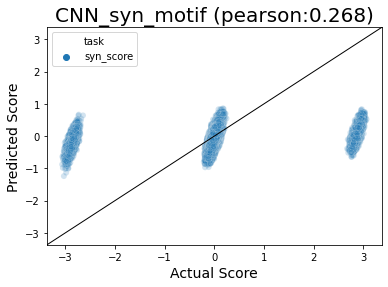

In [79]:
models = [
    #("LinearDeep_LR:NoCu",best_lin),
    ("CNN_syn_motif",best_cnn,DatasetSpec('ohe')),
]

genes = syn_df['id'].values
task = "OPT_best_syn_motif"

dfs = parity_pred_multi(models, genes, oracle_syn,task,['syn_score'],alt=False,syn_data=True)

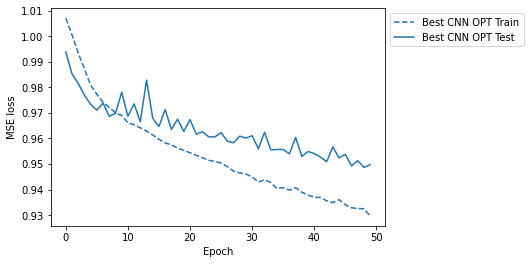

In [80]:
#lin_opt_data_label = [((lin_ow.best_train_loss,lin_ow.best_test_loss),'Best Lin OPT')]
cnn_opt_data_label = [((cnn_ow.best_train_loss,cnn_ow.best_test_loss),'Best CNN OPT')]
#kmer3_opt_data_label = [((kmer3_ow.best_train_loss,kmer3_ow.best_test_loss),'Best Kmer3 OPT')]
#kmer6_opt_data_label = [((kmer6_ow.best_train_loss,kmer6_ow.best_test_loss),'Best Kmer6 OPT')]

def quick_loss_plot(data_label_list):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,((train_data,test_data),label) in enumerate(data_label_list):
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Test")

    #plt.legend()
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.ylabel("MSE loss")
    plt.xlabel("Epoch")
    plt.show()
    
# quick_loss_plot(
#     lin_opt_data_label + \
#     cnn_opt_data_label + \
#     kmer3_opt_data_label + \
#     kmer6_opt_data_label 
# )
quick_loss_plot(
    cnn_opt_data_label
)

In [ ]:
# LOOK HERE ^^

In [27]:
# conv_layers, model_weights, bias_weights = get_conv_layers_from_model(best_cnn)
# view_filters(model_weights)
# filter_activations = get_filter_activations(syn_seqs_10k, conv_layers[0])
# view_filters_and_logos(model_weights,filter_activations)

torch.Size([64, 4, 14])


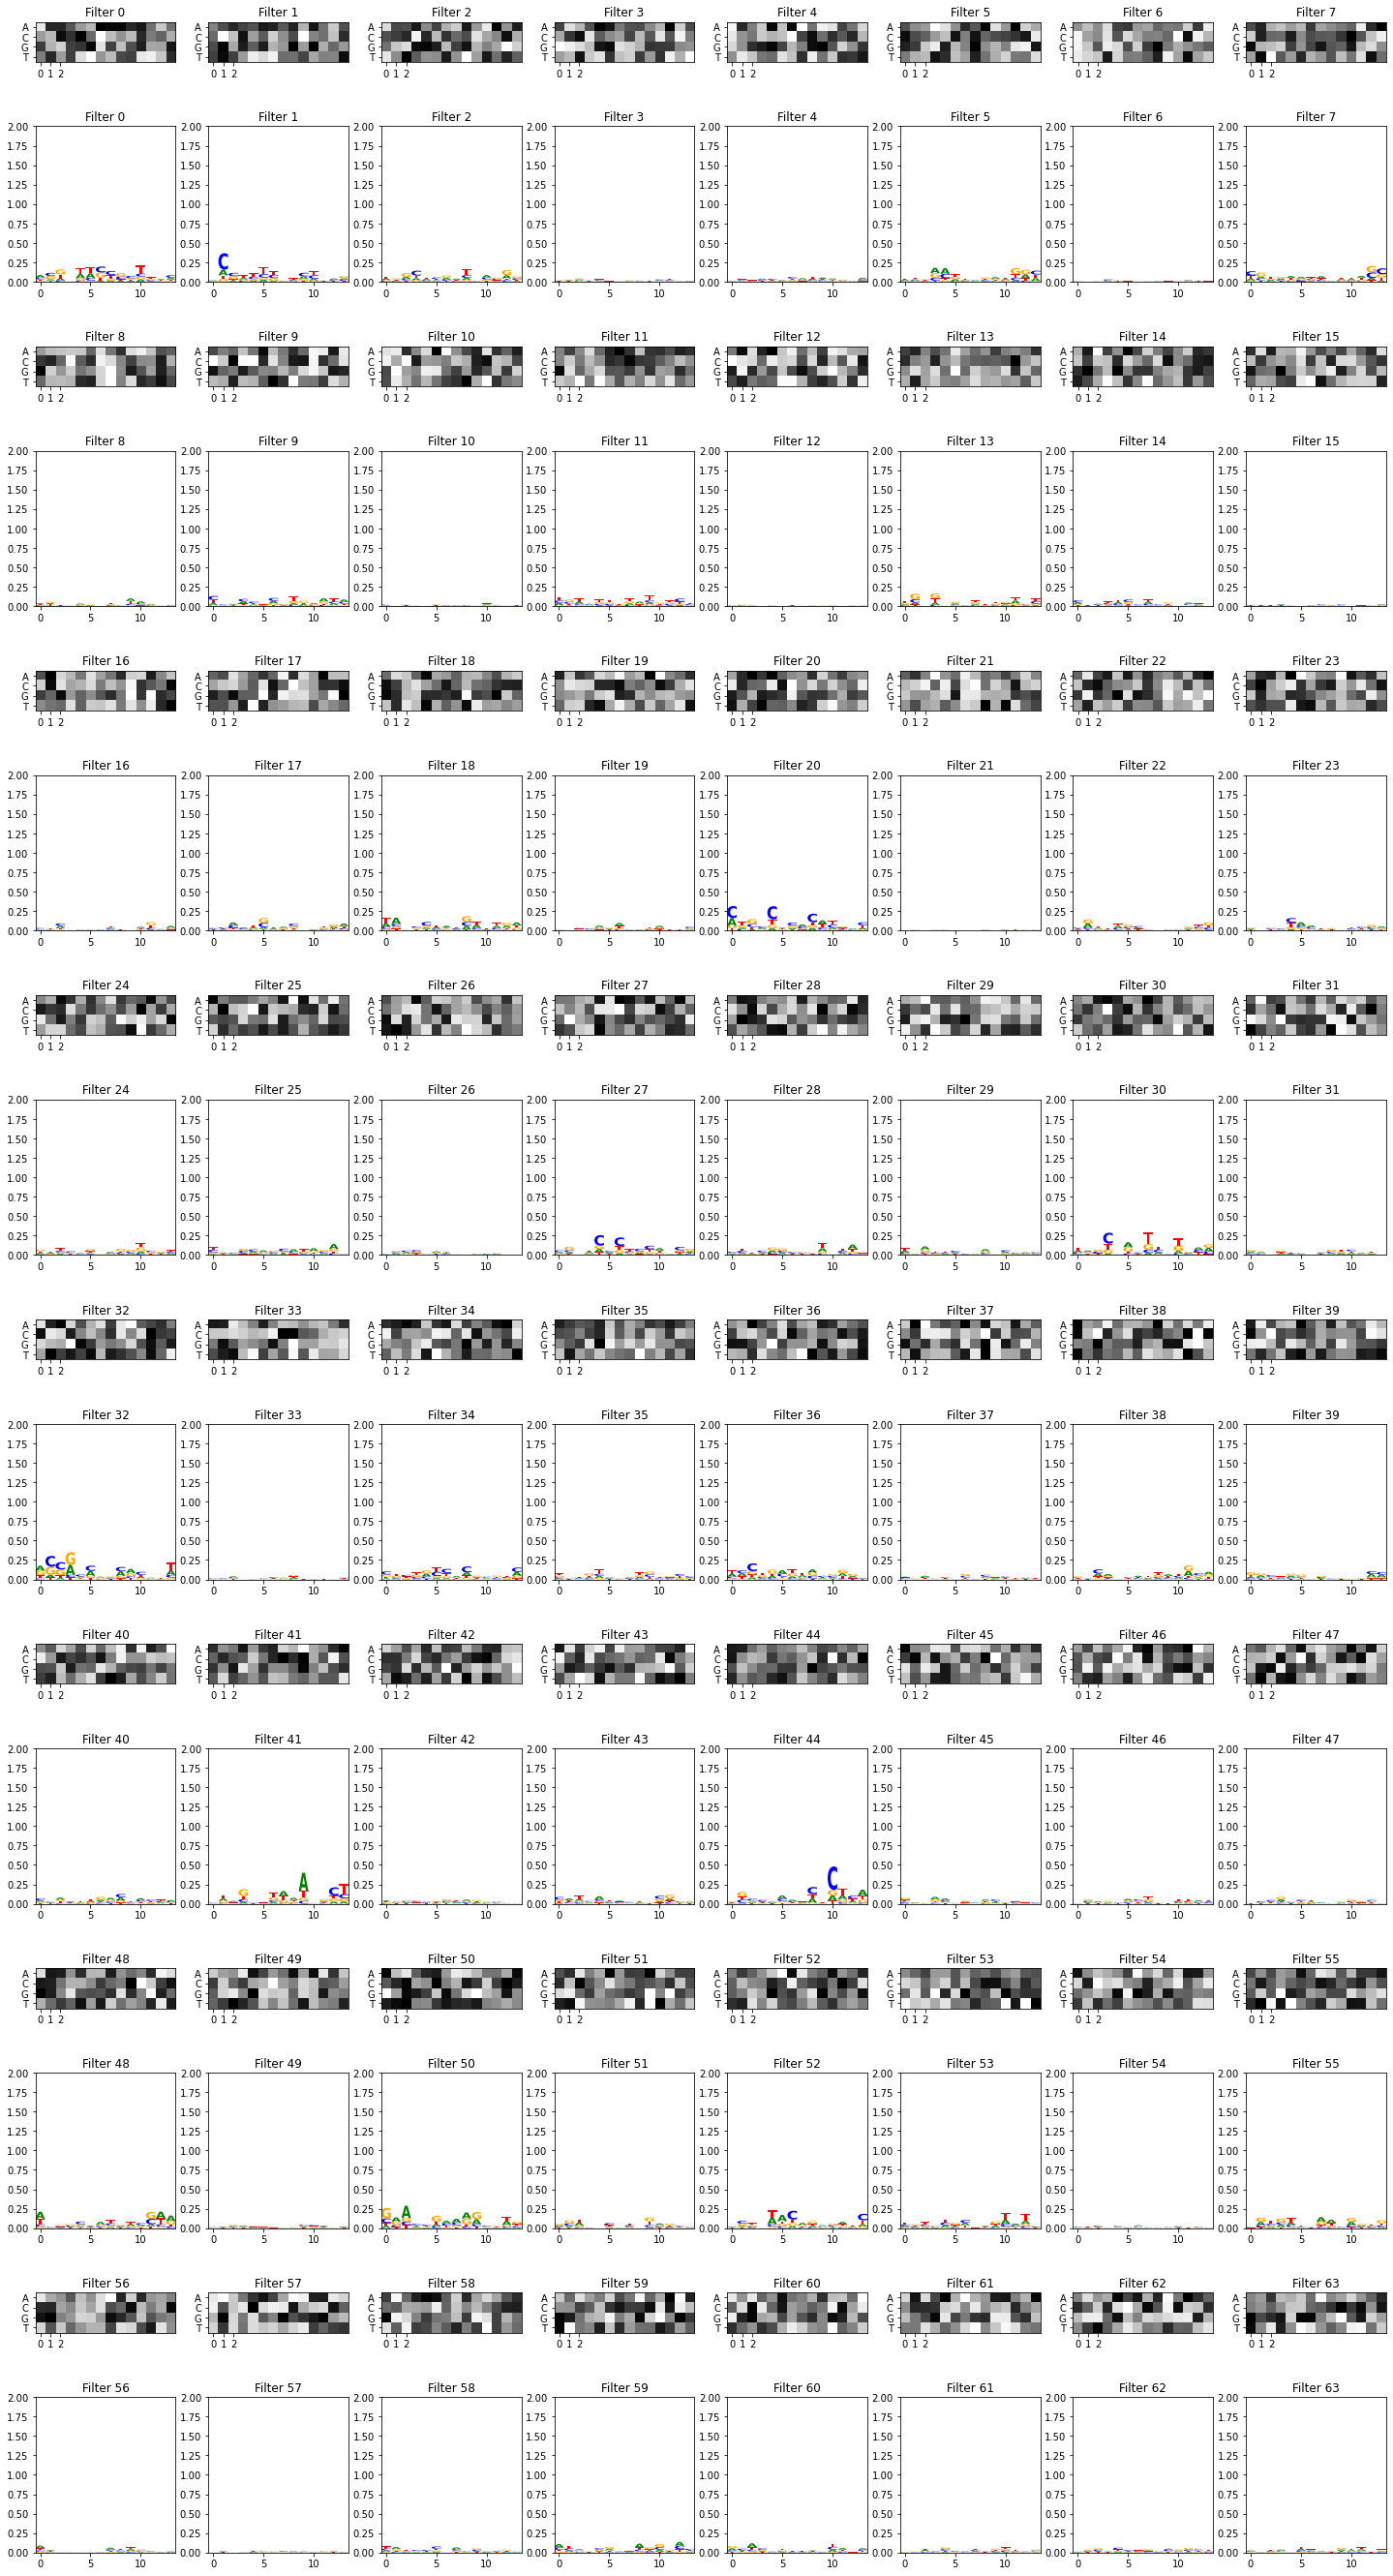

In [86]:
view_filters_and_logos(model_weights,filter_activations)

In [87]:
best_cnn

DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 14), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=5952, out_features=1, bias=True)
  )
)

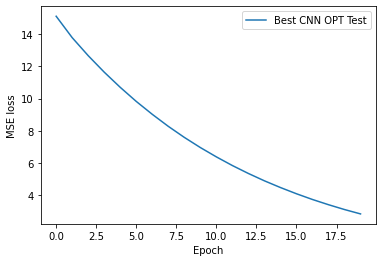

In [42]:
for i,((train_data,test_data),label) in enumerate(cnn_opt_data_label):
    #plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
    plt.plot(test_data,color=f"C{i}", label=f"{label} Test")

plt.legend()
plt.ylabel("MSE loss")
plt.xlabel("Epoch")
plt.show()

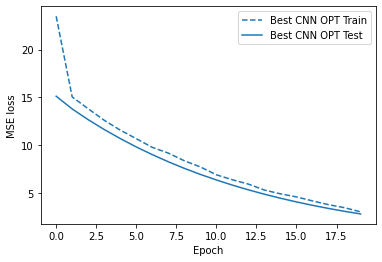

In [43]:
for i,((train_data,test_data),label) in enumerate(cnn_opt_data_label):
    plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
    plt.plot(test_data,color=f"C{i}", label=f"{label} Test")

plt.legend()
plt.ylabel("MSE loss")
plt.xlabel("Epoch")
plt.show()

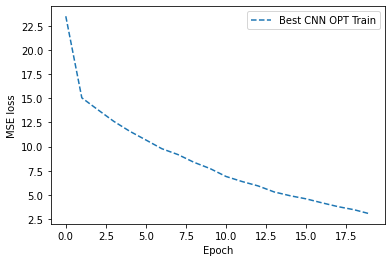

In [44]:
for i,((train_data,test_data),label) in enumerate(cnn_opt_data_label):
    plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
    #plt.plot(test_data,color=f"C{i}", label=f"{label} Test")

plt.legend()
plt.ylabel("MSE loss")
plt.xlabel("Epoch")
plt.show()

## Optuna: Kmer trial

In [45]:
# defining a deep linear model with Optuna
class Kmer_Opt(nn.ModuleList):
    def __init__(self, trial, num_kmers):
        super().__init__()
        
        self.num_kmers = num_kmers
        # Where the layers and dropouts will be stacked
        layers = []
        
        # Given a trial, takes the suggested number of 
        # layers as well as the dropout value  
        n_hidden_fc = trial.suggest_int('n_hidden_fc',0,2)
        print("linear layer num:", n_hidden_fc)
        
        # +---------------------+
        # | Hidden FC Layers (N)|
        # +---------------------+
        prev_linear_node_num = num_kmers
        
        for i in range(1,n_hidden_fc+1):
            # Trial suggestions
            lini_fc_nodes = trial.suggest_categorical(f'lin{i}_fc_nodes',[8,16,32,64])
            lini_dropout = trial.suggest_categorical(f'lin{i}_dropout',[0,0.1,0.2,0.3])
            
            print(f"lin{i}_fc_nodes", lini_fc_nodes)
            print(f"lin{i}_dropout", lini_dropout)
            
            # Layer additions
            layers.append(nn.Linear(prev_linear_node_num, lini_fc_nodes))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(lini_dropout))
            
            # value updates
            prev_linear_node_num = lini_fc_nodes
        
        # Add final prediction layer
        layers.append(nn.Linear(prev_linear_node_num, 1))
        
        # concat all the layers together
        self.lin = nn.Sequential(*layers)
        
            
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

### k=3

In [50]:
k3 = len(kmer3_train_dl.dataset.kmers)
eps=20
loss_func = torch.nn.MSELoss()
lr = 0.001

kmer3_ow = OptWrap(
    "Kmer3_Opt",
    Kmer_Opt,
    k3,
    eps,
    loss_func,
    lr,
    kmer3_train_dl, 
    kmer3_val_dl
)

kmer3_opt_study = optuna.create_study(direction="minimize")

kmer3_opt_study.optimize(kmer3_ow.optimize, n_trials=200)

print_study(kmer3_opt_study)

[I 2021-10-01 17:19:23,188] A new study created in memory with name: no-name-c3ba1c08-a0c3-40c1-8a24-0d0e849ea619
[I 2021-10-01 17:19:23,230] Trial 0 finished with value: 10.14526081085205 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.2}. Best is trial 0 with value: 10.14526081085205.
[I 2021-10-01 17:19:23,262] Trial 1 finished with value: 319791923200.0 and parameters: {'n_hidden_fc': 0}. Best is trial 0 with value: 10.14526081085205.
[I 2021-10-01 17:19:23,307] Trial 2 finished with value: 13.701822280883789 and parameters: {'n_hidden_fc': 2, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.3, 'lin2_fc_nodes': 32, 'lin2_dropout': 0}. Best is trial 0 with value: 10.14526081085205.
[I 2021-10-01 17:19:23,347] Trial 3 finished with value: 11.54358196258545 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 32, 'lin1_dropout': 0.1}. Best is trial 0 with value: 10.14526081085205.
[I 2021-10-01 17:19:23,386] Trial 4 finished with value: 9.332321166992188 and parameters:

linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 16.704496383666992
E1: 16.246723175048828
E2: 15.67937183380127
E3: 15.288970947265625
E4: 14.89726448059082
E5: 14.4025239944458
E6: 14.083139419555664
E7: 13.791485786437988
E8: 13.402236938476562
E9: 13.0971097946167
E10: 12.850848197937012
E11: 12.558420181274414
E12: 12.259596824645996
E13: 11.987159729003906
E14: 11.693161010742188
E15: 11.393122673034668
E16: 11.082099914550781
E17: 10.768416404724121
E18: 10.43585205078125
E19: 10.14526081085205
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 33.30673599243164
E1: 70.45000457763672
E2: 203.8574981689453
E3: 672.8302612304688
E4: 2312.692138671875
E5: 8039.1376953125
E6: 28029.240234375
E7: 97805.4375
E8: 341356.34375
E9: 1191456.25
E10:

[I 2021-10-01 17:19:23,396] Trial 6 pruned. 
[I 2021-10-01 17:19:23,401] Trial 7 pruned. 
[I 2021-10-01 17:19:23,405] Trial 8 pruned. 
[I 2021-10-01 17:19:23,411] Trial 9 pruned. 
[I 2021-10-01 17:19:23,417] Trial 10 pruned. 
[I 2021-10-01 17:19:23,465] Trial 11 finished with value: 9.00714111328125 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.2}. Best is trial 11 with value: 9.00714111328125.
[I 2021-10-01 17:19:23,473] Trial 12 pruned. 
[I 2021-10-01 17:19:23,521] Trial 13 finished with value: 9.434021949768066 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.2}. Best is trial 11 with value: 9.00714111328125.
[I 2021-10-01 17:19:23,528] Trial 14 pruned. 
[I 2021-10-01 17:19:23,535] Trial 15 pruned. 
[I 2021-10-01 17:19:23,543] Trial 16 pruned. 
[I 2021-10-01 17:19:23,550] Trial 17 pruned. 
[I 2021-10-01 17:19:23,557] Trial 18 pruned. 
[I 2021-10-01 17:19:23,567] Trial 19 pruned. 


linear layer num: 0
E0: 136.4683837890625
linear layer num: 2
lin1_fc_nodes 16
lin1_dropout 0.1
lin2_fc_nodes 64
lin2_dropout 0
E0: 20.54338264465332
linear layer num: 1
lin1_fc_nodes 16
lin1_dropout 0
E0: 17.613794326782227
linear layer num: 2
lin1_fc_nodes 64
lin1_dropout 0.2
lin2_fc_nodes 64
lin2_dropout 0.3
E0: 18.954483032226562
linear layer num: 0
E0: 102.4970932006836
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 16.24906349182129
E1: 15.598401069641113
E2: 15.054513931274414
E3: 14.508435249328613
E4: 14.07666015625
E5: 13.650934219360352
E6: 13.272041320800781
E7: 12.935823440551758
E8: 12.598746299743652
E9: 12.129420280456543
E10: 11.71907901763916
E11: 11.33349609375
E12: 11.06812572479248
E13: 10.743998527526855
E14: 10.437407493591309
E15: 10.442831993103027
E16: 9.866435050964355
E17: 9.61903190612793
E18: 9.265589714050293
E19: 9.00714111328125
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    

[I 2021-10-01 17:19:23,616] Trial 20 finished with value: 8.791625022888184 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 20 with value: 8.791625022888184.
[I 2021-10-01 17:19:23,664] Trial 21 finished with value: 8.319297790527344 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 21 with value: 8.319297790527344.
[I 2021-10-01 17:19:23,712] Trial 22 finished with value: 7.7808098793029785 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 22 with value: 7.7808098793029785.
[I 2021-10-01 17:19:23,720] Trial 23 pruned. 
[I 2021-10-01 17:19:23,738] Trial 24 pruned. 
[I 2021-10-01 17:19:23,747] Trial 25 pruned. 
[I 2021-10-01 17:19:23,753] Trial 26 pruned. 
[I 2021-10-01 17:19:23,772] Trial 27 pruned. 


E9: 11.963896751403809
E10: 11.537856101989746
E11: 11.221864700317383
E12: 10.8515625
E13: 10.55411434173584
E14: 10.209912300109863
E15: 9.986151695251465
E16: 9.61059856414795
E17: 9.35737133026123
E18: 9.031643867492676
E19: 8.791625022888184
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.794466972351074
E1: 15.022635459899902
E2: 14.417773246765137
E3: 13.862139701843262
E4: 13.412200927734375
E5: 12.95438289642334
E6: 12.529013633728027
E7: 12.132630348205566
E8: 11.767160415649414
E9: 11.349980354309082
E10: 10.963563919067383
E11: 10.60398006439209
E12: 10.398154258728027
E13: 10.064042091369629
E14: 9.699376106262207
E15: 9.389540672302246
E16: 9.163844108581543
E17: 8.829779624938965
E18: 8.5692882537841

[I 2021-10-01 17:19:23,820] Trial 28 finished with value: 8.298131942749023 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 22 with value: 7.7808098793029785.
[I 2021-10-01 17:19:23,827] Trial 29 pruned. 
[I 2021-10-01 17:19:23,837] Trial 30 pruned. 
[I 2021-10-01 17:19:23,845] Trial 31 pruned. 
[I 2021-10-01 17:19:23,893] Trial 32 finished with value: 8.950698852539062 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 22 with value: 7.7808098793029785.
[I 2021-10-01 17:19:23,941] Trial 33 finished with value: 8.531671524047852 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 22 with value: 7.7808098793029785.
[I 2021-10-01 17:19:23,949] Trial 34 pruned. 
[I 2021-10-01 17:19:23,958] Trial 35 pruned. 


E8: 12.161229133605957
E9: 11.875584602355957
E10: 11.429688453674316
E11: 11.073150634765625
E12: 10.729435920715332
E13: 10.350066184997559
E14: 9.956184387207031
E15: 9.623641014099121
E16: 9.322882652282715
E17: 8.955925941467285
E18: 8.637189865112305
E19: 8.298131942749023
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 85.29509735107422
linear layer num: 2
lin1_fc_nodes 64
lin1_dropout 0.3
lin2_fc_nodes 16
lin2_dropout 0.3
E0: 27.150434494018555
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.91974639892578
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.106802940368652
E1: 14.7008056640625
E2: 14.298646926879883
E3: 13.954269409179688
E4: 13.561419486999512
E5: 13.183138847351074
E6: 12.867965698242188
E7: 12.54860973

[I 2021-10-01 17:19:24,008] Trial 36 finished with value: 7.155661106109619 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 36 with value: 7.155661106109619.
[I 2021-10-01 17:19:24,017] Trial 37 pruned. 
[I 2021-10-01 17:19:24,036] Trial 38 pruned. 
[I 2021-10-01 17:19:24,044] Trial 39 pruned. 
[I 2021-10-01 17:19:24,054] Trial 40 pruned. 
[I 2021-10-01 17:19:24,102] Trial 41 finished with value: 7.999876499176025 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 36 with value: 7.155661106109619.
[I 2021-10-01 17:19:24,129] Trial 42 pruned. 
[I 2021-10-01 17:19:24,148] Trial 43 pruned. 
[I 2021-10-01 17:19:24,156] Trial 44 pruned. 
[I 2021-10-01 17:19:24,165] Trial 45 pruned. 


E15: 8.318577766418457
E16: 7.970571994781494
E17: 7.684084415435791
E18: 7.427252292633057
E19: 7.155661106109619
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.601713180541992
linear layer num: 1
lin1_fc_nodes 16
lin1_dropout 0.1
E0: 15.659052848815918
E1: 14.75934886932373
E2: 14.378700256347656
E3: 14.184646606445312
E4: 13.730549812316895
E5: 13.49591064453125
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0.3
E0: 22.691696166992188
linear layer num: 2
lin1_fc_nodes 32
lin1_dropout 0.1
lin2_fc_nodes 32
lin2_dropout 0.2
E0: 21.19795036315918
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 14.859646797180176
E1: 14.29771900177002
E2: 13.886507987976074
E3: 13.50493049621582
E4: 13.088945388793945
E5

[I 2021-10-01 17:19:24,214] Trial 46 finished with value: 8.332167625427246 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 36 with value: 7.155661106109619.
[I 2021-10-01 17:19:24,222] Trial 47 pruned. 
[I 2021-10-01 17:19:24,270] Trial 48 finished with value: 6.786139965057373 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0}. Best is trial 48 with value: 6.786139965057373.
[I 2021-10-01 17:19:24,276] Trial 49 pruned. 
[I 2021-10-01 17:19:24,286] Trial 50 pruned. 
[I 2021-10-01 17:19:24,334] Trial 51 finished with value: 8.044778823852539 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0}. Best is trial 48 with value: 6.786139965057373.
[I 2021-10-01 17:19:24,381] Trial 52 finished with value: 6.4608988761901855 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:24,390] Trial 53 pruned. 


E14: 9.708586692810059
E15: 9.41455078125
E16: 9.142443656921387
E17: 8.849611282348633
E18: 8.57487678527832
E19: 8.332167625427246
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.1
E0: 15.881573677062988
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 14.560935974121094
E1: 13.5724515914917
E2: 13.046635627746582
E3: 12.579368591308594
E4: 12.118369102478027
E5: 11.660914421081543
E6: 11.21399211883545
E7: 10.808459281921387
E8: 10.417556762695312
E9: 10.037882804870605
E10: 9.66807746887207
E11: 9.299227714538574
E12: 8.94670581817627
E13: 8.60990047454834
E14: 8.281250953674316
E15: 7.9637451171875
E16: 7.659767150878906
E17: 7.3617401123046875
E18: 7.068759441375732
E19: 6.786139965057373
****Model Arch ****
Km

[I 2021-10-01 17:19:24,419] Trial 54 pruned. 
[I 2021-10-01 17:19:24,428] Trial 55 pruned. 
[I 2021-10-01 17:19:24,436] Trial 56 pruned. 
[I 2021-10-01 17:19:24,444] Trial 57 pruned. 
[I 2021-10-01 17:19:24,453] Trial 58 pruned. 
[I 2021-10-01 17:19:24,461] Trial 59 pruned. 
[I 2021-10-01 17:19:24,469] Trial 60 pruned. 
[I 2021-10-01 17:19:24,478] Trial 61 pruned. 
[I 2021-10-01 17:19:24,486] Trial 62 pruned. 
[I 2021-10-01 17:19:24,495] Trial 63 pruned. 
[I 2021-10-01 17:19:24,503] Trial 64 pruned. 
[I 2021-10-01 17:19:24,512] Trial 65 pruned. 
[I 2021-10-01 17:19:24,520] Trial 66 pruned. 
[I 2021-10-01 17:19:24,529] Trial 67 pruned. 
[I 2021-10-01 17:19:24,538] Trial 68 pruned. 
[I 2021-10-01 17:19:24,547] Trial 69 pruned. 
[I 2021-10-01 17:19:24,555] Trial 70 pruned. 
[I 2021-10-01 17:19:24,564] Trial 71 pruned. 
[I 2021-10-01 17:19:24,573] Trial 72 pruned. 
[I 2021-10-01 17:19:24,581] Trial 73 pruned. 


E3: 13.449113845825195
E4: 13.13891315460205
E5: 12.85044002532959
E6: 12.56684398651123
E7: 12.285834312438965
E8: 12.01468563079834
E9: 11.735457420349121
E10: 11.456623077392578
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 17.621109008789062
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 18.499738693237305
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 17.774494171142578
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0
E0: 17.995771408081055
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0
E0: 17.54142951965332
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 16.986568450927734
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 16.30466651916504
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 15.845575332641602
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.3
E0: 15.790133476257324
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 15.798181533813477
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 17.6715278

[I 2021-10-01 17:19:24,631] Trial 74 finished with value: 7.091526985168457 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:24,640] Trial 75 pruned. 
[I 2021-10-01 17:19:24,648] Trial 76 pruned. 
[I 2021-10-01 17:19:24,657] Trial 77 pruned. 
[I 2021-10-01 17:19:24,666] Trial 78 pruned. 
[I 2021-10-01 17:19:24,675] Trial 79 pruned. 
[I 2021-10-01 17:19:24,681] Trial 80 pruned. 
[I 2021-10-01 17:19:24,690] Trial 81 pruned. 
[I 2021-10-01 17:19:24,699] Trial 82 pruned. 
[I 2021-10-01 17:19:24,708] Trial 83 pruned. 
[I 2021-10-01 17:19:24,717] Trial 84 pruned. 
[I 2021-10-01 17:19:24,766] Trial 85 pruned. 


E8: 10.863921165466309
E9: 10.547126770019531
E10: 10.122227668762207
E11: 9.779199600219727
E12: 9.386454582214355
E13: 9.082844734191895
E14: 8.711800575256348
E15: 8.402756690979004
E16: 8.098113059997559
E17: 7.91177225112915
E18: 7.543109893798828
E19: 7.091526985168457
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.268047332763672
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 17.011619567871094
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.353270530700684
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.2
E0: 20.227827072143555
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.488049507141113
linear layer num: 0
E0: 30.686756134033203
linear layer num: 1
lin1_fc_nodes

[I 2021-10-01 17:19:24,816] Trial 86 finished with value: 7.8123955726623535 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.3}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:24,825] Trial 87 pruned. 
[I 2021-10-01 17:19:24,834] Trial 88 pruned. 
[I 2021-10-01 17:19:24,843] Trial 89 pruned. 
[I 2021-10-01 17:19:24,852] Trial 90 pruned. 
[I 2021-10-01 17:19:24,901] Trial 91 finished with value: 7.003076076507568 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:24,909] Trial 92 pruned. 
[I 2021-10-01 17:19:24,918] Trial 93 pruned. 
[I 2021-10-01 17:19:24,927] Trial 94 pruned. 
[I 2021-10-01 17:19:24,936] Trial 95 pruned. 
[I 2021-10-01 17:19:24,945] Trial 96 pruned. 
[I 2021-10-01 17:19:24,954] Trial 97 pruned. 
[I 2021-10-01 17:19:24,963] Trial 98 pruned. 
[I 2021-10-01 17:19:24,972] Trial 99 pruned. 
[I 2021-10-01 17:19:24,981] Trial 100 prune

E16: 8.342015266418457
E17: 8.21768856048584
E18: 7.959161281585693
E19: 7.8123955726623535
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.3
E0: 16.21104621887207
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.3
E0: 16.139732360839844
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.3
E0: 16.973203659057617
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0.3
E0: 19.02981948852539
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 13.914422988891602
E1: 13.281071662902832
E2: 12.763304710388184
E3: 12.260284423828125
E4: 11.814424514770508
E5: 11.391722679138184
E6: 10.995378494262695
E7: 10.61577033996582
E8: 10.24760627746582
E9: 9.886743545532227
E10: 9.5495023727417
E11: 9.224331855773926
E12: 8.9178075790

[I 2021-10-01 17:19:25,058] Trial 104 finished with value: 7.217438697814941 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:25,068] Trial 105 pruned. 
[I 2021-10-01 17:19:25,077] Trial 106 pruned. 
[I 2021-10-01 17:19:25,087] Trial 107 pruned. 
[I 2021-10-01 17:19:25,096] Trial 108 pruned. 
[I 2021-10-01 17:19:25,105] Trial 109 pruned. 
[I 2021-10-01 17:19:25,115] Trial 110 pruned. 
[I 2021-10-01 17:19:25,124] Trial 111 pruned. 
[I 2021-10-01 17:19:25,133] Trial 112 pruned. 
[I 2021-10-01 17:19:25,142] Trial 113 pruned. 
[I 2021-10-01 17:19:25,152] Trial 114 pruned. 
[I 2021-10-01 17:19:25,161] Trial 115 pruned. 
[I 2021-10-01 17:19:25,170] Trial 116 pruned. 
[I 2021-10-01 17:19:25,180] Trial 117 pruned. 
[I 2021-10-01 17:19:25,189] Trial 118 pruned. 
[I 2021-10-01 17:19:25,198] Trial 119 pruned. 
[I 2021-10-01 17:19:25,207] Trial 120 pruned. 


linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 13.986319541931152
E1: 13.514566421508789
E2: 13.043426513671875
E3: 12.565176963806152
E4: 12.099868774414062
E5: 11.758292198181152
E6: 11.308094024658203
E7: 10.962508201599121
E8: 10.565380096435547
E9: 10.172987937927246
E10: 9.803511619567871
E11: 9.494755744934082
E12: 9.163331985473633
E13: 8.852893829345703
E14: 8.589985847473145
E15: 8.2885160446167
E16: 7.971459865570068
E17: 7.700563907623291
E18: 7.472161769866943
E19: 7.217438697814941
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 16
lin1_dropout 0.2
E0: 17.910490036010742
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 18.459514617919922
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.5273380279

[I 2021-10-01 17:19:25,217] Trial 121 pruned. 
[I 2021-10-01 17:19:25,227] Trial 122 pruned. 
[I 2021-10-01 17:19:25,268] Trial 123 pruned. 
[I 2021-10-01 17:19:25,277] Trial 124 pruned. 
[I 2021-10-01 17:19:25,287] Trial 125 pruned. 
[I 2021-10-01 17:19:25,296] Trial 126 pruned. 
[I 2021-10-01 17:19:25,306] Trial 127 pruned. 
[I 2021-10-01 17:19:25,316] Trial 128 pruned. 
[I 2021-10-01 17:19:25,325] Trial 129 pruned. 
[I 2021-10-01 17:19:25,335] Trial 130 pruned. 
[I 2021-10-01 17:19:25,345] Trial 131 pruned. 
[I 2021-10-01 17:19:25,354] Trial 132 pruned. 
[I 2021-10-01 17:19:25,405] Trial 133 finished with value: 7.187598705291748 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.


0.1
E0: 15.013635635375977
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.3498477935791
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 14.168037414550781
E1: 13.737034797668457
E2: 13.34362506866455
E3: 12.982975959777832
E4: 12.623672485351562
E5: 12.276124954223633
E6: 11.978072166442871
E7: 11.673049926757812
E8: 11.390196800231934
E9: 11.086517333984375
E10: 10.768084526062012
E11: 10.49181842803955
E12: 10.20185375213623
E13: 9.919876098632812
E14: 9.695876121520996
E15: 9.447629928588867
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.91285514831543
linear layer num: 1
lin1_fc_nodes 16
lin1_dropout 0.2
E0: 15.465609550476074
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 15.98284912109375
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.3
E0: 15.236373901367188
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.281468391418457
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0
E0: 20.145185470581055
linear layer num: 1
l

[I 2021-10-01 17:19:25,415] Trial 134 pruned. 
[I 2021-10-01 17:19:25,426] Trial 135 pruned. 
[I 2021-10-01 17:19:25,436] Trial 136 pruned. 
[I 2021-10-01 17:19:25,487] Trial 137 finished with value: 7.788560390472412 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:25,497] Trial 138 pruned. 
[I 2021-10-01 17:19:25,507] Trial 139 pruned. 
[I 2021-10-01 17:19:25,517] Trial 140 pruned. 
[I 2021-10-01 17:19:25,527] Trial 141 pruned. 
[I 2021-10-01 17:19:25,537] Trial 142 pruned. 
[I 2021-10-01 17:19:25,587] Trial 143 finished with value: 7.340812683105469 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:25,598] Trial 144 pruned. 
[I 2021-10-01 17:19:25,607] Trial 145 pruned. 


E0: 17.75627326965332
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.41872215270996
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 15.661160469055176
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 14.473187446594238
E1: 13.592291831970215
E2: 13.149765014648438
E3: 12.767729759216309
E4: 12.398788452148438
E5: 12.036908149719238
E6: 11.681888580322266
E7: 11.330662727355957
E8: 10.995680809020996
E9: 10.640463829040527
E10: 10.31186580657959
E11: 9.988055229187012
E12: 9.654829025268555
E13: 9.349745750427246
E14: 9.090505599975586
E15: 8.804829597473145
E16: 8.561869621276855
E17: 8.31284236907959
E18: 8.056017875671387
E19: 7.788560390472412
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0

[I 2021-10-01 17:19:25,617] Trial 146 pruned. 
[I 2021-10-01 17:19:25,627] Trial 147 pruned. 
[I 2021-10-01 17:19:25,636] Trial 148 pruned. 
[I 2021-10-01 17:19:25,687] Trial 149 finished with value: 7.170773983001709 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.2}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:25,697] Trial 150 pruned. 
[I 2021-10-01 17:19:25,707] Trial 151 pruned. 
[I 2021-10-01 17:19:25,716] Trial 152 pruned. 
[I 2021-10-01 17:19:25,726] Trial 153 pruned. 
[I 2021-10-01 17:19:25,736] Trial 154 pruned. 
[I 2021-10-01 17:19:25,746] Trial 155 pruned. 
[I 2021-10-01 17:19:25,756] Trial 156 pruned. 
[I 2021-10-01 17:19:25,766] Trial 157 pruned. 
[I 2021-10-01 17:19:25,776] Trial 158 pruned. 
[I 2021-10-01 17:19:25,786] Trial 159 pruned. 
[I 2021-10-01 17:19:25,796] Trial 160 pruned. 
[I 2021-10-01 17:19:25,806] Trial 161 pruned. 


E0: 16.807111740112305
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.75172996520996
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 16.21182632446289
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 14.833887100219727
E1: 14.16074275970459
E2: 13.62303352355957
E3: 13.088075637817383
E4: 12.674349784851074
E5: 12.15632438659668
E6: 11.78692626953125
E7: 11.148016929626465
E8: 10.758713722229004
E9: 10.270929336547852
E10: 9.83701229095459
E11: 9.537066459655762
E12: 9.184175491333008
E13: 8.904250144958496
E14: 8.553901672363281
E15: 8.263402938842773
E16: 7.921580791473389
E17: 7.631932258605957
E18: 7.378768444061279
E19: 7.170773983001709
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 16
lin1_dropout 0.2
E

[I 2021-10-01 17:19:25,840] Trial 162 pruned. 
[I 2021-10-01 17:19:25,849] Trial 163 pruned. 
[I 2021-10-01 17:19:25,859] Trial 164 pruned. 
[I 2021-10-01 17:19:25,874] Trial 165 pruned. 
[I 2021-10-01 17:19:25,924] Trial 166 finished with value: 7.499787330627441 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:25,935] Trial 167 pruned. 
[I 2021-10-01 17:19:25,945] Trial 168 pruned. 
[I 2021-10-01 17:19:25,955] Trial 169 pruned. 
[I 2021-10-01 17:19:25,965] Trial 170 pruned. 
[I 2021-10-01 17:19:25,975] Trial 171 pruned. 


E2: 13.672314643859863
E3: 13.230633735656738
E4: 12.856225967407227
E5: 12.532694816589355
E6: 12.250861167907715
E7: 11.9097318649292
E8: 11.539809226989746
E9: 11.237548828125
E10: 10.893942832946777
E11: 10.580978393554688
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 14.97015380859375
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.502260208129883
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 14.623443603515625
E1: 14.225921630859375
E2: 13.850749015808105
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 14.285687446594238
E1: 13.49170207977295
E2: 13.122896194458008
E3: 12.732996940612793
E4: 12.35578441619873
E5: 11.988916397094727
E6: 11.600897789001465
E7: 11.264609336853027
E8: 10.873717308044434
E9: 10.595678329467773
E10: 10.161256790161133
E11: 9.789385795593262
E12: 9.535435676574707
E13: 9.24974250793457
E14: 9.13232707977295
E15: 8.70464038848877
E16: 8.34375286102295
E17: 8.101666450500488
E18: 7.804446697235107
E19: 7.499787

[I 2021-10-01 17:19:26,026] Trial 172 finished with value: 7.437587261199951 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:26,036] Trial 173 pruned. 
[I 2021-10-01 17:19:26,047] Trial 174 pruned. 
[I 2021-10-01 17:19:26,057] Trial 175 pruned. 
[I 2021-10-01 17:19:26,067] Trial 176 pruned. 
[I 2021-10-01 17:19:26,077] Trial 177 pruned. 
[I 2021-10-01 17:19:26,087] Trial 178 pruned. 
[I 2021-10-01 17:19:26,097] Trial 179 pruned. 
[I 2021-10-01 17:19:26,107] Trial 180 pruned. 
[I 2021-10-01 17:19:26,117] Trial 181 pruned. 
[I 2021-10-01 17:19:26,127] Trial 182 pruned. 
[I 2021-10-01 17:19:26,137] Trial 183 pruned. 
[I 2021-10-01 17:19:26,148] Trial 184 pruned. 
[I 2021-10-01 17:19:26,158] Trial 185 pruned. 
[I 2021-10-01 17:19:26,168] Trial 186 pruned. 
[I 2021-10-01 17:19:26,179] Trial 187 pruned. 
[I 2021-10-01 17:19:26,189] Trial 188 pruned. 
[I 2021-10-01 17:19:26,199] Trial 189 pruned

E18: 7.64076566696167
E19: 7.437587261199951
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.93827247619629
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 17.605491638183594
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.1
E0: 19.541200637817383
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.915815353393555
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.418108940124512
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 15.237460136413574
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.44956111907959
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 16.991073608398438
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.517292022705078
lin

[I 2021-10-01 17:19:26,230] Trial 192 pruned. 
[I 2021-10-01 17:19:26,241] Trial 193 pruned. 
[I 2021-10-01 17:19:26,251] Trial 194 pruned. 
[I 2021-10-01 17:19:26,262] Trial 195 pruned. 
[I 2021-10-01 17:19:26,273] Trial 196 pruned. 
[I 2021-10-01 17:19:26,284] Trial 197 pruned. 
[I 2021-10-01 17:19:26,295] Trial 198 pruned. 
[I 2021-10-01 17:19:26,305] Trial 199 pruned. 


linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.736579895019531
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.678875923156738
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 17.0250186920166
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.536221504211426
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.572502136230469
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.60329246520996
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 14.854657173156738
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 14.923212051391602
Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  171
  Number of complete trials:  29
Best trial:
  Value :  6.4608988761901855
  Number:  52
  Params: 
    n_hidden_fc: 1
    lin1_fc_nodes: 64
    lin1_dropout: 0


In [51]:
best_kmer3 = kmer3_ow.retrain_best(kmer3_opt_study.best_trial)

linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 14.389915466308594
E1: 13.919344902038574
E2: 13.497207641601562
E3: 13.080514907836914
E4: 12.688490867614746
E5: 12.315924644470215
E6: 11.94937801361084
E7: 11.569273948669434
E8: 11.178973197937012
E9: 10.813311576843262
E10: 10.452986717224121
E11: 10.102057456970215
E12: 9.785041809082031
E13: 9.475157737731934
E14: 9.16741943359375
E15: 8.864517211914062
E16: 8.57769775390625
E17: 8.295851707458496
E18: 8.024382591247559
E19: 7.756619453430176


### k=6

In [48]:
k6 = len(kmer6_train_dl.dataset.kmers)
eps=20
loss_func = torch.nn.MSELoss()
lr = 0.001

kmer6_ow = OptWrap(
    "Kmer6_Opt",
    Kmer_Opt,
    k6,
    eps,
    loss_func,
    lr,
    kmer6_train_dl, 
    kmer6_val_dl
)

kmer6_opt_study = optuna.create_study(direction="minimize")

kmer6_opt_study.optimize(kmer6_ow.optimize, n_trials=200)

print_study(kmer6_opt_study)

[I 2021-10-01 17:19:11,399] A new study created in memory with name: no-name-0c0202f2-433f-45ec-bc5e-0e81fa4ae966
[I 2021-10-01 17:19:11,463] Trial 0 finished with value: 19.26093864440918 and parameters: {'n_hidden_fc': 2, 'lin1_fc_nodes': 32, 'lin1_dropout': 0.1, 'lin2_fc_nodes': 8, 'lin2_dropout': 0.2}. Best is trial 0 with value: 19.26093864440918.
[I 2021-10-01 17:19:11,508] Trial 1 finished with value: 4.7541937828063965 and parameters: {'n_hidden_fc': 0}. Best is trial 1 with value: 4.7541937828063965.
[I 2021-10-01 17:19:11,560] Trial 2 finished with value: 15.277572631835938 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 16, 'lin1_dropout': 0.1}. Best is trial 1 with value: 4.7541937828063965.


linear layer num: 2
lin1_fc_nodes 32
lin1_dropout 0.1
lin2_fc_nodes 8
lin2_dropout 0.2
E0: 21.215728759765625
E1: 21.106233596801758
E2: 21.006132125854492
E3: 20.89723014831543
E4: 20.792800903320312
E5: 20.70549774169922
E6: 20.629335403442383
E7: 20.51909828186035
E8: 20.410749435424805
E9: 20.340660095214844
E10: 20.244552612304688
E11: 20.154476165771484
E12: 20.04886245727539
E13: 19.945432662963867
E14: 19.841703414916992
E15: 19.73967170715332
E16: 19.63799476623535
E17: 19.514699935913086
E18: 19.385103225708008
E19: 19.26093864440918
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=8, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.99019432067871
E1: 19.05830383300

[I 2021-10-01 17:19:11,619] Trial 3 finished with value: 21.26307487487793 and parameters: {'n_hidden_fc': 2, 'lin1_fc_nodes': 8, 'lin1_dropout': 0, 'lin2_fc_nodes': 8, 'lin2_dropout': 0.1}. Best is trial 1 with value: 4.7541937828063965.
[I 2021-10-01 17:19:11,663] Trial 4 finished with value: 4.73805046081543 and parameters: {'n_hidden_fc': 0}. Best is trial 4 with value: 4.73805046081543.
[I 2021-10-01 17:19:11,720] Trial 5 finished with value: 15.023096084594727 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 16, 'lin1_dropout': 0.2}. Best is trial 4 with value: 4.73805046081543.
[I 2021-10-01 17:19:11,768] Trial 6 finished with value: 4.8243584632873535 and parameters: {'n_hidden_fc': 0}. Best is trial 4 with value: 4.73805046081543.
[I 2021-10-01 17:19:11,776] Trial 7 pruned. 
[I 2021-10-01 17:19:11,782] Trial 8 pruned. 
[I 2021-10-01 17:19:11,790] Trial 9 pruned. 


E14: 21.496007919311523
E15: 21.45119285583496
E16: 21.406192779541016
E17: 21.35616111755371
E18: 21.309938430786133
E19: 21.26307487487793
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.397855758666992
E1: 18.573997497558594
E2: 16.96070671081543
E3: 15.528109550476074
E4: 14.2510986328125
E5: 13.10851764678955
E6: 12.082504272460938
E7: 11.157952308654785
E8: 10.322044372558594
E9: 9.563886642456055
E10: 8.874183654785156
E11: 8.244990348815918
E12: 7.669490337371826
E13: 7.141810894012451
E14: 6.656887054443359
E15: 6.210323810577393
E16: 5.7982964515686035
E17: 5.4174675941467285
E18: 5.064910888671875
E19: 4.738050460815

[I 2021-10-01 17:19:11,843] Trial 10 finished with value: 4.861721992492676 and parameters: {'n_hidden_fc': 0}. Best is trial 4 with value: 4.73805046081543.
[I 2021-10-01 17:19:11,896] Trial 11 finished with value: 4.689782619476318 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 4.689782619476318.
[I 2021-10-01 17:19:11,948] Trial 12 finished with value: 4.755666732788086 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 4.689782619476318.
[I 2021-10-01 17:19:11,955] Trial 13 pruned. 
[I 2021-10-01 17:19:12,007] Trial 14 finished with value: 4.717681884765625 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 4.689782619476318.


E4: 14.510184288024902
E5: 13.354103088378906
E6: 12.315584182739258
E7: 11.379389762878418
E8: 10.532599449157715
E9: 9.764226913452148
E10: 9.064909934997559
E11: 8.426640510559082
E12: 7.842550754547119
E13: 7.306727886199951
E14: 6.814066410064697
E15: 6.360142707824707
E16: 5.941106796264648
E17: 5.553596019744873
E18: 5.194665431976318
E19: 4.861721992492676
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.428707122802734
E1: 18.57590103149414
E2: 16.940458297729492
E3: 15.491190910339355
E4: 14.20190715789795
E5: 13.050570487976074
E6: 12.018603324890137
E7: 11.090311050415039
E8: 10.252402305603027
E9: 9.493597984313965
E10: 8.804287910461426
E11: 8.176279067993164
E12: 7.602548122406006
E13: 7.077065944671631
E14: 6.594632625579834
E15: 6.150752544403076
E16: 5.741523265838623
E17: 5.363541603088379
E18: 5.013832092285156
E19: 4.689782619476318
****Model Arch ***

[I 2021-10-01 17:19:12,017] Trial 15 pruned. 
[I 2021-10-01 17:19:12,069] Trial 16 finished with value: 4.7288737297058105 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 4.689782619476318.
[I 2021-10-01 17:19:12,079] Trial 17 pruned. 
[I 2021-10-01 17:19:12,131] Trial 18 finished with value: 4.63311243057251 and parameters: {'n_hidden_fc': 0}. Best is trial 18 with value: 4.63311243057251.
[I 2021-10-01 17:19:12,140] Trial 19 pruned. 
[I 2021-10-01 17:19:12,191] Trial 20 finished with value: 4.710566997528076 and parameters: {'n_hidden_fc': 0}. Best is trial 18 with value: 4.63311243057251.


linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.3
E0: 21.580780029296875
linear layer num: 0
E0: 20.56656837463379
E1: 18.701475143432617
E2: 17.055356979370117
E3: 15.596778869628906
E4: 14.299325942993164
E5: 13.140785217285156
E6: 12.102431297302246
E7: 11.16844654083252
E8: 10.325439453125
E9: 9.56203842163086
E10: 8.868570327758789
E11: 8.236776351928711
E12: 7.659585475921631
E13: 7.130925178527832
E14: 6.645561218261719
E15: 6.198968410491943
E16: 5.78721809387207
E17: 5.406886577606201
E18: 5.054980754852295
E19: 4.7288737297058105
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.3
E0: 21.545820236206055
linear layer num: 0
E0: 19.96463966369629
E1: 18.174365997314453
E2: 16.59166145324707
E3: 15.186985969543457
E4: 13.935505867004395
E5: 12.816307067871094
E6: 11.811749458312988
E7: 10.90691089630127
E8: 10.089139938354492
E9: 9.34769

[I 2021-10-01 17:19:12,244] Trial 21 finished with value: 4.684104919433594 and parameters: {'n_hidden_fc': 0}. Best is trial 18 with value: 4.63311243057251.
[I 2021-10-01 17:19:12,296] Trial 22 finished with value: 4.690818786621094 and parameters: {'n_hidden_fc': 0}. Best is trial 18 with value: 4.63311243057251.
[I 2021-10-01 17:19:12,303] Trial 23 pruned. 
[I 2021-10-01 17:19:12,355] Trial 24 finished with value: 4.5797014236450195 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,366] Trial 25 pruned. 


E6: 12.04304027557373
E7: 11.110607147216797
E8: 10.268953323364258
E9: 9.506763458251953
E10: 8.814414978027344
E11: 8.183680534362793
E12: 7.607517242431641
E13: 7.079870700836182
E14: 6.595520973205566
E15: 6.149950981140137
E16: 5.739235877990723
E17: 5.359957695007324
E18: 5.0091233253479
E19: 4.684104919433594
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.1912899017334
E1: 18.38100242614746
E2: 16.78068733215332
E3: 15.360447883605957
E4: 14.095152854919434
E5: 12.963641166687012
E6: 11.948063850402832
E7: 11.033320426940918
E8: 10.206616401672363
E9: 9.457076072692871
E10: 8.775428771972656
E11: 8.15375804901123
E12: 7.585264682769775
E13: 7.064113616943359
E14: 6.585258483886719
E15: 6.144334316253662
E16: 5.737541675567627
E17: 5.361568450927734
E18: 5.013510227203369
E19: 4.690818786621094
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_

[I 2021-10-01 17:19:12,418] Trial 26 finished with value: 4.6180901527404785 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,470] Trial 27 finished with value: 4.714041709899902 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,479] Trial 28 pruned. 
[I 2021-10-01 17:19:12,486] Trial 29 pruned. 
[I 2021-10-01 17:19:12,538] Trial 30 finished with value: 4.66161584854126 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,591] Trial 31 finished with value: 4.699704647064209 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.


E18: 4.935652256011963
E19: 4.6180901527404785
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.376760482788086
E1: 18.54554557800293
E2: 16.926944732666016
E3: 15.490686416625977
E4: 14.211320877075195
E5: 13.06742000579834
E6: 12.040902137756348
E7: 11.116477012634277
E8: 10.281181335449219
E9: 9.523999214172363
E10: 8.835545539855957
E11: 8.207793235778809
E12: 7.6338629722595215
E13: 7.107837200164795
E14: 6.624609470367432
E15: 6.179752349853516
E16: 5.769423961639404
E17: 5.390261173248291
E18: 5.03933048248291
E19: 4.714041709899902
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0.1
E0: 21.665122985839844
linear layer num: 0
E0: 20.680330276489258
linear layer num: 0
E0: 19.785686492919922
E1: 18.032730102539062
E2: 16.48108291

[I 2021-10-01 17:19:12,644] Trial 32 finished with value: 4.587696552276611 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,696] Trial 33 finished with value: 4.5929412841796875 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,749] Trial 34 finished with value: 4.6532301902771 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,802] Trial 35 finished with value: 4.581961631774902 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,811] Trial 36 pruned. 


E8: 10.010952949523926
E9: 9.27157211303711
E10: 8.599836349487305
E11: 7.987758636474609
E12: 7.428509712219238
E13: 6.9162187576293945
E14: 6.445827484130859
E15: 6.012961387634277
E16: 5.613822937011719
E17: 5.245103359222412
E18: 4.903907299041748
E19: 4.587696552276611
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.00502586364746
E1: 18.18828773498535
E2: 16.58513832092285
E3: 15.164875984191895
E4: 13.901727676391602
E5: 12.774012565612793
E6: 11.763453483581543
E7: 10.854615211486816
E8: 10.034433364868164
E9: 9.2918119430542
E10: 8.617315292358398
E11: 8.002886772155762
E12: 7.4416327476501465
E13: 6.9276299476623535
E14: 6.455776214599609
E15: 6.021658897399902
E16: 5.621448040008545
E17: 5.2518110275268555
E18: 4.909829616546631
E19: 4.5929412841796875
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=Tru

[I 2021-10-01 17:19:12,818] Trial 37 pruned. 
[I 2021-10-01 17:19:12,825] Trial 38 pruned. 
[I 2021-10-01 17:19:12,834] Trial 39 pruned. 
[I 2021-10-01 17:19:12,845] Trial 40 pruned. 
[I 2021-10-01 17:19:12,864] Trial 41 pruned. 
[I 2021-10-01 17:19:12,870] Trial 42 pruned. 
[I 2021-10-01 17:19:12,884] Trial 43 pruned. 
[I 2021-10-01 17:19:12,936] Trial 44 finished with value: 4.627091884613037 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,944] Trial 45 pruned. 
[I 2021-10-01 17:19:12,997] Trial 46 finished with value: 4.703074932098389 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,005] Trial 47 pruned. 
[I 2021-10-01 17:19:13,021] Trial 48 pruned. 


linear layer num: 0
E0: 20.495580673217773
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0.3
E0: 23.555618286132812
linear layer num: 2
lin1_fc_nodes 16
lin1_dropout 0.1
lin2_fc_nodes 32
lin2_dropout 0.3
E0: 23.012537002563477
linear layer num: 0
E0: 20.335567474365234
E1: 18.51275062561035
E2: 16.901348114013672
E3: 15.471244812011719
E4: 14.197138786315918
E5: 13.057721138000488
linear layer num: 0
E0: 20.673660278320312
linear layer num: 0
E0: 20.214719772338867
E1: 18.45484161376953
E2: 16.893163681030273
E3: 15.501996040344238
linear layer num: 0
E0: 19.98048973083496
E1: 18.1776180267334
E2: 16.585678100585938
E3: 15.174430847167969
E4: 13.918478965759277
E5: 12.7964506149292
E6: 11.790339469909668
E7: 10.884918212890625
E8: 10.067301750183105
E9: 9.32654857635498
E10: 8.653343200683594
E11: 8.03973388671875
E12: 7.478909969329834
E13: 6.965022563934326
E14: 6.493026256561279
E15: 6.058558940887451
E16: 5.657833576202393
E17: 5.287547588348389
E18: 4.94481086730957
E19: 4.6270

[I 2021-10-01 17:19:13,028] Trial 49 pruned. 
[I 2021-10-01 17:19:13,039] Trial 50 pruned. 
[I 2021-10-01 17:19:13,092] Trial 51 finished with value: 4.681273460388184 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,100] Trial 52 pruned. 
[I 2021-10-01 17:19:13,107] Trial 53 pruned. 
[I 2021-10-01 17:19:13,160] Trial 54 finished with value: 4.652487754821777 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,213] Trial 55 finished with value: 4.6947245597839355 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,222] Trial 56 pruned. 


linear layer num: 0
E0: 20.759450912475586
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 22.008752822875977
linear layer num: 0
E0: 20.009849548339844
E1: 18.23175621032715
E2: 16.657791137695312
E3: 15.259100914001465
E4: 14.011423110961914
E5: 12.894299507141113
E6: 11.890463829040527
E7: 10.985298156738281
E8: 10.166399002075195
E9: 9.42321491241455
E10: 8.746744155883789
E11: 8.129281997680664
E12: 7.564216136932373
E13: 7.0458526611328125
E14: 6.569268703460693
E15: 6.13019323348999
E16: 5.724910736083984
E17: 5.350173473358154
E18: 5.0031304359436035
E19: 4.681273460388184
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 21.070180892944336
linear layer num: 0
E0: 20.65205955505371
linear layer num: 0
E0: 20.170942306518555
E1: 18.34962272644043
E2: 16.741056442260742
E3: 15.314804077148438
E4: 14.045295715332031
E5: 12.911005020141602
E6: 11.893790245056152

[I 2021-10-01 17:19:13,275] Trial 57 finished with value: 4.66987943649292 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,328] Trial 58 finished with value: 4.67333459854126 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,341] Trial 59 pruned. 
[I 2021-10-01 17:19:13,348] Trial 60 pruned. 
[I 2021-10-01 17:19:13,397] Trial 61 pruned. 


E0: 19.901960372924805
E1: 18.132436752319336
E2: 16.566816329956055
E3: 15.176141738891602
E4: 13.936080932617188
E5: 12.826143264770508
E6: 11.829031944274902
E7: 10.930119514465332
E8: 10.1170072555542
E9: 9.379152297973633
E10: 8.70756721496582
E11: 8.09456729888916
E12: 7.53356409072876
E13: 7.018886089324951
E14: 6.545632839202881
E15: 6.109565258026123
E16: 5.706986427307129
E17: 5.334673881530762
E18: 4.989800930023193
E19: 4.66987943649292
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.004398345947266
E1: 18.22369384765625
E2: 16.64784049987793
E3: 15.24783992767334
E4: 13.999298095703125
E5: 12.881668090820312
E6: 11.877603530883789
E7: 10.972419738769531
E8: 10.15366268157959
E9: 9.410740852355957
E10: 8.734618186950684
E11: 8.11756706237793
E12: 7.552953243255615
E13: 7.035064220428467
E14: 6.558967113494873
E15: 6.120381832122803
E16: 5.7155866622924805
E17

[I 2021-10-01 17:19:13,451] Trial 62 finished with value: 4.659043788909912 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,459] Trial 63 pruned. 
[I 2021-10-01 17:19:13,514] Trial 64 finished with value: 4.6146368980407715 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,521] Trial 65 pruned. 
[I 2021-10-01 17:19:13,528] Trial 66 pruned. 
[I 2021-10-01 17:19:13,583] Trial 67 finished with value: 4.549609184265137 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:13,591] Trial 68 pruned. 
[I 2021-10-01 17:19:13,601] Trial 69 pruned. 
[I 2021-10-01 17:19:13,613] Trial 70 pruned. 


E11: 8.09519100189209
E12: 7.5316667556762695
E13: 7.014866828918457
E14: 6.5398430824279785
E15: 6.102304935455322
E16: 5.698519229888916
E17: 5.3252272605896
E18: 4.979573726654053
E19: 4.659043788909912
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.282140731811523
linear layer num: 0
E0: 19.397926330566406
E1: 17.69502067565918
E2: 16.18596839904785
E3: 14.843467712402344
E4: 13.644543647766113
E5: 12.569835662841797
E6: 11.602989196777344
E7: 10.730162620544434
E8: 9.939603805541992
E9: 9.22131633758545
E10: 8.566766738891602
E11: 7.9686479568481445
E12: 7.420689582824707
E13: 6.917483806610107
E14: 6.454357147216797
E15: 6.027252674102783
E16: 5.632636070251465
E17: 5.267416477203369
E18: 4.9288811683654785
E19: 4.6146368980407715
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*****************

[I 2021-10-01 17:19:13,667] Trial 71 finished with value: 4.641961097717285 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:13,675] Trial 72 pruned. 
[I 2021-10-01 17:19:13,728] Trial 73 finished with value: 4.6824541091918945 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:13,736] Trial 74 pruned. 
[I 2021-10-01 17:19:13,743] Trial 75 pruned. 
[I 2021-10-01 17:19:13,750] Trial 76 pruned. 
[I 2021-10-01 17:19:13,757] Trial 77 pruned. 
[I 2021-10-01 17:19:13,765] Trial 78 pruned. 
[I 2021-10-01 17:19:13,774] Trial 79 pruned. 
[I 2021-10-01 17:19:13,781] Trial 80 pruned. 
[I 2021-10-01 17:19:13,789] Trial 81 pruned. 


E6: 11.80966854095459
E7: 10.906173706054688
E8: 10.089696884155273
E9: 9.349469184875488
E10: 8.676311492919922
E11: 8.062386512756348
E12: 7.500972747802734
E13: 6.986293792724609
E14: 6.513363838195801
E15: 6.0778679847717285
E16: 5.676054000854492
E17: 5.304652214050293
E18: 4.960793495178223
E19: 4.641961097717285
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.237499237060547
linear layer num: 0
E0: 19.881635665893555
E1: 18.12345314025879
E2: 16.566415786743164
E3: 15.18213176727295
E4: 13.946733474731445
E5: 12.84009075164795
E6: 11.845210075378418
E7: 10.947707176208496
E8: 10.135368347167969
E9: 9.397809028625488
E10: 8.726161003112793
E11: 8.112837791442871
E12: 7.551324367523193
E13: 7.036011695861816
E14: 6.562042236328125
E15: 6.125211715698242
E16: 5.721850872039795
E17: 5.348757266998291
E18: 5.003116130828857
E19: 4.6824541091918945
****Model Arch ****
K

[I 2021-10-01 17:19:13,843] Trial 82 finished with value: 4.609836101531982 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:13,850] Trial 83 pruned. 
[I 2021-10-01 17:19:13,857] Trial 84 pruned. 
[I 2021-10-01 17:19:13,911] Trial 85 finished with value: 4.571624279022217 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:13,917] Trial 86 pruned. 
[I 2021-10-01 17:19:13,924] Trial 87 pruned. 
[I 2021-10-01 17:19:13,931] Trial 88 pruned. 
[I 2021-10-01 17:19:13,938] Trial 89 pruned. 
[I 2021-10-01 17:19:13,945] Trial 90 pruned. 
[I 2021-10-01 17:19:13,953] Trial 91 pruned. 
[I 2021-10-01 17:19:13,960] Trial 92 pruned. 
[I 2021-10-01 17:19:13,968] Trial 93 pruned. 
[I 2021-10-01 17:19:14,021] Trial 94 finished with value: 4.631824493408203 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,029] Trial 95 pruned. 
[I 2021-10-01 

E17: 5.271119594573975
E18: 4.927954196929932
E19: 4.609836101531982
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.92781639099121
linear layer num: 0
E0: 20.235610961914062
linear layer num: 0
E0: 19.138900756835938
E1: 17.465789794921875
E2: 15.982324600219727
E3: 14.661864280700684
E4: 13.481993675231934
E5: 12.423819541931152
E6: 11.471373558044434
E7: 10.611140251159668
E8: 9.831634521484375
E9: 9.123089790344238
E10: 8.477158546447754
E11: 7.886695384979248
E12: 7.345561981201172
E13: 6.8484649658203125
E14: 6.390824794769287
E15: 5.968663692474365
E16: 5.578517436981201
E17: 5.217351913452148
E18: 4.882503986358643
E19: 4.571624279022217
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.338130950927734
linear layer num: 0
E0: 20.782302856445312
linea

[I 2021-10-01 17:19:14,045] Trial 97 pruned. 
[I 2021-10-01 17:19:14,056] Trial 98 pruned. 
[I 2021-10-01 17:19:14,063] Trial 99 pruned. 
[I 2021-10-01 17:19:14,116] Trial 100 finished with value: 4.660094738006592 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,124] Trial 101 pruned. 
[I 2021-10-01 17:19:14,131] Trial 102 pruned. 
[I 2021-10-01 17:19:14,139] Trial 103 pruned. 
[I 2021-10-01 17:19:14,147] Trial 104 pruned. 
[I 2021-10-01 17:19:14,154] Trial 105 pruned. 
[I 2021-10-01 17:19:14,162] Trial 106 pruned. 
[I 2021-10-01 17:19:14,170] Trial 107 pruned. 
[I 2021-10-01 17:19:14,177] Trial 108 pruned. 
[I 2021-10-01 17:19:14,184] Trial 109 pruned. 
[I 2021-10-01 17:19:14,191] Trial 110 pruned. 


linear layer num: 0
E0: 20.93317222595215
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 22.2569637298584
linear layer num: 0
E0: 20.09496307373047
linear layer num: 0
E0: 19.869409561157227
E1: 18.10857582092285
E2: 16.549331665039062
E3: 15.163233757019043
E4: 13.926352500915527
E5: 12.818519592285156
E6: 11.822704315185547
E7: 10.924483299255371
E8: 10.111618995666504
E9: 9.373695373535156
E10: 8.70182991027832
E11: 8.088412284851074
E12: 7.526912689208984
E13: 7.0117034912109375
E14: 6.5379204750061035
E15: 6.101341724395752
E16: 5.698292255401611
E17: 5.325558662414551
E18: 4.980320453643799
E19: 4.660094738006592
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 21.031951904296875
linear layer num: 0
E0: 20.165983200073242
linear layer num: 0
E0: 20.272628784179688
linear layer num: 0
E0: 20.094324111938477
linear layer num: 0
E0: 20.977458953857422
linear laye

[I 2021-10-01 17:19:14,245] Trial 111 finished with value: 4.654412746429443 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,253] Trial 112 pruned. 
[I 2021-10-01 17:19:14,260] Trial 113 pruned. 
[I 2021-10-01 17:19:14,267] Trial 114 pruned. 
[I 2021-10-01 17:19:14,274] Trial 115 pruned. 
[I 2021-10-01 17:19:14,286] Trial 116 pruned. 
[I 2021-10-01 17:19:14,293] Trial 117 pruned. 
[I 2021-10-01 17:19:14,300] Trial 118 pruned. 
[I 2021-10-01 17:19:14,307] Trial 119 pruned. 
[I 2021-10-01 17:19:14,361] Trial 120 finished with value: 4.6006598472595215 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,415] Trial 121 finished with value: 4.615807056427002 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.


E19: 4.654412746429443
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.768308639526367
linear layer num: 0
E0: 20.78017234802246
linear layer num: 0
E0: 20.39407730102539
linear layer num: 0
E0: 20.16804313659668
linear layer num: 2
lin1_fc_nodes 8
lin1_dropout 0.1
lin2_fc_nodes 64
lin2_dropout 0.3
E0: 21.9814395904541
linear layer num: 0
E0: 20.02196502685547
linear layer num: 0
E0: 20.44231605529785
linear layer num: 0
E0: 20.351640701293945
linear layer num: 0
E0: 19.42641258239746
E1: 17.716995239257812
E2: 16.202322006225586
E3: 14.854968070983887
E4: 13.65185832977295
E5: 12.57354736328125
E6: 11.603607177734375
E7: 10.728126525878906
E8: 9.935300827026367
E9: 9.215084075927734
E10: 8.5589017868042
E11: 7.95941162109375
E12: 7.410308361053467
E13: 6.906157970428467
E14: 6.442262172698975
E15: 6.014542579650879
E16: 5.619446277618408
E17: 5.2538652420043945
E18: 4.9

[I 2021-10-01 17:19:14,469] Trial 122 finished with value: 4.5832133293151855 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,477] Trial 123 pruned. 
[I 2021-10-01 17:19:14,484] Trial 124 pruned. 
[I 2021-10-01 17:19:14,492] Trial 125 pruned. 
[I 2021-10-01 17:19:14,545] Trial 126 finished with value: 4.577487945556641 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,553] Trial 127 pruned. 
[I 2021-10-01 17:19:14,606] Trial 128 finished with value: 4.659765720367432 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,614] Trial 129 pruned. 
[I 2021-10-01 17:19:14,631] Trial 130 pruned. 
[I 2021-10-01 17:19:14,639] Trial 131 pruned. 
[I 2021-10-01 17:19:14,646] Trial 132 pruned. 


E10: 8.605819702148438
E11: 7.9918975830078125
E12: 7.431008338928223
E13: 6.9172682762146
E14: 6.445603370666504
E15: 6.011621952056885
E16: 5.611513137817383
E17: 5.241953372955322
E18: 4.900038242340088
E19: 4.5832133293151855
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.19679069519043
linear layer num: 0
E0: 20.417884826660156
linear layer num: 0
E0: 20.291444778442383
linear layer num: 0
E0: 19.989730834960938
E1: 18.1646785736084
E2: 16.555700302124023
E3: 15.131575584411621
E4: 13.866108894348145
E5: 12.737274169921875
E6: 11.726521492004395
E7: 10.818191528320312
E8: 9.999035835266113
E9: 9.25782299041748
E10: 8.58499526977539
E11: 7.972407817840576
E12: 7.413096904754639
E13: 6.90108060836792
E14: 6.431214809417725
E15: 5.999058246612549
E16: 5.6007537841796875
E17: 5.232950687408447
E18: 4.892718315124512
E19: 4.577487945556641
****Model Arch ****
Kmer_Opt(


[I 2021-10-01 17:19:14,654] Trial 133 pruned. 
[I 2021-10-01 17:19:14,661] Trial 134 pruned. 
[I 2021-10-01 17:19:14,668] Trial 135 pruned. 
[I 2021-10-01 17:19:14,676] Trial 136 pruned. 
[I 2021-10-01 17:19:14,683] Trial 137 pruned. 
[I 2021-10-01 17:19:14,690] Trial 138 pruned. 
[I 2021-10-01 17:19:14,698] Trial 139 pruned. 
[I 2021-10-01 17:19:14,705] Trial 140 pruned. 
[I 2021-10-01 17:19:14,712] Trial 141 pruned. 
[I 2021-10-01 17:19:14,720] Trial 142 pruned. 
[I 2021-10-01 17:19:14,727] Trial 143 pruned. 
[I 2021-10-01 17:19:14,734] Trial 144 pruned. 
[I 2021-10-01 17:19:14,742] Trial 145 pruned. 
[I 2021-10-01 17:19:14,778] Trial 146 pruned. 
[I 2021-10-01 17:19:14,786] Trial 147 pruned. 
[I 2021-10-01 17:19:14,794] Trial 148 pruned. 
[I 2021-10-01 17:19:14,801] Trial 149 pruned. 
[I 2021-10-01 17:19:14,814] Trial 150 pruned. 


linear layer num: 0
E0: 20.39518928527832
linear layer num: 0
E0: 20.924243927001953
linear layer num: 0
E0: 20.2789363861084
linear layer num: 0
E0: 20.01618194580078
linear layer num: 0
E0: 20.163280487060547
linear layer num: 0
E0: 20.79262924194336
linear layer num: 0
E0: 20.44792938232422
linear layer num: 0
E0: 20.176055908203125
linear layer num: 0
E0: 20.88274383544922
linear layer num: 0
E0: 20.101316452026367
linear layer num: 0
E0: 20.42767333984375
linear layer num: 0
E0: 20.38209342956543
linear layer num: 0
E0: 20.868074417114258
linear layer num: 0
E0: 19.834875106811523
E1: 18.07892417907715
E2: 16.524429321289062
E3: 15.142870903015137
E4: 13.910280227661133
E5: 12.8064546585083
E6: 11.814343452453613
E7: 10.919519424438477
E8: 10.109745979309082
E9: 9.374616622924805
E10: 8.705248832702637
E11: 8.09405517578125
E12: 7.53451681137085
linear layer num: 0
E0: 20.535381317138672
linear layer num: 0
E0: 20.863914489746094
linear layer num: 0
E0: 20.87195587158203
linear la

[I 2021-10-01 17:19:14,869] Trial 151 finished with value: 4.652125835418701 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,877] Trial 152 pruned. 
[I 2021-10-01 17:19:14,886] Trial 153 pruned. 
[I 2021-10-01 17:19:14,894] Trial 154 pruned. 
[I 2021-10-01 17:19:14,902] Trial 155 pruned. 
[I 2021-10-01 17:19:14,909] Trial 156 pruned. 
[I 2021-10-01 17:19:14,917] Trial 157 pruned. 
[I 2021-10-01 17:19:14,925] Trial 158 pruned. 
[I 2021-10-01 17:19:14,933] Trial 159 pruned. 
[I 2021-10-01 17:19:14,941] Trial 160 pruned. 
[I 2021-10-01 17:19:14,995] Trial 161 finished with value: 4.597690105438232 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:15,003] Trial 162 pruned. 
[I 2021-10-01 17:19:15,011] Trial 163 pruned. 
[I 2021-10-01 17:19:15,019] Trial 164 pruned. 
[I 2021-10-01 17:19:15,026] Trial 165 pruned. 


E13: 6.991130352020264
E14: 6.5199408531188965
E15: 6.085746765136719
E16: 5.684876918792725
E17: 5.31413459777832
E18: 4.97070837020874
E19: 4.652125835418701
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.5402889251709
linear layer num: 0
E0: 20.440561294555664
linear layer num: 0
E0: 20.052932739257812
linear layer num: 0
E0: 20.276700973510742
linear layer num: 0
E0: 20.254934310913086
linear layer num: 0
E0: 20.692075729370117
linear layer num: 0
E0: 20.196264266967773
linear layer num: 0
E0: 20.012643814086914
linear layer num: 0
E0: 21.052021026611328
linear layer num: 0
E0: 19.2820987701416
E1: 17.59836196899414
E2: 16.104883193969727
E3: 14.77501106262207
E4: 13.586316108703613
E5: 12.519878387451172
E6: 11.559710502624512
E7: 10.69227123260498
E8: 9.90605354309082
E9: 9.191258430480957
E10: 8.539519309997559
E11: 7.943665504455566
E12: 7.397531032562256
E13: 6

[I 2021-10-01 17:19:15,082] Trial 166 finished with value: 4.610469341278076 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:15,090] Trial 167 pruned. 
[I 2021-10-01 17:19:15,098] Trial 168 pruned. 
[I 2021-10-01 17:19:15,106] Trial 169 pruned. 
[I 2021-10-01 17:19:15,113] Trial 170 pruned. 
[I 2021-10-01 17:19:15,121] Trial 171 pruned. 
[I 2021-10-01 17:19:15,128] Trial 172 pruned. 
[I 2021-10-01 17:19:15,136] Trial 173 pruned. 
[I 2021-10-01 17:19:15,152] Trial 174 pruned. 
[I 2021-10-01 17:19:15,160] Trial 175 pruned. 
[I 2021-10-01 17:19:15,171] Trial 176 pruned. 
[I 2021-10-01 17:19:15,179] Trial 177 pruned. 
[I 2021-10-01 17:19:15,186] Trial 178 pruned. 
[I 2021-10-01 17:19:15,199] Trial 179 pruned. 
[I 2021-10-01 17:19:15,207] Trial 180 pruned. 
[I 2021-10-01 17:19:15,215] Trial 181 pruned. 
[I 2021-10-01 17:19:15,223] Trial 182 pruned. 
[I 2021-10-01 17:19:15,231] Trial 183 pruned. 
[I 2021-10-01 17:19:15,239] Trial 184 pr

E9: 9.244216918945312
E10: 8.584309577941895
E11: 7.981697082519531
E12: 7.429973125457764
E13: 6.923620700836182
E14: 6.457869052886963
E15: 6.028583526611328
E16: 5.632160186767578
E17: 5.265453338623047
E18: 4.925698757171631
E19: 4.610469341278076
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.005159378051758
linear layer num: 0
E0: 20.304319381713867
linear layer num: 0
E0: 20.000900268554688
linear layer num: 0
E0: 20.402095794677734
linear layer num: 0
E0: 20.16132164001465
linear layer num: 0
E0: 20.455705642700195
linear layer num: 0
E0: 20.26806640625
linear layer num: 0
E0: 19.89826011657715
E1: 18.145416259765625
E2: 16.592573165893555
E3: 15.211520195007324
linear layer num: 0
E0: 20.587133407592773
linear layer num: 0
E0: 19.959665298461914
E1: 18.199844360351562
linear layer num: 0
E0: 20.86185646057129
linear layer num: 0
E0: 20.0335750579834
linear laye

[I 2021-10-01 17:19:15,262] Trial 187 pruned. 
[I 2021-10-01 17:19:15,270] Trial 188 pruned. 
[I 2021-10-01 17:19:15,277] Trial 189 pruned. 
[I 2021-10-01 17:19:15,288] Trial 190 pruned. 
[I 2021-10-01 17:19:15,296] Trial 191 pruned. 
[I 2021-10-01 17:19:15,304] Trial 192 pruned. 
[I 2021-10-01 17:19:15,312] Trial 193 pruned. 
[I 2021-10-01 17:19:15,320] Trial 194 pruned. 
[I 2021-10-01 17:19:15,375] Trial 195 finished with value: 4.629260063171387 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:15,383] Trial 196 pruned. 
[I 2021-10-01 17:19:15,392] Trial 197 pruned. 
[I 2021-10-01 17:19:15,400] Trial 198 pruned. 
[I 2021-10-01 17:19:15,407] Trial 199 pruned. 


linear layer num: 0
E0: 19.99367332458496
linear layer num: 0
E0: 20.861711502075195
linear layer num: 0
E0: 20.233779907226562
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0
E0: 21.41526985168457
linear layer num: 0
E0: 20.09071159362793
linear layer num: 0
E0: 20.429243087768555
linear layer num: 0
E0: 20.580402374267578
linear layer num: 0
E0: 20.316457748413086
linear layer num: 0
E0: 19.8529109954834
E1: 18.07798194885254
E2: 16.508535385131836
E3: 15.115325927734375
E4: 13.873770713806152
E5: 12.76318073272705
E6: 11.766095161437988
E7: 10.867744445800781
E8: 10.055617332458496
E9: 9.319076538085938
E10: 8.649057388305664
E11: 8.037810325622559
E12: 7.478697299957275
E13: 6.965999126434326
E14: 6.494786739349365
E15: 6.060785293579102
E16: 5.660279273986816
E17: 5.290027141571045
E18: 4.947186470031738
E19: 4.629260063171387
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer nu

In [49]:
best_kmer6 = kmer6_ow.retrain_best(kmer6_opt_study.best_trial)

linear layer num: 0
E0: 21.000181198120117
E1: 19.12337875366211
E2: 17.463275909423828
E3: 15.989120483398438
E4: 14.675076484680176
E5: 13.499359130859375
E6: 12.44359016418457
E7: 11.492218017578125
E8: 10.632052421569824
E9: 9.85187816619873
E10: 9.142135620117188
E11: 8.494643211364746
E12: 7.902385234832764
E13: 7.359325408935547
E14: 6.860246181488037
E15: 6.4006242752075195
E16: 5.976531028747559
E17: 5.58452844619751
E18: 5.221607208251953
E19: 4.885118007659912


Running Linear


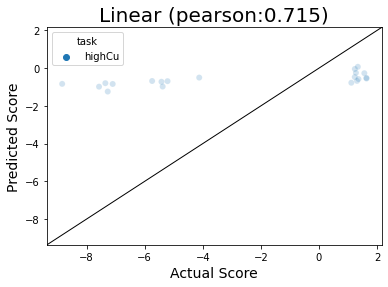

Running CNN


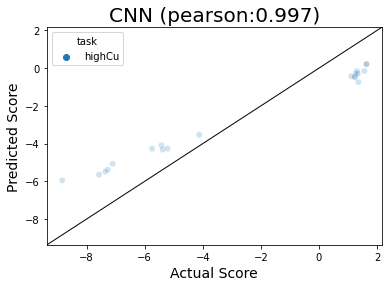

Running Kmer3


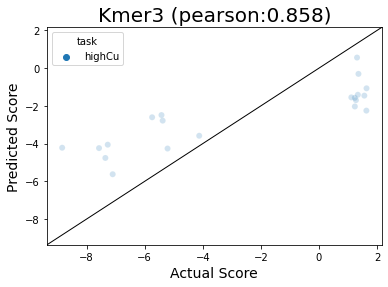

Running Kmer6


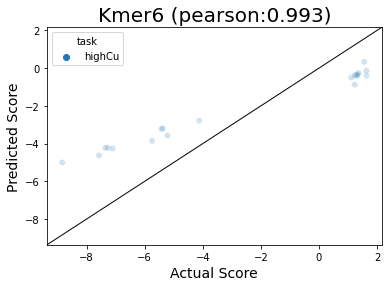

In [53]:
# models = [
#     ("LinearDeep_LR:NoCu",best_lin),
#     ("CNN_LR:NoCu",best_cnn),
#     ("Kmer3_LR:NoCu",best_kmer3),
#     ("Kmer6_LR:NoCu",best_kmer6),
# ]

models = [
    ("Linear",best_lin,DatasetSpec('ohe')),
    ("CNN",best_cnn,DatasetSpec('ohe')),
    ("Kmer3",best_kmer3,DatasetSpec('kmer',k=3)),
    ("Kmer6",best_kmer6,DatasetSpec('kmer',k=6)),
    #("CNN_8mer",mer8motif_model_cnn),
    
    #("CNN2_8mer",mer8motif_model_cnn2),
]

genes = XYdf_smol['locus_tag'].values
task = "opt_best_LR:NoCu"

dfs = parity_pred_multi(models, genes, oracle_nocu,task,['highCu'],alt=False)

In [70]:
def parity_pred(models, genes, oracle,task,alt=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")
        
                
            actual = oracle[gene][0]
            pred = model(s.float())
            data.append([gene,actual,pred.item()])
        
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        pearson = df['truth'].corr(df['pred'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            tu.alt_parity_plot(model_name, df, pearson,task)
        tu.parity_plot(model_name, df, pearson)

    return dfs

Running Linear


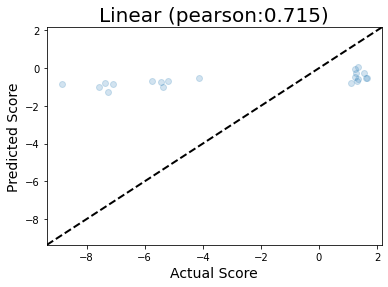

Running CNN


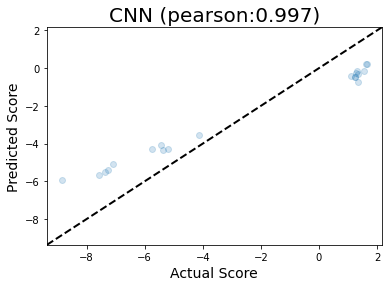

Running Kmer3


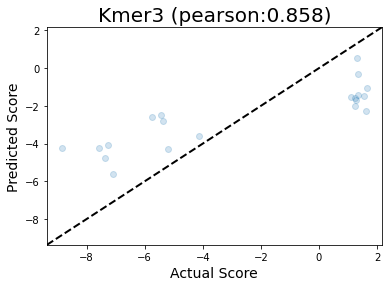

Running Kmer6


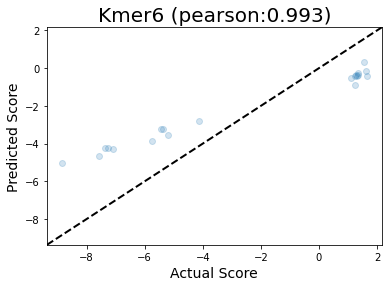

In [72]:
models = [
    ("Linear",best_lin,DatasetSpec('ohe')),
    ("CNN",best_cnn,DatasetSpec('ohe')),
    ("Kmer3",best_kmer3,DatasetSpec('kmer',k=3)),
    ("Kmer6",best_kmer6,DatasetSpec('kmer',k=6)),
    #("CNN_8mer",mer8motif_model_cnn),
    
    #("CNN2_8mer",mer8motif_model_cnn2),
]


#seqs = val_df['upstream_region'].values
genes = XYdf_smol['locus_tag'].values
task = "high:noCu"

dfs = parity_pred(models, genes, oracle_nocu,task,alt=False)

In [89]:
cnn_opt_study.best_params

{'conv0_filt_num': 64,
 'conv0_kernel_size': 8,
 'conv0_pool_size': 1,
 'conv0_dropout': 0.1,
 'n_hidden_conv': 0,
 'n_hidden_fc': 0}

In [91]:
XYdf_og.skew()

og_index                -0.019813
uMax                    -4.597662
lowO2_fast_growth       -3.717380
lowCH4                  -5.052518
MeOH                    -2.177226
NoCu                     0.000000
medCu                   -1.155126
highCu                  -5.785891
lowCu                    1.164351
highO2_slow_growth      -2.897980
NO3_lowO2_slow_growth    0.296438
WithLanthanum            0.120648
NoLanthanum              0.076901
dtype: float64

# Optuna viz functions

In [82]:
def opt_plots(study,skip_importances=False):
    display(optuna.visualization.plot_optimization_history(study))
    if not skip_importances:
        display(optuna.visualization.plot_param_importances(study))
    display(optuna.visualization.plot_slice(study))
    display(optuna.visualization.plot_parallel_coordinate(study))
    

In [84]:
opt_plots(lin_opt_study)

In [83]:
opt_plots(cnn_opt_study)

In [85]:
opt_plots(kmer3_opt_study)

In [86]:
opt_plots(kmer6_opt_study)